# Libraries

In [1]:
# imports
import pandas as pd
import numpy as np
import json
import time
import matplotlib.pyplot as plt
from collections import Counter

import keras
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# Import models from another notebook
%run model.ipynb
%run util.ipynb

# Preprocessing

In [3]:
# load inputs
sudokus = pd.read_csv('./datasets/sudoku-kaggle.csv').values
print("Full shape:", sudokus.shape)

Full shape: (1000000, 2)


In [4]:
# Examine first 5 rows
sudokus[:5]

array([['004300209005009001070060043006002087190007400050083000600000105003508690042910300',
        '864371259325849761971265843436192587198657432257483916689734125713528694542916378'],
       ['040100050107003960520008000000000017000906800803050620090060543600080700250097100',
        '346179258187523964529648371965832417472916835813754629798261543631485792254397186'],
       ['600120384008459072000006005000264030070080006940003000310000050089700000502000190',
        '695127384138459672724836915851264739273981546946573821317692458489715263562348197'],
       ['497200000100400005000016098620300040300900000001072600002005870000600004530097061',
        '497258316186439725253716498629381547375964182841572639962145873718623954534897261'],
       ['005910308009403060027500100030000201000820007006007004000080000640150700890000420',
        '465912378189473562327568149738645291954821637216397854573284916642159783891736425']],
      dtype=object)

In [5]:
# Preprocess
X_kaggle, y_kaggle = sudokus[:, 0], sudokus[:, 1]
X_kaggle, y_kaggle = preprocess(X_kaggle, y_kaggle, 
                                from_string=True, 
                                reshape=True, 
                                one_hot=False)

Initial shape of X: (1000000,)
Initial shape of y: (1000000,)
Convert strings in X to: (1000000, 81)
Convert strings in y to: (1000000, 81)
Reshape X to: (1000000, 9, 9)
Reshape y to: (1000000, 9, 9)


In [6]:
# After reshape
X_kaggle[0]

array([[0, 0, 4, 3, 0, 0, 2, 0, 9],
       [0, 0, 5, 0, 0, 9, 0, 0, 1],
       [0, 7, 0, 0, 6, 0, 0, 4, 3],
       [0, 0, 6, 0, 0, 2, 0, 8, 7],
       [1, 9, 0, 0, 0, 7, 4, 0, 0],
       [0, 5, 0, 0, 8, 3, 0, 0, 0],
       [6, 0, 0, 0, 0, 0, 1, 0, 5],
       [0, 0, 3, 5, 0, 8, 6, 9, 0],
       [0, 4, 2, 9, 1, 0, 3, 0, 0]])

Maximum #clues: 37
Minimum #clues: 29
Average #clues: 33.81279


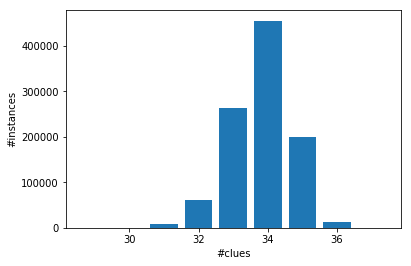

In [5]:
# Count clues
clues = np.sum(X_kaggle != 0, axis=(1, 2))
print("Maximum #clues:", np.max(clues))
print("Minimum #clues:", np.min(clues))
print("Average #clues:", np.mean(clues))

# plot bar
counter = Counter(clues)
plt.bar(counter.keys(), counter.values())
plt.xlabel('#clues')
plt.ylabel('#instances')
plt.show()

In [7]:
#   DEGREE OF DIFFICULTY   |  SCORE                                                
# -------------------------+------------------------------------------             
#   TRIVIAL                |  80 points or less                                    
#   EASY                   |  81 - 150 points                                      
#   MEDIUM                 |  151 - 250 points                                     
#   HARD                   |  251 - 400 points                                     
#   VERY HARD              |  401 - 900 points                                     
#   DIABOLICAL             |  901 and up                                           
start = time.time()
evals = calculate_difficulty(X_kaggle)
print("Runtime: {} seconds".format(time.time() - start))

In [9]:
# Number of solutions # TODO rerun
counts = list(map(lambda x: int(x['counts'][0]), evals))
print("Maximum #solutions:", np.max(counts))
print("Minimum #solutions:", np.min(counts))
print("Average #solutions:", np.mean(counts))

Maximum #solutions: 1
Minimum #solutions: 1
Average #solutions: 1.0


In [10]:
# scores
scores = list(map(lambda x: int(x['scores'][0]), evals))
print("Maximum score:", np.max(scores))
print("Minimum score:", np.min(scores))
print("Average score:", np.mean(scores))

Maximum score: 49
Minimum score: 46
Average score: 47.2


In [6]:
# One-hot encoding
X_kaggle, y_kaggle = preprocess(X_kaggle, y_kaggle, 
                                from_string=False, 
                                reshape=False, 
                                one_hot=True)

Initial shape of X: (1000000, 9, 9)
Initial shape of y: (1000000, 9, 9)
Shape of one-hot X: (1000000, 9, 9, 10)
Shape of one-hot y: (1000000, 9, 9, 9)


In [7]:
# Get 50000 for training and testing only
X_kaggle_used, X_kaggle_hold, y_kaggle_used, y_kaggle_hold = train_test_split(X_kaggle, y_kaggle, 
                                                                              test_size=0.95,
                                                                              random_state=42)
print("Used X shape:", X_kaggle_used.shape)
print("Used y shape:", y_kaggle_used.shape)
print("Hold X shape:", X_kaggle_hold.shape)
print("Hold X shape:", y_kaggle_hold.shape)

Used X shape: (50000, 9, 9, 10)
Used y shape: (50000, 9, 9, 9)
Hold X shape: (950000, 9, 9, 10)
Hold X shape: (950000, 9, 9, 9)


In [8]:
# train, test, validation split
X_kaggle_train, X_kaggle_test, y_kaggle_train, y_kaggle_test = train_test_split(X_kaggle_used,
                                                                                y_kaggle_used,
                                                                                test_size=0.2, 
                                                                                random_state=42)
X_kaggle_train, X_kaggle_val, y_kaggle_train, y_kaggle_val = train_test_split(X_kaggle_train, 
                                                                              y_kaggle_train, 
                                                                              test_size=0.2, 
                                                                              random_state=42)
print("Training data shape:", X_kaggle_train.shape)
print("Training labels shape:", y_kaggle_train.shape)
print("Validation data shape:", X_kaggle_val.shape)
print("Validation labels shape:", y_kaggle_val.shape)
print("Testing data shape:", X_kaggle_test.shape)
print("Testing labels shape:", y_kaggle_test.shape)

Training data shape: (32000, 9, 9, 10)
Training labels shape: (32000, 9, 9, 9)
Validation data shape: (8000, 9, 9, 10)
Validation labels shape: (8000, 9, 9, 9)
Testing data shape: (10000, 9, 9, 10)
Testing labels shape: (10000, 9, 9, 9)


In [9]:
# Completed puzzles create from solutions
X_kaggle_train_completed = to_puzzles(y_kaggle_train)
print("Completed training data shape:", X_kaggle_train_completed.shape)

Completed training data shape: (32000, 9, 9, 10)


# Training

### Dense model

In [10]:
dense = get_model(input_shape=X_kaggle_train.shape[1:], model_id='dense_model')
dense.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 9, 9, 10)     0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 5184)         4864        input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 9)            46665       sequential_1[1][0]               
__________________________________________________________________________________________________
dense_4 (Dense)      

In [11]:
# hidden architecture
dense.layers[1].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9, 9, 64)          704       
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 9, 9, 64)          4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
Total params: 4,864
Trainable params: 4,864
Non-trainable params: 0
_________________________________________________________________


In [10]:
# mini-batches with #epochs and #blanks
n_epochs = [1, 1, 2, 3, 5, 7, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
n_blanks = [0, 1, 2, 3, 5, 7, 9, 12, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 64]
batch_size = [256] * len(n_epochs)

In [14]:
# train models
start = time.time()
train_model(dense, X_kaggle_train_completed, y_kaggle_train, X_kaggle_val, y_kaggle_val,
            True, False, n_blanks, n_epochs, batch_size, save_prefix='./models/dense_model')
print("Runtime: {} seconds".format(time.time() - start))

Iteration 1:
Instructions for updating:
Use tf.cast instead.
Train on 32000 samples, validate on 8000 samples
Epoch 1/1
32000/32000 [==============================] - 75s 2ms/step - loss: 88.3113 - dense_3_loss: 1.0905 - dense_4_loss: 1.0797 - dense_5_loss: 1.0936 - dense_6_loss: 1.0946 - dense_7_loss: 1.0859 - dense_8_loss: 1.0945 - dense_9_loss: 1.0880 - dense_10_loss: 1.0779 - dense_11_loss: 1.0962 - dense_12_loss: 1.0912 - dense_13_loss: 1.0997 - dense_14_loss: 1.0965 - dense_15_loss: 1.0868 - dense_16_loss: 1.0866 - dense_17_loss: 1.0880 - dense_18_loss: 1.0902 - dense_19_loss: 1.0860 - dense_20_loss: 1.0905 - dense_21_loss: 1.0837 - dense_22_loss: 1.0943 - dense_23_loss: 1.0845 - dense_24_loss: 1.0930 - dense_25_loss: 1.0970 - dense_26_loss: 1.0777 - dense_27_loss: 1.0935 - dense_28_loss: 1.0909 - dense_29_loss: 1.0915 - dense_30_loss: 1.0871 - dense_31_loss: 1.0880 - dense_32_loss: 1.0954 - dense_33_loss: 1.0948 - dense_34_loss: 1.0998 - dense_35_loss: 1.0929 - dense_36_loss: 1.

Iteration 2:
Train on 32000 samples, validate on 8000 samples
Epoch 1/1
32000/32000 [==============================] - 59s 2ms/step - loss: 3.8497 - dense_3_loss: 0.0471 - dense_4_loss: 0.0482 - dense_5_loss: 0.0475 - dense_6_loss: 0.0463 - dense_7_loss: 0.0474 - dense_8_loss: 0.0468 - dense_9_loss: 0.0462 - dense_10_loss: 0.0462 - dense_11_loss: 0.0464 - dense_12_loss: 0.0500 - dense_13_loss: 0.0504 - dense_14_loss: 0.0488 - dense_15_loss: 0.0464 - dense_16_loss: 0.0455 - dense_17_loss: 0.0479 - dense_18_loss: 0.0468 - dense_19_loss: 0.0487 - dense_20_loss: 0.0491 - dense_21_loss: 0.0466 - dense_22_loss: 0.0481 - dense_23_loss: 0.0485 - dense_24_loss: 0.0479 - dense_25_loss: 0.0501 - dense_26_loss: 0.0455 - dense_27_loss: 0.0481 - dense_28_loss: 0.0456 - dense_29_loss: 0.0473 - dense_30_loss: 0.0464 - dense_31_loss: 0.0444 - dense_32_loss: 0.0478 - dense_33_loss: 0.0495 - dense_34_loss: 0.0468 - dense_35_loss: 0.0493 - dense_36_loss: 0.0466 - dense_37_loss: 0.0464 - dense_38_loss: 0.0

Iteration 3:
Train on 32000 samples, validate on 8000 samples
Epoch 1/2
32000/32000 [==============================] - 59s 2ms/step - loss: 2.0991 - dense_3_loss: 0.0257 - dense_4_loss: 0.0264 - dense_5_loss: 0.0265 - dense_6_loss: 0.0253 - dense_7_loss: 0.0257 - dense_8_loss: 0.0255 - dense_9_loss: 0.0265 - dense_10_loss: 0.0236 - dense_11_loss: 0.0256 - dense_12_loss: 0.0271 - dense_13_loss: 0.0257 - dense_14_loss: 0.0260 - dense_15_loss: 0.0259 - dense_16_loss: 0.0254 - dense_17_loss: 0.0253 - dense_18_loss: 0.0248 - dense_19_loss: 0.0254 - dense_20_loss: 0.0256 - dense_21_loss: 0.0253 - dense_22_loss: 0.0262 - dense_23_loss: 0.0260 - dense_24_loss: 0.0279 - dense_25_loss: 0.0275 - dense_26_loss: 0.0266 - dense_27_loss: 0.0243 - dense_28_loss: 0.0248 - dense_29_loss: 0.0259 - dense_30_loss: 0.0265 - dense_31_loss: 0.0262 - dense_32_loss: 0.0249 - dense_33_loss: 0.0261 - dense_34_loss: 0.0271 - dense_35_loss: 0.0259 - dense_36_loss: 0.0261 - dense_37_loss: 0.0257 - dense_38_loss: 0.0

Epoch 2/2
32000/32000 [==============================] - 58s 2ms/step - loss: 1.2742 - dense_3_loss: 0.0162 - dense_4_loss: 0.0176 - dense_5_loss: 0.0169 - dense_6_loss: 0.0157 - dense_7_loss: 0.0142 - dense_8_loss: 0.0149 - dense_9_loss: 0.0162 - dense_10_loss: 0.0160 - dense_11_loss: 0.0150 - dense_12_loss: 0.0165 - dense_13_loss: 0.0164 - dense_14_loss: 0.0161 - dense_15_loss: 0.0155 - dense_16_loss: 0.0154 - dense_17_loss: 0.0155 - dense_18_loss: 0.0167 - dense_19_loss: 0.0149 - dense_20_loss: 0.0150 - dense_21_loss: 0.0155 - dense_22_loss: 0.0151 - dense_23_loss: 0.0154 - dense_24_loss: 0.0162 - dense_25_loss: 0.0169 - dense_26_loss: 0.0159 - dense_27_loss: 0.0164 - dense_28_loss: 0.0153 - dense_29_loss: 0.0157 - dense_30_loss: 0.0161 - dense_31_loss: 0.0151 - dense_32_loss: 0.0160 - dense_33_loss: 0.0154 - dense_34_loss: 0.0158 - dense_35_loss: 0.0148 - dense_36_loss: 0.0154 - dense_37_loss: 0.0154 - dense_38_loss: 0.0155 - dense_39_loss: 0.0147 - dense_40_loss: 0.0152 - dense_41

Iteration 4:
Train on 32000 samples, validate on 8000 samples
Epoch 1/3
32000/32000 [==============================] - 60s 2ms/step - loss: 1.7260 - dense_3_loss: 0.0225 - dense_4_loss: 0.0201 - dense_5_loss: 0.0211 - dense_6_loss: 0.0230 - dense_7_loss: 0.0217 - dense_8_loss: 0.0204 - dense_9_loss: 0.0204 - dense_10_loss: 0.0204 - dense_11_loss: 0.0230 - dense_12_loss: 0.0225 - dense_13_loss: 0.0224 - dense_14_loss: 0.0242 - dense_15_loss: 0.0248 - dense_16_loss: 0.0216 - dense_17_loss: 0.0249 - dense_18_loss: 0.0200 - dense_19_loss: 0.0200 - dense_20_loss: 0.0196 - dense_21_loss: 0.0217 - dense_22_loss: 0.0210 - dense_23_loss: 0.0224 - dense_24_loss: 0.0214 - dense_25_loss: 0.0234 - dense_26_loss: 0.0207 - dense_27_loss: 0.0209 - dense_28_loss: 0.0205 - dense_29_loss: 0.0205 - dense_30_loss: 0.0203 - dense_31_loss: 0.0226 - dense_32_loss: 0.0201 - dense_33_loss: 0.0210 - dense_34_loss: 0.0193 - dense_35_loss: 0.0231 - dense_36_loss: 0.0213 - dense_37_loss: 0.0208 - dense_38_loss: 0.0

Epoch 2/3
32000/32000 [==============================] - 59s 2ms/step - loss: 1.2620 - dense_3_loss: 0.0175 - dense_4_loss: 0.0176 - dense_5_loss: 0.0161 - dense_6_loss: 0.0168 - dense_7_loss: 0.0155 - dense_8_loss: 0.0162 - dense_9_loss: 0.0150 - dense_10_loss: 0.0175 - dense_11_loss: 0.0158 - dense_12_loss: 0.0154 - dense_13_loss: 0.0156 - dense_14_loss: 0.0153 - dense_15_loss: 0.0170 - dense_16_loss: 0.0165 - dense_17_loss: 0.0155 - dense_18_loss: 0.0164 - dense_19_loss: 0.0143 - dense_20_loss: 0.0137 - dense_21_loss: 0.0158 - dense_22_loss: 0.0145 - dense_23_loss: 0.0152 - dense_24_loss: 0.0161 - dense_25_loss: 0.0158 - dense_26_loss: 0.0162 - dense_27_loss: 0.0158 - dense_28_loss: 0.0157 - dense_29_loss: 0.0151 - dense_30_loss: 0.0139 - dense_31_loss: 0.0151 - dense_32_loss: 0.0147 - dense_33_loss: 0.0149 - dense_34_loss: 0.0172 - dense_35_loss: 0.0181 - dense_36_loss: 0.0171 - dense_37_loss: 0.0161 - dense_38_loss: 0.0140 - dense_39_loss: 0.0144 - dense_40_loss: 0.0129 - dense_41

Epoch 3/3
32000/32000 [==============================] - 59s 2ms/step - loss: 1.0426 - dense_3_loss: 0.0127 - dense_4_loss: 0.0132 - dense_5_loss: 0.0134 - dense_6_loss: 0.0115 - dense_7_loss: 0.0142 - dense_8_loss: 0.0116 - dense_9_loss: 0.0126 - dense_10_loss: 0.0121 - dense_11_loss: 0.0126 - dense_12_loss: 0.0122 - dense_13_loss: 0.0137 - dense_14_loss: 0.0125 - dense_15_loss: 0.0130 - dense_16_loss: 0.0153 - dense_17_loss: 0.0132 - dense_18_loss: 0.0104 - dense_19_loss: 0.0128 - dense_20_loss: 0.0132 - dense_21_loss: 0.0133 - dense_22_loss: 0.0137 - dense_23_loss: 0.0109 - dense_24_loss: 0.0122 - dense_25_loss: 0.0137 - dense_26_loss: 0.0124 - dense_27_loss: 0.0134 - dense_28_loss: 0.0116 - dense_29_loss: 0.0107 - dense_30_loss: 0.0136 - dense_31_loss: 0.0130 - dense_32_loss: 0.0122 - dense_33_loss: 0.0145 - dense_34_loss: 0.0142 - dense_35_loss: 0.0119 - dense_36_loss: 0.0127 - dense_37_loss: 0.0122 - dense_38_loss: 0.0133 - dense_39_loss: 0.0124 - dense_40_loss: 0.0122 - dense_41

Iteration 5:
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 59s 2ms/step - loss: 2.6809 - dense_3_loss: 0.0311 - dense_4_loss: 0.0319 - dense_5_loss: 0.0327 - dense_6_loss: 0.0306 - dense_7_loss: 0.0323 - dense_8_loss: 0.0323 - dense_9_loss: 0.0344 - dense_10_loss: 0.0282 - dense_11_loss: 0.0309 - dense_12_loss: 0.0359 - dense_13_loss: 0.0352 - dense_14_loss: 0.0362 - dense_15_loss: 0.0376 - dense_16_loss: 0.0349 - dense_17_loss: 0.0320 - dense_18_loss: 0.0326 - dense_19_loss: 0.0319 - dense_20_loss: 0.0323 - dense_21_loss: 0.0319 - dense_22_loss: 0.0304 - dense_23_loss: 0.0362 - dense_24_loss: 0.0344 - dense_25_loss: 0.0319 - dense_26_loss: 0.0326 - dense_27_loss: 0.0327 - dense_28_loss: 0.0320 - dense_29_loss: 0.0295 - dense_30_loss: 0.0292 - dense_31_loss: 0.0364 - dense_32_loss: 0.0336 - dense_33_loss: 0.0380 - dense_34_loss: 0.0313 - dense_35_loss: 0.0310 - dense_36_loss: 0.0342 - dense_37_loss: 0.0320 - dense_38_loss: 0.0

Epoch 2/5
32000/32000 [==============================] - 58s 2ms/step - loss: 1.9528 - dense_3_loss: 0.0219 - dense_4_loss: 0.0215 - dense_5_loss: 0.0238 - dense_6_loss: 0.0251 - dense_7_loss: 0.0239 - dense_8_loss: 0.0258 - dense_9_loss: 0.0229 - dense_10_loss: 0.0240 - dense_11_loss: 0.0230 - dense_12_loss: 0.0226 - dense_13_loss: 0.0218 - dense_14_loss: 0.0257 - dense_15_loss: 0.0221 - dense_16_loss: 0.0230 - dense_17_loss: 0.0245 - dense_18_loss: 0.0281 - dense_19_loss: 0.0234 - dense_20_loss: 0.0271 - dense_21_loss: 0.0238 - dense_22_loss: 0.0248 - dense_23_loss: 0.0230 - dense_24_loss: 0.0233 - dense_25_loss: 0.0260 - dense_26_loss: 0.0220 - dense_27_loss: 0.0244 - dense_28_loss: 0.0253 - dense_29_loss: 0.0224 - dense_30_loss: 0.0232 - dense_31_loss: 0.0228 - dense_32_loss: 0.0250 - dense_33_loss: 0.0217 - dense_34_loss: 0.0232 - dense_35_loss: 0.0234 - dense_36_loss: 0.0254 - dense_37_loss: 0.0254 - dense_38_loss: 0.0254 - dense_39_loss: 0.0242 - dense_40_loss: 0.0239 - dense_41

Epoch 3/5
32000/32000 [==============================] - 59s 2ms/step - loss: 1.6508 - dense_3_loss: 0.0220 - dense_4_loss: 0.0197 - dense_5_loss: 0.0222 - dense_6_loss: 0.0201 - dense_7_loss: 0.0171 - dense_8_loss: 0.0200 - dense_9_loss: 0.0230 - dense_10_loss: 0.0201 - dense_11_loss: 0.0188 - dense_12_loss: 0.0195 - dense_13_loss: 0.0199 - dense_14_loss: 0.0176 - dense_15_loss: 0.0225 - dense_16_loss: 0.0184 - dense_17_loss: 0.0209 - dense_18_loss: 0.0192 - dense_19_loss: 0.0178 - dense_20_loss: 0.0243 - dense_21_loss: 0.0193 - dense_22_loss: 0.0211 - dense_23_loss: 0.0196 - dense_24_loss: 0.0209 - dense_25_loss: 0.0188 - dense_26_loss: 0.0215 - dense_27_loss: 0.0188 - dense_28_loss: 0.0178 - dense_29_loss: 0.0221 - dense_30_loss: 0.0225 - dense_31_loss: 0.0199 - dense_32_loss: 0.0213 - dense_33_loss: 0.0200 - dense_34_loss: 0.0183 - dense_35_loss: 0.0214 - dense_36_loss: 0.0219 - dense_37_loss: 0.0210 - dense_38_loss: 0.0195 - dense_39_loss: 0.0241 - dense_40_loss: 0.0182 - dense_41

Epoch 00003: early stopping
Iteration 6:
Train on 32000 samples, validate on 8000 samples
Epoch 1/7
32000/32000 [==============================] - 61s 2ms/step - loss: 3.6143 - dense_3_loss: 0.0426 - dense_4_loss: 0.0417 - dense_5_loss: 0.0431 - dense_6_loss: 0.0487 - dense_7_loss: 0.0507 - dense_8_loss: 0.0434 - dense_9_loss: 0.0439 - dense_10_loss: 0.0448 - dense_11_loss: 0.0404 - dense_12_loss: 0.0405 - dense_13_loss: 0.0410 - dense_14_loss: 0.0455 - dense_15_loss: 0.0404 - dense_16_loss: 0.0448 - dense_17_loss: 0.0445 - dense_18_loss: 0.0432 - dense_19_loss: 0.0403 - dense_20_loss: 0.0423 - dense_21_loss: 0.0465 - dense_22_loss: 0.0484 - dense_23_loss: 0.0477 - dense_24_loss: 0.0448 - dense_25_loss: 0.0437 - dense_26_loss: 0.0428 - dense_27_loss: 0.0475 - dense_28_loss: 0.0443 - dense_29_loss: 0.0466 - dense_30_loss: 0.0466 - dense_31_loss: 0.0409 - dense_32_loss: 0.0515 - dense_33_loss: 0.0414 - dense_34_loss: 0.0481 - dense_35_loss: 0.0488 - dense_36_loss: 0.0418 - dense_37_loss:

Epoch 2/7
32000/32000 [==============================] - 59s 2ms/step - loss: 2.4793 - dense_3_loss: 0.0302 - dense_4_loss: 0.0317 - dense_5_loss: 0.0281 - dense_6_loss: 0.0296 - dense_7_loss: 0.0327 - dense_8_loss: 0.0296 - dense_9_loss: 0.0328 - dense_10_loss: 0.0289 - dense_11_loss: 0.0318 - dense_12_loss: 0.0322 - dense_13_loss: 0.0291 - dense_14_loss: 0.0312 - dense_15_loss: 0.0256 - dense_16_loss: 0.0310 - dense_17_loss: 0.0305 - dense_18_loss: 0.0299 - dense_19_loss: 0.0308 - dense_20_loss: 0.0310 - dense_21_loss: 0.0332 - dense_22_loss: 0.0350 - dense_23_loss: 0.0343 - dense_24_loss: 0.0278 - dense_25_loss: 0.0273 - dense_26_loss: 0.0299 - dense_27_loss: 0.0274 - dense_28_loss: 0.0375 - dense_29_loss: 0.0323 - dense_30_loss: 0.0285 - dense_31_loss: 0.0263 - dense_32_loss: 0.0336 - dense_33_loss: 0.0320 - dense_34_loss: 0.0320 - dense_35_loss: 0.0307 - dense_36_loss: 0.0326 - dense_37_loss: 0.0269 - dense_38_loss: 0.0283 - dense_39_loss: 0.0287 - dense_40_loss: 0.0312 - dense_41

Epoch 3/7
32000/32000 [==============================] - 60s 2ms/step - loss: 2.0311 - dense_3_loss: 0.0262 - dense_4_loss: 0.0282 - dense_5_loss: 0.0266 - dense_6_loss: 0.0242 - dense_7_loss: 0.0240 - dense_8_loss: 0.0248 - dense_9_loss: 0.0293 - dense_10_loss: 0.0250 - dense_11_loss: 0.0262 - dense_12_loss: 0.0251 - dense_13_loss: 0.0262 - dense_14_loss: 0.0250 - dense_15_loss: 0.0233 - dense_16_loss: 0.0227 - dense_17_loss: 0.0230 - dense_18_loss: 0.0234 - dense_19_loss: 0.0265 - dense_20_loss: 0.0227 - dense_21_loss: 0.0244 - dense_22_loss: 0.0264 - dense_23_loss: 0.0236 - dense_24_loss: 0.0233 - dense_25_loss: 0.0246 - dense_26_loss: 0.0280 - dense_27_loss: 0.0238 - dense_28_loss: 0.0269 - dense_29_loss: 0.0243 - dense_30_loss: 0.0252 - dense_31_loss: 0.0256 - dense_32_loss: 0.0250 - dense_33_loss: 0.0266 - dense_34_loss: 0.0266 - dense_35_loss: 0.0229 - dense_36_loss: 0.0210 - dense_37_loss: 0.0243 - dense_38_loss: 0.0268 - dense_39_loss: 0.0253 - dense_40_loss: 0.0258 - dense_41

Epoch 4/7
32000/32000 [==============================] - 59s 2ms/step - loss: 1.8102 - dense_3_loss: 0.0227 - dense_4_loss: 0.0245 - dense_5_loss: 0.0227 - dense_6_loss: 0.0234 - dense_7_loss: 0.0213 - dense_8_loss: 0.0234 - dense_9_loss: 0.0232 - dense_10_loss: 0.0244 - dense_11_loss: 0.0213 - dense_12_loss: 0.0209 - dense_13_loss: 0.0228 - dense_14_loss: 0.0221 - dense_15_loss: 0.0214 - dense_16_loss: 0.0216 - dense_17_loss: 0.0203 - dense_18_loss: 0.0206 - dense_19_loss: 0.0235 - dense_20_loss: 0.0236 - dense_21_loss: 0.0251 - dense_22_loss: 0.0227 - dense_23_loss: 0.0216 - dense_24_loss: 0.0182 - dense_25_loss: 0.0219 - dense_26_loss: 0.0247 - dense_27_loss: 0.0192 - dense_28_loss: 0.0200 - dense_29_loss: 0.0213 - dense_30_loss: 0.0222 - dense_31_loss: 0.0266 - dense_32_loss: 0.0220 - dense_33_loss: 0.0239 - dense_34_loss: 0.0222 - dense_35_loss: 0.0222 - dense_36_loss: 0.0183 - dense_37_loss: 0.0230 - dense_38_loss: 0.0237 - dense_39_loss: 0.0211 - dense_40_loss: 0.0252 - dense_41

Epoch 00004: early stopping
Iteration 7:
Train on 32000 samples, validate on 8000 samples
Epoch 1/9
32000/32000 [==============================] - 59s 2ms/step - loss: 4.1540 - dense_3_loss: 0.0528 - dense_4_loss: 0.0527 - dense_5_loss: 0.0535 - dense_6_loss: 0.0484 - dense_7_loss: 0.0523 - dense_8_loss: 0.0516 - dense_9_loss: 0.0494 - dense_10_loss: 0.0514 - dense_11_loss: 0.0495 - dense_12_loss: 0.0508 - dense_13_loss: 0.0495 - dense_14_loss: 0.0492 - dense_15_loss: 0.0524 - dense_16_loss: 0.0534 - dense_17_loss: 0.0533 - dense_18_loss: 0.0477 - dense_19_loss: 0.0443 - dense_20_loss: 0.0597 - dense_21_loss: 0.0521 - dense_22_loss: 0.0527 - dense_23_loss: 0.0547 - dense_24_loss: 0.0501 - dense_25_loss: 0.0512 - dense_26_loss: 0.0496 - dense_27_loss: 0.0494 - dense_28_loss: 0.0485 - dense_29_loss: 0.0487 - dense_30_loss: 0.0545 - dense_31_loss: 0.0536 - dense_32_loss: 0.0502 - dense_33_loss: 0.0484 - dense_34_loss: 0.0490 - dense_35_loss: 0.0512 - dense_36_loss: 0.0525 - dense_37_loss:

Epoch 2/9
32000/32000 [==============================] - 59s 2ms/step - loss: 2.6924 - dense_3_loss: 0.0313 - dense_4_loss: 0.0318 - dense_5_loss: 0.0327 - dense_6_loss: 0.0326 - dense_7_loss: 0.0337 - dense_8_loss: 0.0358 - dense_9_loss: 0.0318 - dense_10_loss: 0.0349 - dense_11_loss: 0.0335 - dense_12_loss: 0.0304 - dense_13_loss: 0.0326 - dense_14_loss: 0.0349 - dense_15_loss: 0.0308 - dense_16_loss: 0.0351 - dense_17_loss: 0.0337 - dense_18_loss: 0.0287 - dense_19_loss: 0.0329 - dense_20_loss: 0.0320 - dense_21_loss: 0.0321 - dense_22_loss: 0.0331 - dense_23_loss: 0.0322 - dense_24_loss: 0.0372 - dense_25_loss: 0.0307 - dense_26_loss: 0.0301 - dense_27_loss: 0.0332 - dense_28_loss: 0.0334 - dense_29_loss: 0.0321 - dense_30_loss: 0.0340 - dense_31_loss: 0.0361 - dense_32_loss: 0.0355 - dense_33_loss: 0.0290 - dense_34_loss: 0.0348 - dense_35_loss: 0.0336 - dense_36_loss: 0.0345 - dense_37_loss: 0.0323 - dense_38_loss: 0.0381 - dense_39_loss: 0.0336 - dense_40_loss: 0.0324 - dense_41

Epoch 3/9
32000/32000 [==============================] - 59s 2ms/step - loss: 2.1789 - dense_3_loss: 0.0270 - dense_4_loss: 0.0261 - dense_5_loss: 0.0295 - dense_6_loss: 0.0276 - dense_7_loss: 0.0290 - dense_8_loss: 0.0238 - dense_9_loss: 0.0296 - dense_10_loss: 0.0274 - dense_11_loss: 0.0281 - dense_12_loss: 0.0265 - dense_13_loss: 0.0269 - dense_14_loss: 0.0289 - dense_15_loss: 0.0282 - dense_16_loss: 0.0271 - dense_17_loss: 0.0258 - dense_18_loss: 0.0248 - dense_19_loss: 0.0255 - dense_20_loss: 0.0257 - dense_21_loss: 0.0249 - dense_22_loss: 0.0282 - dense_23_loss: 0.0252 - dense_24_loss: 0.0269 - dense_25_loss: 0.0273 - dense_26_loss: 0.0300 - dense_27_loss: 0.0250 - dense_28_loss: 0.0277 - dense_29_loss: 0.0258 - dense_30_loss: 0.0294 - dense_31_loss: 0.0272 - dense_32_loss: 0.0278 - dense_33_loss: 0.0272 - dense_34_loss: 0.0255 - dense_35_loss: 0.0283 - dense_36_loss: 0.0258 - dense_37_loss: 0.0255 - dense_38_loss: 0.0296 - dense_39_loss: 0.0259 - dense_40_loss: 0.0260 - dense_41

Epoch 4/9
32000/32000 [==============================] - 59s 2ms/step - loss: 1.9170 - dense_3_loss: 0.0221 - dense_4_loss: 0.0239 - dense_5_loss: 0.0252 - dense_6_loss: 0.0227 - dense_7_loss: 0.0240 - dense_8_loss: 0.0254 - dense_9_loss: 0.0234 - dense_10_loss: 0.0211 - dense_11_loss: 0.0226 - dense_12_loss: 0.0243 - dense_13_loss: 0.0260 - dense_14_loss: 0.0230 - dense_15_loss: 0.0245 - dense_16_loss: 0.0268 - dense_17_loss: 0.0250 - dense_18_loss: 0.0220 - dense_19_loss: 0.0244 - dense_20_loss: 0.0232 - dense_21_loss: 0.0219 - dense_22_loss: 0.0256 - dense_23_loss: 0.0248 - dense_24_loss: 0.0226 - dense_25_loss: 0.0240 - dense_26_loss: 0.0245 - dense_27_loss: 0.0256 - dense_28_loss: 0.0240 - dense_29_loss: 0.0229 - dense_30_loss: 0.0250 - dense_31_loss: 0.0234 - dense_32_loss: 0.0216 - dense_33_loss: 0.0240 - dense_34_loss: 0.0254 - dense_35_loss: 0.0259 - dense_36_loss: 0.0215 - dense_37_loss: 0.0230 - dense_38_loss: 0.0235 - dense_39_loss: 0.0233 - dense_40_loss: 0.0243 - dense_41

Epoch 5/9
32000/32000 [==============================] - 59s 2ms/step - loss: 1.7800 - dense_3_loss: 0.0191 - dense_4_loss: 0.0217 - dense_5_loss: 0.0236 - dense_6_loss: 0.0243 - dense_7_loss: 0.0207 - dense_8_loss: 0.0233 - dense_9_loss: 0.0219 - dense_10_loss: 0.0185 - dense_11_loss: 0.0224 - dense_12_loss: 0.0200 - dense_13_loss: 0.0213 - dense_14_loss: 0.0212 - dense_15_loss: 0.0245 - dense_16_loss: 0.0190 - dense_17_loss: 0.0204 - dense_18_loss: 0.0195 - dense_19_loss: 0.0217 - dense_20_loss: 0.0222 - dense_21_loss: 0.0193 - dense_22_loss: 0.0220 - dense_23_loss: 0.0217 - dense_24_loss: 0.0221 - dense_25_loss: 0.0233 - dense_26_loss: 0.0216 - dense_27_loss: 0.0210 - dense_28_loss: 0.0244 - dense_29_loss: 0.0233 - dense_30_loss: 0.0198 - dense_31_loss: 0.0250 - dense_32_loss: 0.0208 - dense_33_loss: 0.0217 - dense_34_loss: 0.0204 - dense_35_loss: 0.0228 - dense_36_loss: 0.0244 - dense_37_loss: 0.0213 - dense_38_loss: 0.0206 - dense_39_loss: 0.0239 - dense_40_loss: 0.0235 - dense_41

Epoch 00005: early stopping
Iteration 8:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 59s 2ms/step - loss: 5.1700 - dense_3_loss: 0.0669 - dense_4_loss: 0.0597 - dense_5_loss: 0.0616 - dense_6_loss: 0.0612 - dense_7_loss: 0.0639 - dense_8_loss: 0.0654 - dense_9_loss: 0.0619 - dense_10_loss: 0.0632 - dense_11_loss: 0.0602 - dense_12_loss: 0.0619 - dense_13_loss: 0.0608 - dense_14_loss: 0.0616 - dense_15_loss: 0.0613 - dense_16_loss: 0.0669 - dense_17_loss: 0.0650 - dense_18_loss: 0.0631 - dense_19_loss: 0.0653 - dense_20_loss: 0.0587 - dense_21_loss: 0.0676 - dense_22_loss: 0.0649 - dense_23_loss: 0.0619 - dense_24_loss: 0.0597 - dense_25_loss: 0.0636 - dense_26_loss: 0.0666 - dense_27_loss: 0.0653 - dense_28_loss: 0.0625 - dense_29_loss: 0.0636 - dense_30_loss: 0.0679 - dense_31_loss: 0.0649 - dense_32_loss: 0.0604 - dense_33_loss: 0.0666 - dense_34_loss: 0.0633 - dense_35_loss: 0.0614 - dense_36_loss: 0.0628 - dense_37_loss

Epoch 2/10
32000/32000 [==============================] - 59s 2ms/step - loss: 3.1931 - dense_3_loss: 0.0389 - dense_4_loss: 0.0393 - dense_5_loss: 0.0356 - dense_6_loss: 0.0358 - dense_7_loss: 0.0385 - dense_8_loss: 0.0388 - dense_9_loss: 0.0409 - dense_10_loss: 0.0427 - dense_11_loss: 0.0375 - dense_12_loss: 0.0401 - dense_13_loss: 0.0388 - dense_14_loss: 0.0341 - dense_15_loss: 0.0372 - dense_16_loss: 0.0402 - dense_17_loss: 0.0395 - dense_18_loss: 0.0391 - dense_19_loss: 0.0406 - dense_20_loss: 0.0376 - dense_21_loss: 0.0392 - dense_22_loss: 0.0385 - dense_23_loss: 0.0399 - dense_24_loss: 0.0359 - dense_25_loss: 0.0379 - dense_26_loss: 0.0404 - dense_27_loss: 0.0383 - dense_28_loss: 0.0402 - dense_29_loss: 0.0394 - dense_30_loss: 0.0379 - dense_31_loss: 0.0455 - dense_32_loss: 0.0423 - dense_33_loss: 0.0426 - dense_34_loss: 0.0410 - dense_35_loss: 0.0421 - dense_36_loss: 0.0406 - dense_37_loss: 0.0398 - dense_38_loss: 0.0392 - dense_39_loss: 0.0418 - dense_40_loss: 0.0374 - dense_4

Epoch 3/10
32000/32000 [==============================] - 60s 2ms/step - loss: 2.6763 - dense_3_loss: 0.0340 - dense_4_loss: 0.0344 - dense_5_loss: 0.0299 - dense_6_loss: 0.0308 - dense_7_loss: 0.0307 - dense_8_loss: 0.0312 - dense_9_loss: 0.0315 - dense_10_loss: 0.0316 - dense_11_loss: 0.0315 - dense_12_loss: 0.0323 - dense_13_loss: 0.0328 - dense_14_loss: 0.0302 - dense_15_loss: 0.0324 - dense_16_loss: 0.0334 - dense_17_loss: 0.0328 - dense_18_loss: 0.0322 - dense_19_loss: 0.0363 - dense_20_loss: 0.0345 - dense_21_loss: 0.0324 - dense_22_loss: 0.0310 - dense_23_loss: 0.0332 - dense_24_loss: 0.0350 - dense_25_loss: 0.0329 - dense_26_loss: 0.0328 - dense_27_loss: 0.0325 - dense_28_loss: 0.0321 - dense_29_loss: 0.0313 - dense_30_loss: 0.0324 - dense_31_loss: 0.0335 - dense_32_loss: 0.0330 - dense_33_loss: 0.0330 - dense_34_loss: 0.0335 - dense_35_loss: 0.0325 - dense_36_loss: 0.0364 - dense_37_loss: 0.0336 - dense_38_loss: 0.0342 - dense_39_loss: 0.0350 - dense_40_loss: 0.0327 - dense_4

Epoch 00003: early stopping
Iteration 9:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 59s 2ms/step - loss: 6.1728 - dense_3_loss: 0.0806 - dense_4_loss: 0.0754 - dense_5_loss: 0.0788 - dense_6_loss: 0.0738 - dense_7_loss: 0.0815 - dense_8_loss: 0.0778 - dense_9_loss: 0.0747 - dense_10_loss: 0.0740 - dense_11_loss: 0.0769 - dense_12_loss: 0.0747 - dense_13_loss: 0.0731 - dense_14_loss: 0.0738 - dense_15_loss: 0.0742 - dense_16_loss: 0.0774 - dense_17_loss: 0.0760 - dense_18_loss: 0.0764 - dense_19_loss: 0.0738 - dense_20_loss: 0.0773 - dense_21_loss: 0.0748 - dense_22_loss: 0.0765 - dense_23_loss: 0.0785 - dense_24_loss: 0.0746 - dense_25_loss: 0.0799 - dense_26_loss: 0.0772 - dense_27_loss: 0.0766 - dense_28_loss: 0.0776 - dense_29_loss: 0.0778 - dense_30_loss: 0.0740 - dense_31_loss: 0.0766 - dense_32_loss: 0.0760 - dense_33_loss: 0.0747 - dense_34_loss: 0.0773 - dense_35_loss: 0.0765 - dense_36_loss: 0.0766 - dense_37_loss

Epoch 2/10
32000/32000 [==============================] - 59s 2ms/step - loss: 4.1617 - dense_3_loss: 0.0532 - dense_4_loss: 0.0527 - dense_5_loss: 0.0508 - dense_6_loss: 0.0493 - dense_7_loss: 0.0490 - dense_8_loss: 0.0510 - dense_9_loss: 0.0531 - dense_10_loss: 0.0520 - dense_11_loss: 0.0504 - dense_12_loss: 0.0534 - dense_13_loss: 0.0513 - dense_14_loss: 0.0544 - dense_15_loss: 0.0550 - dense_16_loss: 0.0515 - dense_17_loss: 0.0527 - dense_18_loss: 0.0521 - dense_19_loss: 0.0486 - dense_20_loss: 0.0514 - dense_21_loss: 0.0512 - dense_22_loss: 0.0498 - dense_23_loss: 0.0514 - dense_24_loss: 0.0501 - dense_25_loss: 0.0564 - dense_26_loss: 0.0517 - dense_27_loss: 0.0500 - dense_28_loss: 0.0511 - dense_29_loss: 0.0533 - dense_30_loss: 0.0485 - dense_31_loss: 0.0526 - dense_32_loss: 0.0515 - dense_33_loss: 0.0509 - dense_34_loss: 0.0485 - dense_35_loss: 0.0520 - dense_36_loss: 0.0513 - dense_37_loss: 0.0487 - dense_38_loss: 0.0535 - dense_39_loss: 0.0485 - dense_40_loss: 0.0520 - dense_4

Epoch 3/10
32000/32000 [==============================] - 59s 2ms/step - loss: 3.6037 - dense_3_loss: 0.0445 - dense_4_loss: 0.0439 - dense_5_loss: 0.0477 - dense_6_loss: 0.0462 - dense_7_loss: 0.0448 - dense_8_loss: 0.0475 - dense_9_loss: 0.0432 - dense_10_loss: 0.0420 - dense_11_loss: 0.0443 - dense_12_loss: 0.0457 - dense_13_loss: 0.0438 - dense_14_loss: 0.0470 - dense_15_loss: 0.0493 - dense_16_loss: 0.0451 - dense_17_loss: 0.0469 - dense_18_loss: 0.0455 - dense_19_loss: 0.0436 - dense_20_loss: 0.0443 - dense_21_loss: 0.0427 - dense_22_loss: 0.0453 - dense_23_loss: 0.0465 - dense_24_loss: 0.0473 - dense_25_loss: 0.0448 - dense_26_loss: 0.0455 - dense_27_loss: 0.0458 - dense_28_loss: 0.0464 - dense_29_loss: 0.0458 - dense_30_loss: 0.0469 - dense_31_loss: 0.0438 - dense_32_loss: 0.0432 - dense_33_loss: 0.0441 - dense_34_loss: 0.0435 - dense_35_loss: 0.0429 - dense_36_loss: 0.0449 - dense_37_loss: 0.0428 - dense_38_loss: 0.0464 - dense_39_loss: 0.0435 - dense_40_loss: 0.0476 - dense_4

Epoch 00003: early stopping
Iteration 10:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 61s 2ms/step - loss: 9.7305 - dense_3_loss: 0.1190 - dense_4_loss: 0.1134 - dense_5_loss: 0.1158 - dense_6_loss: 0.1193 - dense_7_loss: 0.1208 - dense_8_loss: 0.1212 - dense_9_loss: 0.1187 - dense_10_loss: 0.1175 - dense_11_loss: 0.1181 - dense_12_loss: 0.1183 - dense_13_loss: 0.1203 - dense_14_loss: 0.1179 - dense_15_loss: 0.1201 - dense_16_loss: 0.1254 - dense_17_loss: 0.1203 - dense_18_loss: 0.1213 - dense_19_loss: 0.1248 - dense_20_loss: 0.1180 - dense_21_loss: 0.1231 - dense_22_loss: 0.1215 - dense_23_loss: 0.1254 - dense_24_loss: 0.1221 - dense_25_loss: 0.1197 - dense_26_loss: 0.1200 - dense_27_loss: 0.1195 - dense_28_loss: 0.1241 - dense_29_loss: 0.1212 - dense_30_loss: 0.1184 - dense_31_loss: 0.1203 - dense_32_loss: 0.1219 - dense_33_loss: 0.1192 - dense_34_loss: 0.1229 - dense_35_loss: 0.1224 - dense_36_loss: 0.1205 - dense_37_los

Epoch 2/10
32000/32000 [==============================] - 61s 2ms/step - loss: 6.9645 - dense_3_loss: 0.0840 - dense_4_loss: 0.0880 - dense_5_loss: 0.0880 - dense_6_loss: 0.0877 - dense_7_loss: 0.0890 - dense_8_loss: 0.0870 - dense_9_loss: 0.0822 - dense_10_loss: 0.0843 - dense_11_loss: 0.0824 - dense_12_loss: 0.0847 - dense_13_loss: 0.0885 - dense_14_loss: 0.0845 - dense_15_loss: 0.0874 - dense_16_loss: 0.0868 - dense_17_loss: 0.0886 - dense_18_loss: 0.0841 - dense_19_loss: 0.0859 - dense_20_loss: 0.0883 - dense_21_loss: 0.0926 - dense_22_loss: 0.0835 - dense_23_loss: 0.0867 - dense_24_loss: 0.0872 - dense_25_loss: 0.0895 - dense_26_loss: 0.0852 - dense_27_loss: 0.0851 - dense_28_loss: 0.0891 - dense_29_loss: 0.0862 - dense_30_loss: 0.0826 - dense_31_loss: 0.0847 - dense_32_loss: 0.0875 - dense_33_loss: 0.0840 - dense_34_loss: 0.0841 - dense_35_loss: 0.0931 - dense_36_loss: 0.0882 - dense_37_loss: 0.0871 - dense_38_loss: 0.0858 - dense_39_loss: 0.0891 - dense_40_loss: 0.0846 - dense_4

Epoch 3/10
32000/32000 [==============================] - 59s 2ms/step - loss: 6.2340 - dense_3_loss: 0.0743 - dense_4_loss: 0.0775 - dense_5_loss: 0.0792 - dense_6_loss: 0.0787 - dense_7_loss: 0.0789 - dense_8_loss: 0.0751 - dense_9_loss: 0.0765 - dense_10_loss: 0.0714 - dense_11_loss: 0.0765 - dense_12_loss: 0.0752 - dense_13_loss: 0.0747 - dense_14_loss: 0.0747 - dense_15_loss: 0.0771 - dense_16_loss: 0.0761 - dense_17_loss: 0.0780 - dense_18_loss: 0.0758 - dense_19_loss: 0.0784 - dense_20_loss: 0.0802 - dense_21_loss: 0.0792 - dense_22_loss: 0.0766 - dense_23_loss: 0.0785 - dense_24_loss: 0.0777 - dense_25_loss: 0.0827 - dense_26_loss: 0.0762 - dense_27_loss: 0.0773 - dense_28_loss: 0.0769 - dense_29_loss: 0.0778 - dense_30_loss: 0.0750 - dense_31_loss: 0.0734 - dense_32_loss: 0.0725 - dense_33_loss: 0.0757 - dense_34_loss: 0.0747 - dense_35_loss: 0.0776 - dense_36_loss: 0.0845 - dense_37_loss: 0.0710 - dense_38_loss: 0.0730 - dense_39_loss: 0.0788 - dense_40_loss: 0.0763 - dense_4

Epoch 00003: early stopping
Iteration 11:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 59s 2ms/step - loss: 14.1618 - dense_3_loss: 0.1738 - dense_4_loss: 0.1753 - dense_5_loss: 0.1777 - dense_6_loss: 0.1704 - dense_7_loss: 0.1772 - dense_8_loss: 0.1725 - dense_9_loss: 0.1712 - dense_10_loss: 0.1765 - dense_11_loss: 0.1744 - dense_12_loss: 0.1754 - dense_13_loss: 0.1743 - dense_14_loss: 0.1777 - dense_15_loss: 0.1737 - dense_16_loss: 0.1690 - dense_17_loss: 0.1727 - dense_18_loss: 0.1689 - dense_19_loss: 0.1766 - dense_20_loss: 0.1744 - dense_21_loss: 0.1775 - dense_22_loss: 0.1724 - dense_23_loss: 0.1769 - dense_24_loss: 0.1723 - dense_25_loss: 0.1725 - dense_26_loss: 0.1736 - dense_27_loss: 0.1812 - dense_28_loss: 0.1800 - dense_29_loss: 0.1774 - dense_30_loss: 0.1740 - dense_31_loss: 0.1782 - dense_32_loss: 0.1699 - dense_33_loss: 0.1692 - dense_34_loss: 0.1778 - dense_35_loss: 0.1744 - dense_36_loss: 0.1735 - dense_37_lo

Epoch 2/10
32000/32000 [==============================] - 59s 2ms/step - loss: 10.9149 - dense_3_loss: 0.1344 - dense_4_loss: 0.1358 - dense_5_loss: 0.1374 - dense_6_loss: 0.1364 - dense_7_loss: 0.1360 - dense_8_loss: 0.1308 - dense_9_loss: 0.1307 - dense_10_loss: 0.1369 - dense_11_loss: 0.1325 - dense_12_loss: 0.1368 - dense_13_loss: 0.1307 - dense_14_loss: 0.1368 - dense_15_loss: 0.1313 - dense_16_loss: 0.1350 - dense_17_loss: 0.1333 - dense_18_loss: 0.1304 - dense_19_loss: 0.1322 - dense_20_loss: 0.1304 - dense_21_loss: 0.1391 - dense_22_loss: 0.1315 - dense_23_loss: 0.1349 - dense_24_loss: 0.1365 - dense_25_loss: 0.1348 - dense_26_loss: 0.1302 - dense_27_loss: 0.1342 - dense_28_loss: 0.1334 - dense_29_loss: 0.1390 - dense_30_loss: 0.1324 - dense_31_loss: 0.1365 - dense_32_loss: 0.1337 - dense_33_loss: 0.1329 - dense_34_loss: 0.1422 - dense_35_loss: 0.1345 - dense_36_loss: 0.1349 - dense_37_loss: 0.1345 - dense_38_loss: 0.1337 - dense_39_loss: 0.1312 - dense_40_loss: 0.1325 - dense_

Epoch 3/10
32000/32000 [==============================] - 59s 2ms/step - loss: 9.9173 - dense_3_loss: 0.1235 - dense_4_loss: 0.1284 - dense_5_loss: 0.1227 - dense_6_loss: 0.1257 - dense_7_loss: 0.1219 - dense_8_loss: 0.1217 - dense_9_loss: 0.1177 - dense_10_loss: 0.1212 - dense_11_loss: 0.1218 - dense_12_loss: 0.1232 - dense_13_loss: 0.1212 - dense_14_loss: 0.1248 - dense_15_loss: 0.1183 - dense_16_loss: 0.1194 - dense_17_loss: 0.1220 - dense_18_loss: 0.1204 - dense_19_loss: 0.1235 - dense_20_loss: 0.1168 - dense_21_loss: 0.1214 - dense_22_loss: 0.1215 - dense_23_loss: 0.1197 - dense_24_loss: 0.1245 - dense_25_loss: 0.1223 - dense_26_loss: 0.1217 - dense_27_loss: 0.1236 - dense_28_loss: 0.1248 - dense_29_loss: 0.1246 - dense_30_loss: 0.1194 - dense_31_loss: 0.1235 - dense_32_loss: 0.1224 - dense_33_loss: 0.1238 - dense_34_loss: 0.1219 - dense_35_loss: 0.1225 - dense_36_loss: 0.1257 - dense_37_loss: 0.1236 - dense_38_loss: 0.1225 - dense_39_loss: 0.1215 - dense_40_loss: 0.1277 - dense_4

Epoch 00003: early stopping
Iteration 12:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 59s 2ms/step - loss: 19.9284 - dense_3_loss: 0.2414 - dense_4_loss: 0.2423 - dense_5_loss: 0.2407 - dense_6_loss: 0.2440 - dense_7_loss: 0.2501 - dense_8_loss: 0.2514 - dense_9_loss: 0.2436 - dense_10_loss: 0.2502 - dense_11_loss: 0.2428 - dense_12_loss: 0.2435 - dense_13_loss: 0.2444 - dense_14_loss: 0.2359 - dense_15_loss: 0.2452 - dense_16_loss: 0.2473 - dense_17_loss: 0.2421 - dense_18_loss: 0.2492 - dense_19_loss: 0.2443 - dense_20_loss: 0.2452 - dense_21_loss: 0.2522 - dense_22_loss: 0.2511 - dense_23_loss: 0.2467 - dense_24_loss: 0.2435 - dense_25_loss: 0.2485 - dense_26_loss: 0.2468 - dense_27_loss: 0.2404 - dense_28_loss: 0.2394 - dense_29_loss: 0.2488 - dense_30_loss: 0.2448 - dense_31_loss: 0.2442 - dense_32_loss: 0.2456 - dense_33_loss: 0.2414 - dense_34_loss: 0.2454 - dense_35_loss: 0.2483 - dense_36_loss: 0.2492 - dense_37_lo

Epoch 2/10
32000/32000 [==============================] - 59s 2ms/step - loss: 16.3002 - dense_3_loss: 0.1978 - dense_4_loss: 0.1973 - dense_5_loss: 0.1974 - dense_6_loss: 0.1974 - dense_7_loss: 0.2033 - dense_8_loss: 0.2052 - dense_9_loss: 0.1985 - dense_10_loss: 0.1978 - dense_11_loss: 0.2036 - dense_12_loss: 0.2038 - dense_13_loss: 0.2038 - dense_14_loss: 0.1957 - dense_15_loss: 0.2003 - dense_16_loss: 0.2011 - dense_17_loss: 0.1968 - dense_18_loss: 0.2039 - dense_19_loss: 0.1982 - dense_20_loss: 0.2023 - dense_21_loss: 0.1988 - dense_22_loss: 0.1979 - dense_23_loss: 0.1987 - dense_24_loss: 0.2059 - dense_25_loss: 0.2028 - dense_26_loss: 0.2052 - dense_27_loss: 0.2020 - dense_28_loss: 0.1971 - dense_29_loss: 0.2025 - dense_30_loss: 0.2054 - dense_31_loss: 0.2013 - dense_32_loss: 0.2032 - dense_33_loss: 0.1973 - dense_34_loss: 0.2032 - dense_35_loss: 0.1973 - dense_36_loss: 0.2014 - dense_37_loss: 0.1984 - dense_38_loss: 0.1925 - dense_39_loss: 0.2040 - dense_40_loss: 0.1972 - dense_

Epoch 3/10
32000/32000 [==============================] - 60s 2ms/step - loss: 15.0920 - dense_3_loss: 0.1878 - dense_4_loss: 0.1823 - dense_5_loss: 0.1859 - dense_6_loss: 0.1855 - dense_7_loss: 0.1882 - dense_8_loss: 0.1891 - dense_9_loss: 0.1843 - dense_10_loss: 0.1864 - dense_11_loss: 0.1866 - dense_12_loss: 0.1827 - dense_13_loss: 0.1839 - dense_14_loss: 0.1819 - dense_15_loss: 0.1861 - dense_16_loss: 0.1823 - dense_17_loss: 0.1856 - dense_18_loss: 0.1897 - dense_19_loss: 0.1849 - dense_20_loss: 0.1881 - dense_21_loss: 0.1866 - dense_22_loss: 0.1820 - dense_23_loss: 0.1807 - dense_24_loss: 0.1872 - dense_25_loss: 0.1837 - dense_26_loss: 0.1874 - dense_27_loss: 0.1857 - dense_28_loss: 0.1838 - dense_29_loss: 0.1876 - dense_30_loss: 0.1882 - dense_31_loss: 0.1811 - dense_32_loss: 0.1854 - dense_33_loss: 0.1816 - dense_34_loss: 0.1854 - dense_35_loss: 0.1897 - dense_36_loss: 0.1875 - dense_37_loss: 0.1887 - dense_38_loss: 0.1794 - dense_39_loss: 0.1889 - dense_40_loss: 0.1869 - dense_

Epoch 00003: early stopping
Iteration 13:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 63s 2ms/step - loss: 27.2194 - dense_3_loss: 0.3338 - dense_4_loss: 0.3328 - dense_5_loss: 0.3329 - dense_6_loss: 0.3290 - dense_7_loss: 0.3303 - dense_8_loss: 0.3385 - dense_9_loss: 0.3317 - dense_10_loss: 0.3319 - dense_11_loss: 0.3351 - dense_12_loss: 0.3401 - dense_13_loss: 0.3393 - dense_14_loss: 0.3384 - dense_15_loss: 0.3378 - dense_16_loss: 0.3425 - dense_17_loss: 0.3322 - dense_18_loss: 0.3396 - dense_19_loss: 0.3397 - dense_20_loss: 0.3351 - dense_21_loss: 0.3327 - dense_22_loss: 0.3274 - dense_23_loss: 0.3375 - dense_24_loss: 0.3379 - dense_25_loss: 0.3334 - dense_26_loss: 0.3312 - dense_27_loss: 0.3352 - dense_28_loss: 0.3345 - dense_29_loss: 0.3291 - dense_30_loss: 0.3339 - dense_31_loss: 0.3350 - dense_32_loss: 0.3364 - dense_33_loss: 0.3422 - dense_34_loss: 0.3359 - dense_35_loss: 0.3324 - dense_36_loss: 0.3381 - dense_37_lo

Epoch 2/10
32000/32000 [==============================] - 64s 2ms/step - loss: 23.3825 - dense_3_loss: 0.2839 - dense_4_loss: 0.2838 - dense_5_loss: 0.2905 - dense_6_loss: 0.2846 - dense_7_loss: 0.2840 - dense_8_loss: 0.2911 - dense_9_loss: 0.2857 - dense_10_loss: 0.2825 - dense_11_loss: 0.2853 - dense_12_loss: 0.2907 - dense_13_loss: 0.2905 - dense_14_loss: 0.2920 - dense_15_loss: 0.2931 - dense_16_loss: 0.2965 - dense_17_loss: 0.2856 - dense_18_loss: 0.2910 - dense_19_loss: 0.2915 - dense_20_loss: 0.2872 - dense_21_loss: 0.2928 - dense_22_loss: 0.2875 - dense_23_loss: 0.2892 - dense_24_loss: 0.2824 - dense_25_loss: 0.2896 - dense_26_loss: 0.2821 - dense_27_loss: 0.2858 - dense_28_loss: 0.2860 - dense_29_loss: 0.2815 - dense_30_loss: 0.2866 - dense_31_loss: 0.2825 - dense_32_loss: 0.2955 - dense_33_loss: 0.2959 - dense_34_loss: 0.2902 - dense_35_loss: 0.2831 - dense_36_loss: 0.2879 - dense_37_loss: 0.2899 - dense_38_loss: 0.2881 - dense_39_loss: 0.2902 - dense_40_loss: 0.2831 - dense_

Epoch 3/10
32000/32000 [==============================] - 60s 2ms/step - loss: 22.0389 - dense_3_loss: 0.2690 - dense_4_loss: 0.2680 - dense_5_loss: 0.2661 - dense_6_loss: 0.2689 - dense_7_loss: 0.2657 - dense_8_loss: 0.2722 - dense_9_loss: 0.2711 - dense_10_loss: 0.2641 - dense_11_loss: 0.2708 - dense_12_loss: 0.2717 - dense_13_loss: 0.2731 - dense_14_loss: 0.2717 - dense_15_loss: 0.2701 - dense_16_loss: 0.2778 - dense_17_loss: 0.2677 - dense_18_loss: 0.2756 - dense_19_loss: 0.2782 - dense_20_loss: 0.2747 - dense_21_loss: 0.2733 - dense_22_loss: 0.2660 - dense_23_loss: 0.2724 - dense_24_loss: 0.2697 - dense_25_loss: 0.2735 - dense_26_loss: 0.2692 - dense_27_loss: 0.2724 - dense_28_loss: 0.2698 - dense_29_loss: 0.2648 - dense_30_loss: 0.2703 - dense_31_loss: 0.2659 - dense_32_loss: 0.2757 - dense_33_loss: 0.2744 - dense_34_loss: 0.2752 - dense_35_loss: 0.2664 - dense_36_loss: 0.2768 - dense_37_loss: 0.2755 - dense_38_loss: 0.2725 - dense_39_loss: 0.2733 - dense_40_loss: 0.2651 - dense_

Epoch 00003: early stopping
Iteration 14:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 59s 2ms/step - loss: 36.3556 - dense_3_loss: 0.4488 - dense_4_loss: 0.4481 - dense_5_loss: 0.4454 - dense_6_loss: 0.4492 - dense_7_loss: 0.4496 - dense_8_loss: 0.4530 - dense_9_loss: 0.4464 - dense_10_loss: 0.4456 - dense_11_loss: 0.4514 - dense_12_loss: 0.4420 - dense_13_loss: 0.4399 - dense_14_loss: 0.4489 - dense_15_loss: 0.4479 - dense_16_loss: 0.4520 - dense_17_loss: 0.4477 - dense_18_loss: 0.4507 - dense_19_loss: 0.4423 - dense_20_loss: 0.4492 - dense_21_loss: 0.4461 - dense_22_loss: 0.4485 - dense_23_loss: 0.4458 - dense_24_loss: 0.4491 - dense_25_loss: 0.4473 - dense_26_loss: 0.4446 - dense_27_loss: 0.4520 - dense_28_loss: 0.4487 - dense_29_loss: 0.4461 - dense_30_loss: 0.4476 - dense_31_loss: 0.4538 - dense_32_loss: 0.4433 - dense_33_loss: 0.4566 - dense_34_loss: 0.4525 - dense_35_loss: 0.4466 - dense_36_loss: 0.4560 - dense_37_lo

Epoch 2/10
32000/32000 [==============================] - 59s 2ms/step - loss: 32.4693 - dense_3_loss: 0.4073 - dense_4_loss: 0.4001 - dense_5_loss: 0.3932 - dense_6_loss: 0.4019 - dense_7_loss: 0.4031 - dense_8_loss: 0.4067 - dense_9_loss: 0.3972 - dense_10_loss: 0.3997 - dense_11_loss: 0.4020 - dense_12_loss: 0.3969 - dense_13_loss: 0.4010 - dense_14_loss: 0.4019 - dense_15_loss: 0.4006 - dense_16_loss: 0.3985 - dense_17_loss: 0.3998 - dense_18_loss: 0.4021 - dense_19_loss: 0.3899 - dense_20_loss: 0.4017 - dense_21_loss: 0.3931 - dense_22_loss: 0.3992 - dense_23_loss: 0.4033 - dense_24_loss: 0.3980 - dense_25_loss: 0.3986 - dense_26_loss: 0.3961 - dense_27_loss: 0.4046 - dense_28_loss: 0.3993 - dense_29_loss: 0.4018 - dense_30_loss: 0.4001 - dense_31_loss: 0.4035 - dense_32_loss: 0.4000 - dense_33_loss: 0.4085 - dense_34_loss: 0.4079 - dense_35_loss: 0.3961 - dense_36_loss: 0.4123 - dense_37_loss: 0.3991 - dense_38_loss: 0.3960 - dense_39_loss: 0.3959 - dense_40_loss: 0.3988 - dense_

Epoch 3/10
32000/32000 [==============================] - 59s 2ms/step - loss: 31.0407 - dense_3_loss: 0.3835 - dense_4_loss: 0.3838 - dense_5_loss: 0.3783 - dense_6_loss: 0.3870 - dense_7_loss: 0.3871 - dense_8_loss: 0.3854 - dense_9_loss: 0.3800 - dense_10_loss: 0.3794 - dense_11_loss: 0.3877 - dense_12_loss: 0.3812 - dense_13_loss: 0.3829 - dense_14_loss: 0.3862 - dense_15_loss: 0.3800 - dense_16_loss: 0.3855 - dense_17_loss: 0.3827 - dense_18_loss: 0.3836 - dense_19_loss: 0.3735 - dense_20_loss: 0.3795 - dense_21_loss: 0.3791 - dense_22_loss: 0.3824 - dense_23_loss: 0.3780 - dense_24_loss: 0.3797 - dense_25_loss: 0.3834 - dense_26_loss: 0.3805 - dense_27_loss: 0.3859 - dense_28_loss: 0.3846 - dense_29_loss: 0.3786 - dense_30_loss: 0.3796 - dense_31_loss: 0.3892 - dense_32_loss: 0.3813 - dense_33_loss: 0.3890 - dense_34_loss: 0.3905 - dense_35_loss: 0.3778 - dense_36_loss: 0.3941 - dense_37_loss: 0.3813 - dense_38_loss: 0.3800 - dense_39_loss: 0.3783 - dense_40_loss: 0.3812 - dense_

Epoch 00003: early stopping
Iteration 15:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 60s 2ms/step - loss: 47.4879 - dense_3_loss: 0.5815 - dense_4_loss: 0.5797 - dense_5_loss: 0.5915 - dense_6_loss: 0.5827 - dense_7_loss: 0.5826 - dense_8_loss: 0.5777 - dense_9_loss: 0.5856 - dense_10_loss: 0.5828 - dense_11_loss: 0.5838 - dense_12_loss: 0.5957 - dense_13_loss: 0.5887 - dense_14_loss: 0.5798 - dense_15_loss: 0.5830 - dense_16_loss: 0.5920 - dense_17_loss: 0.5779 - dense_18_loss: 0.5882 - dense_19_loss: 0.5889 - dense_20_loss: 0.5903 - dense_21_loss: 0.5779 - dense_22_loss: 0.5794 - dense_23_loss: 0.5818 - dense_24_loss: 0.5840 - dense_25_loss: 0.5832 - dense_26_loss: 0.5816 - dense_27_loss: 0.5871 - dense_28_loss: 0.5887 - dense_29_loss: 0.5801 - dense_30_loss: 0.5821 - dense_31_loss: 0.5802 - dense_32_loss: 0.5855 - dense_33_loss: 0.5899 - dense_34_loss: 0.5958 - dense_35_loss: 0.5950 - dense_36_loss: 0.5896 - dense_37_lo

Epoch 2/10
32000/32000 [==============================] - 59s 2ms/step - loss: 43.5862 - dense_3_loss: 0.5346 - dense_4_loss: 0.5290 - dense_5_loss: 0.5397 - dense_6_loss: 0.5378 - dense_7_loss: 0.5349 - dense_8_loss: 0.5234 - dense_9_loss: 0.5364 - dense_10_loss: 0.5375 - dense_11_loss: 0.5374 - dense_12_loss: 0.5468 - dense_13_loss: 0.5398 - dense_14_loss: 0.5347 - dense_15_loss: 0.5346 - dense_16_loss: 0.5444 - dense_17_loss: 0.5322 - dense_18_loss: 0.5396 - dense_19_loss: 0.5403 - dense_20_loss: 0.5381 - dense_21_loss: 0.5344 - dense_22_loss: 0.5340 - dense_23_loss: 0.5355 - dense_24_loss: 0.5365 - dense_25_loss: 0.5353 - dense_26_loss: 0.5339 - dense_27_loss: 0.5416 - dense_28_loss: 0.5354 - dense_29_loss: 0.5295 - dense_30_loss: 0.5330 - dense_31_loss: 0.5350 - dense_32_loss: 0.5374 - dense_33_loss: 0.5415 - dense_34_loss: 0.5501 - dense_35_loss: 0.5441 - dense_36_loss: 0.5416 - dense_37_loss: 0.5332 - dense_38_loss: 0.5344 - dense_39_loss: 0.5405 - dense_40_loss: 0.5362 - dense_

Epoch 3/10
32000/32000 [==============================] - 59s 2ms/step - loss: 42.1676 - dense_3_loss: 0.5129 - dense_4_loss: 0.5148 - dense_5_loss: 0.5220 - dense_6_loss: 0.5207 - dense_7_loss: 0.5135 - dense_8_loss: 0.5104 - dense_9_loss: 0.5226 - dense_10_loss: 0.5145 - dense_11_loss: 0.5197 - dense_12_loss: 0.5306 - dense_13_loss: 0.5252 - dense_14_loss: 0.5119 - dense_15_loss: 0.5173 - dense_16_loss: 0.5239 - dense_17_loss: 0.5108 - dense_18_loss: 0.5208 - dense_19_loss: 0.5204 - dense_20_loss: 0.5192 - dense_21_loss: 0.5128 - dense_22_loss: 0.5172 - dense_23_loss: 0.5164 - dense_24_loss: 0.5159 - dense_25_loss: 0.5159 - dense_26_loss: 0.5194 - dense_27_loss: 0.5221 - dense_28_loss: 0.5206 - dense_29_loss: 0.5117 - dense_30_loss: 0.5163 - dense_31_loss: 0.5160 - dense_32_loss: 0.5173 - dense_33_loss: 0.5254 - dense_34_loss: 0.5307 - dense_35_loss: 0.5228 - dense_36_loss: 0.5240 - dense_37_loss: 0.5127 - dense_38_loss: 0.5159 - dense_39_loss: 0.5240 - dense_40_loss: 0.5193 - dense_

Epoch 00003: early stopping
Iteration 16:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 59s 2ms/step - loss: 60.5709 - dense_3_loss: 0.7502 - dense_4_loss: 0.7482 - dense_5_loss: 0.7495 - dense_6_loss: 0.7482 - dense_7_loss: 0.7468 - dense_8_loss: 0.7435 - dense_9_loss: 0.7456 - dense_10_loss: 0.7416 - dense_11_loss: 0.7475 - dense_12_loss: 0.7401 - dense_13_loss: 0.7487 - dense_14_loss: 0.7506 - dense_15_loss: 0.7506 - dense_16_loss: 0.7464 - dense_17_loss: 0.7497 - dense_18_loss: 0.7462 - dense_19_loss: 0.7471 - dense_20_loss: 0.7366 - dense_21_loss: 0.7518 - dense_22_loss: 0.7494 - dense_23_loss: 0.7466 - dense_24_loss: 0.7573 - dense_25_loss: 0.7420 - dense_26_loss: 0.7529 - dense_27_loss: 0.7429 - dense_28_loss: 0.7433 - dense_29_loss: 0.7407 - dense_30_loss: 0.7523 - dense_31_loss: 0.7545 - dense_32_loss: 0.7506 - dense_33_loss: 0.7419 - dense_34_loss: 0.7539 - dense_35_loss: 0.7477 - dense_36_loss: 0.7341 - dense_37_lo

Epoch 2/10
32000/32000 [==============================] - 60s 2ms/step - loss: 56.8051 - dense_3_loss: 0.7060 - dense_4_loss: 0.7049 - dense_5_loss: 0.6999 - dense_6_loss: 0.6986 - dense_7_loss: 0.7046 - dense_8_loss: 0.7012 - dense_9_loss: 0.7004 - dense_10_loss: 0.7011 - dense_11_loss: 0.7018 - dense_12_loss: 0.6963 - dense_13_loss: 0.7020 - dense_14_loss: 0.7002 - dense_15_loss: 0.7040 - dense_16_loss: 0.6998 - dense_17_loss: 0.7011 - dense_18_loss: 0.6973 - dense_19_loss: 0.6999 - dense_20_loss: 0.6931 - dense_21_loss: 0.7058 - dense_22_loss: 0.7042 - dense_23_loss: 0.7009 - dense_24_loss: 0.7138 - dense_25_loss: 0.6975 - dense_26_loss: 0.7072 - dense_27_loss: 0.7003 - dense_28_loss: 0.6986 - dense_29_loss: 0.6942 - dense_30_loss: 0.7046 - dense_31_loss: 0.7088 - dense_32_loss: 0.7011 - dense_33_loss: 0.6923 - dense_34_loss: 0.7015 - dense_35_loss: 0.7021 - dense_36_loss: 0.6912 - dense_37_loss: 0.7028 - dense_38_loss: 0.7013 - dense_39_loss: 0.7149 - dense_40_loss: 0.6981 - dense_

Epoch 3/10
32000/32000 [==============================] - 59s 2ms/step - loss: 55.3999 - dense_3_loss: 0.6893 - dense_4_loss: 0.6893 - dense_5_loss: 0.6861 - dense_6_loss: 0.6872 - dense_7_loss: 0.6866 - dense_8_loss: 0.6808 - dense_9_loss: 0.6784 - dense_10_loss: 0.6838 - dense_11_loss: 0.6857 - dense_12_loss: 0.6764 - dense_13_loss: 0.6828 - dense_14_loss: 0.6859 - dense_15_loss: 0.6859 - dense_16_loss: 0.6846 - dense_17_loss: 0.6860 - dense_18_loss: 0.6818 - dense_19_loss: 0.6832 - dense_20_loss: 0.6696 - dense_21_loss: 0.6844 - dense_22_loss: 0.6819 - dense_23_loss: 0.6828 - dense_24_loss: 0.6930 - dense_25_loss: 0.6832 - dense_26_loss: 0.6910 - dense_27_loss: 0.6786 - dense_28_loss: 0.6791 - dense_29_loss: 0.6772 - dense_30_loss: 0.6924 - dense_31_loss: 0.6868 - dense_32_loss: 0.6826 - dense_33_loss: 0.6785 - dense_34_loss: 0.6858 - dense_35_loss: 0.6846 - dense_36_loss: 0.6728 - dense_37_loss: 0.6834 - dense_38_loss: 0.6810 - dense_39_loss: 0.6951 - dense_40_loss: 0.6796 - dense_

Epoch 00003: early stopping
Iteration 17:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 59s 2ms/step - loss: 75.6557 - dense_3_loss: 0.9331 - dense_4_loss: 0.9256 - dense_5_loss: 0.9356 - dense_6_loss: 0.9322 - dense_7_loss: 0.9315 - dense_8_loss: 0.9323 - dense_9_loss: 0.9358 - dense_10_loss: 0.9380 - dense_11_loss: 0.9301 - dense_12_loss: 0.9365 - dense_13_loss: 0.9335 - dense_14_loss: 0.9324 - dense_15_loss: 0.9301 - dense_16_loss: 0.9312 - dense_17_loss: 0.9297 - dense_18_loss: 0.9324 - dense_19_loss: 0.9330 - dense_20_loss: 0.9305 - dense_21_loss: 0.9452 - dense_22_loss: 0.9222 - dense_23_loss: 0.9318 - dense_24_loss: 0.9340 - dense_25_loss: 0.9312 - dense_26_loss: 0.9301 - dense_27_loss: 0.9358 - dense_28_loss: 0.9377 - dense_29_loss: 0.9395 - dense_30_loss: 0.9384 - dense_31_loss: 0.9355 - dense_32_loss: 0.9286 - dense_33_loss: 0.9392 - dense_34_loss: 0.9324 - dense_35_loss: 0.9324 - dense_36_loss: 0.9295 - dense_37_lo

Epoch 2/10
32000/32000 [==============================] - 59s 2ms/step - loss: 72.0322 - dense_3_loss: 0.8911 - dense_4_loss: 0.8831 - dense_5_loss: 0.8890 - dense_6_loss: 0.8858 - dense_7_loss: 0.8823 - dense_8_loss: 0.8876 - dense_9_loss: 0.8946 - dense_10_loss: 0.8915 - dense_11_loss: 0.8810 - dense_12_loss: 0.8920 - dense_13_loss: 0.8893 - dense_14_loss: 0.8866 - dense_15_loss: 0.8873 - dense_16_loss: 0.8852 - dense_17_loss: 0.8852 - dense_18_loss: 0.8869 - dense_19_loss: 0.8902 - dense_20_loss: 0.8890 - dense_21_loss: 0.9042 - dense_22_loss: 0.8749 - dense_23_loss: 0.8877 - dense_24_loss: 0.8896 - dense_25_loss: 0.8838 - dense_26_loss: 0.8865 - dense_27_loss: 0.8914 - dense_28_loss: 0.8954 - dense_29_loss: 0.8942 - dense_30_loss: 0.8950 - dense_31_loss: 0.8892 - dense_32_loss: 0.8876 - dense_33_loss: 0.8922 - dense_34_loss: 0.8874 - dense_35_loss: 0.8897 - dense_36_loss: 0.8854 - dense_37_loss: 0.8928 - dense_38_loss: 0.8870 - dense_39_loss: 0.8858 - dense_40_loss: 0.8867 - dense_

Epoch 3/10
32000/32000 [==============================] - 59s 2ms/step - loss: 70.6009 - dense_3_loss: 0.8685 - dense_4_loss: 0.8646 - dense_5_loss: 0.8732 - dense_6_loss: 0.8698 - dense_7_loss: 0.8672 - dense_8_loss: 0.8702 - dense_9_loss: 0.8761 - dense_10_loss: 0.8749 - dense_11_loss: 0.8670 - dense_12_loss: 0.8739 - dense_13_loss: 0.8715 - dense_14_loss: 0.8685 - dense_15_loss: 0.8682 - dense_16_loss: 0.8688 - dense_17_loss: 0.8720 - dense_18_loss: 0.8671 - dense_19_loss: 0.8713 - dense_20_loss: 0.8736 - dense_21_loss: 0.8853 - dense_22_loss: 0.8598 - dense_23_loss: 0.8704 - dense_24_loss: 0.8721 - dense_25_loss: 0.8629 - dense_26_loss: 0.8681 - dense_27_loss: 0.8720 - dense_28_loss: 0.8771 - dense_29_loss: 0.8782 - dense_30_loss: 0.8756 - dense_31_loss: 0.8724 - dense_32_loss: 0.8680 - dense_33_loss: 0.8729 - dense_34_loss: 0.8675 - dense_35_loss: 0.8721 - dense_36_loss: 0.8664 - dense_37_loss: 0.8742 - dense_38_loss: 0.8642 - dense_39_loss: 0.8712 - dense_40_loss: 0.8700 - dense_

Epoch 4/10
32000/32000 [==============================] - 59s 2ms/step - loss: 69.9632 - dense_3_loss: 0.8626 - dense_4_loss: 0.8586 - dense_5_loss: 0.8672 - dense_6_loss: 0.8619 - dense_7_loss: 0.8598 - dense_8_loss: 0.8628 - dense_9_loss: 0.8637 - dense_10_loss: 0.8666 - dense_11_loss: 0.8577 - dense_12_loss: 0.8690 - dense_13_loss: 0.8632 - dense_14_loss: 0.8621 - dense_15_loss: 0.8599 - dense_16_loss: 0.8569 - dense_17_loss: 0.8604 - dense_18_loss: 0.8579 - dense_19_loss: 0.8646 - dense_20_loss: 0.8649 - dense_21_loss: 0.8756 - dense_22_loss: 0.8527 - dense_23_loss: 0.8626 - dense_24_loss: 0.8628 - dense_25_loss: 0.8590 - dense_26_loss: 0.8604 - dense_27_loss: 0.8632 - dense_28_loss: 0.8684 - dense_29_loss: 0.8679 - dense_30_loss: 0.8661 - dense_31_loss: 0.8654 - dense_32_loss: 0.8601 - dense_33_loss: 0.8655 - dense_34_loss: 0.8597 - dense_35_loss: 0.8636 - dense_36_loss: 0.8591 - dense_37_loss: 0.8675 - dense_38_loss: 0.8615 - dense_39_loss: 0.8605 - dense_40_loss: 0.8613 - dense_

Epoch 00004: early stopping
Iteration 18:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 59s 2ms/step - loss: 92.5163 - dense_3_loss: 1.1400 - dense_4_loss: 1.1349 - dense_5_loss: 1.1324 - dense_6_loss: 1.1315 - dense_7_loss: 1.1344 - dense_8_loss: 1.1349 - dense_9_loss: 1.1334 - dense_10_loss: 1.1451 - dense_11_loss: 1.1381 - dense_12_loss: 1.1461 - dense_13_loss: 1.1469 - dense_14_loss: 1.1453 - dense_15_loss: 1.1351 - dense_16_loss: 1.1423 - dense_17_loss: 1.1359 - dense_18_loss: 1.1394 - dense_19_loss: 1.1378 - dense_20_loss: 1.1385 - dense_21_loss: 1.1355 - dense_22_loss: 1.1380 - dense_23_loss: 1.1366 - dense_24_loss: 1.1374 - dense_25_loss: 1.1422 - dense_26_loss: 1.1373 - dense_27_loss: 1.1358 - dense_28_loss: 1.1442 - dense_29_loss: 1.1428 - dense_30_loss: 1.1505 - dense_31_loss: 1.1489 - dense_32_loss: 1.1450 - dense_33_loss: 1.1433 - dense_34_loss: 1.1453 - dense_35_loss: 1.1440 - dense_36_loss: 1.1490 - dense_37_lo

Epoch 2/10
32000/32000 [==============================] - 59s 2ms/step - loss: 89.0922 - dense_3_loss: 1.0997 - dense_4_loss: 1.0943 - dense_5_loss: 1.0891 - dense_6_loss: 1.0911 - dense_7_loss: 1.0918 - dense_8_loss: 1.0938 - dense_9_loss: 1.0920 - dense_10_loss: 1.1010 - dense_11_loss: 1.0938 - dense_12_loss: 1.1023 - dense_13_loss: 1.1030 - dense_14_loss: 1.1011 - dense_15_loss: 1.0945 - dense_16_loss: 1.0994 - dense_17_loss: 1.0919 - dense_18_loss: 1.0993 - dense_19_loss: 1.0959 - dense_20_loss: 1.0983 - dense_21_loss: 1.0936 - dense_22_loss: 1.0991 - dense_23_loss: 1.0960 - dense_24_loss: 1.0934 - dense_25_loss: 1.1011 - dense_26_loss: 1.0967 - dense_27_loss: 1.0931 - dense_28_loss: 1.1006 - dense_29_loss: 1.0995 - dense_30_loss: 1.1076 - dense_31_loss: 1.1027 - dense_32_loss: 1.1037 - dense_33_loss: 1.1020 - dense_34_loss: 1.1041 - dense_35_loss: 1.1015 - dense_36_loss: 1.1042 - dense_37_loss: 1.1030 - dense_38_loss: 1.0985 - dense_39_loss: 1.1008 - dense_40_loss: 1.1112 - dense_

Epoch 3/10
32000/32000 [==============================] - 59s 2ms/step - loss: 87.4898 - dense_3_loss: 1.0791 - dense_4_loss: 1.0731 - dense_5_loss: 1.0682 - dense_6_loss: 1.0727 - dense_7_loss: 1.0733 - dense_8_loss: 1.0742 - dense_9_loss: 1.0724 - dense_10_loss: 1.0824 - dense_11_loss: 1.0726 - dense_12_loss: 1.0829 - dense_13_loss: 1.0852 - dense_14_loss: 1.0792 - dense_15_loss: 1.0718 - dense_16_loss: 1.0791 - dense_17_loss: 1.0737 - dense_18_loss: 1.0764 - dense_19_loss: 1.0766 - dense_20_loss: 1.0803 - dense_21_loss: 1.0729 - dense_22_loss: 1.0782 - dense_23_loss: 1.0748 - dense_24_loss: 1.0771 - dense_25_loss: 1.0756 - dense_26_loss: 1.0753 - dense_27_loss: 1.0759 - dense_28_loss: 1.0842 - dense_29_loss: 1.0818 - dense_30_loss: 1.0874 - dense_31_loss: 1.0825 - dense_32_loss: 1.0851 - dense_33_loss: 1.0820 - dense_34_loss: 1.0824 - dense_35_loss: 1.0837 - dense_36_loss: 1.0819 - dense_37_loss: 1.0833 - dense_38_loss: 1.0787 - dense_39_loss: 1.0832 - dense_40_loss: 1.0905 - dense_

Epoch 4/10
32000/32000 [==============================] - 59s 2ms/step - loss: 86.7711 - dense_3_loss: 1.0713 - dense_4_loss: 1.0648 - dense_5_loss: 1.0613 - dense_6_loss: 1.0678 - dense_7_loss: 1.0645 - dense_8_loss: 1.0647 - dense_9_loss: 1.0627 - dense_10_loss: 1.0754 - dense_11_loss: 1.0635 - dense_12_loss: 1.0744 - dense_13_loss: 1.0760 - dense_14_loss: 1.0734 - dense_15_loss: 1.0662 - dense_16_loss: 1.0698 - dense_17_loss: 1.0621 - dense_18_loss: 1.0699 - dense_19_loss: 1.0701 - dense_20_loss: 1.0690 - dense_21_loss: 1.0660 - dense_22_loss: 1.0701 - dense_23_loss: 1.0641 - dense_24_loss: 1.0685 - dense_25_loss: 1.0714 - dense_26_loss: 1.0683 - dense_27_loss: 1.0644 - dense_28_loss: 1.0731 - dense_29_loss: 1.0730 - dense_30_loss: 1.0779 - dense_31_loss: 1.0764 - dense_32_loss: 1.0752 - dense_33_loss: 1.0711 - dense_34_loss: 1.0774 - dense_35_loss: 1.0721 - dense_36_loss: 1.0750 - dense_37_loss: 1.0749 - dense_38_loss: 1.0708 - dense_39_loss: 1.0727 - dense_40_loss: 1.0840 - dense_

Epoch 00004: early stopping
Iteration 19:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 59s 2ms/step - loss: 107.0209 - dense_3_loss: 1.3128 - dense_4_loss: 1.3140 - dense_5_loss: 1.3194 - dense_6_loss: 1.3197 - dense_7_loss: 1.3171 - dense_8_loss: 1.3189 - dense_9_loss: 1.3080 - dense_10_loss: 1.3216 - dense_11_loss: 1.3163 - dense_12_loss: 1.3178 - dense_13_loss: 1.3202 - dense_14_loss: 1.3186 - dense_15_loss: 1.3327 - dense_16_loss: 1.3285 - dense_17_loss: 1.3217 - dense_18_loss: 1.3238 - dense_19_loss: 1.3197 - dense_20_loss: 1.3222 - dense_21_loss: 1.3193 - dense_22_loss: 1.3204 - dense_23_loss: 1.3203 - dense_24_loss: 1.3218 - dense_25_loss: 1.3233 - dense_26_loss: 1.3245 - dense_27_loss: 1.3183 - dense_28_loss: 1.3173 - dense_29_loss: 1.3230 - dense_30_loss: 1.3204 - dense_31_loss: 1.3144 - dense_32_loss: 1.3162 - dense_33_loss: 1.3158 - dense_34_loss: 1.3236 - dense_35_loss: 1.3216 - dense_36_loss: 1.3218 - dense_37_l

Epoch 2/10
32000/32000 [==============================] - 59s 2ms/step - loss: 103.8339 - dense_3_loss: 1.2742 - dense_4_loss: 1.2743 - dense_5_loss: 1.2762 - dense_6_loss: 1.2811 - dense_7_loss: 1.2772 - dense_8_loss: 1.2794 - dense_9_loss: 1.2689 - dense_10_loss: 1.2814 - dense_11_loss: 1.2741 - dense_12_loss: 1.2790 - dense_13_loss: 1.2820 - dense_14_loss: 1.2790 - dense_15_loss: 1.2925 - dense_16_loss: 1.2896 - dense_17_loss: 1.2843 - dense_18_loss: 1.2847 - dense_19_loss: 1.2835 - dense_20_loss: 1.2836 - dense_21_loss: 1.2800 - dense_22_loss: 1.2816 - dense_23_loss: 1.2792 - dense_24_loss: 1.2828 - dense_25_loss: 1.2855 - dense_26_loss: 1.2846 - dense_27_loss: 1.2790 - dense_28_loss: 1.2796 - dense_29_loss: 1.2790 - dense_30_loss: 1.2777 - dense_31_loss: 1.2769 - dense_32_loss: 1.2785 - dense_33_loss: 1.2747 - dense_34_loss: 1.2829 - dense_35_loss: 1.2795 - dense_36_loss: 1.2834 - dense_37_loss: 1.2769 - dense_38_loss: 1.2821 - dense_39_loss: 1.2755 - dense_40_loss: 1.2888 - dense

Epoch 3/10
32000/32000 [==============================] - 59s 2ms/step - loss: 102.2057 - dense_3_loss: 1.2531 - dense_4_loss: 1.2564 - dense_5_loss: 1.2540 - dense_6_loss: 1.2614 - dense_7_loss: 1.2577 - dense_8_loss: 1.2578 - dense_9_loss: 1.2483 - dense_10_loss: 1.2620 - dense_11_loss: 1.2530 - dense_12_loss: 1.2621 - dense_13_loss: 1.2610 - dense_14_loss: 1.2608 - dense_15_loss: 1.2729 - dense_16_loss: 1.2668 - dense_17_loss: 1.2657 - dense_18_loss: 1.2641 - dense_19_loss: 1.2612 - dense_20_loss: 1.2601 - dense_21_loss: 1.2594 - dense_22_loss: 1.2596 - dense_23_loss: 1.2597 - dense_24_loss: 1.2639 - dense_25_loss: 1.2628 - dense_26_loss: 1.2660 - dense_27_loss: 1.2598 - dense_28_loss: 1.2612 - dense_29_loss: 1.2588 - dense_30_loss: 1.2564 - dense_31_loss: 1.2570 - dense_32_loss: 1.2556 - dense_33_loss: 1.2517 - dense_34_loss: 1.2664 - dense_35_loss: 1.2602 - dense_36_loss: 1.2601 - dense_37_loss: 1.2567 - dense_38_loss: 1.2619 - dense_39_loss: 1.2560 - dense_40_loss: 1.2667 - dense

Epoch 4/10
32000/32000 [==============================] - 62s 2ms/step - loss: 101.3883 - dense_3_loss: 1.2433 - dense_4_loss: 1.2460 - dense_5_loss: 1.2483 - dense_6_loss: 1.2517 - dense_7_loss: 1.2470 - dense_8_loss: 1.2502 - dense_9_loss: 1.2396 - dense_10_loss: 1.2519 - dense_11_loss: 1.2423 - dense_12_loss: 1.2522 - dense_13_loss: 1.2507 - dense_14_loss: 1.2503 - dense_15_loss: 1.2607 - dense_16_loss: 1.2585 - dense_17_loss: 1.2526 - dense_18_loss: 1.2534 - dense_19_loss: 1.2513 - dense_20_loss: 1.2533 - dense_21_loss: 1.2472 - dense_22_loss: 1.2488 - dense_23_loss: 1.2502 - dense_24_loss: 1.2522 - dense_25_loss: 1.2536 - dense_26_loss: 1.2543 - dense_27_loss: 1.2495 - dense_28_loss: 1.2482 - dense_29_loss: 1.2489 - dense_30_loss: 1.2490 - dense_31_loss: 1.2468 - dense_32_loss: 1.2461 - dense_33_loss: 1.2451 - dense_34_loss: 1.2524 - dense_35_loss: 1.2496 - dense_36_loss: 1.2519 - dense_37_loss: 1.2484 - dense_38_loss: 1.2519 - dense_39_loss: 1.2443 - dense_40_loss: 1.2598 - dense

Epoch 00004: early stopping
Runtime: 3549.2834174633026 seconds


### Convolutional model

In [15]:
conv = get_model(input_shape=X_kaggle_train.shape[1:], model_id='conv_model')
conv.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 9, 9, 10)     0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 5184)         42752       input_2[0][0]                    
__________________________________________________________________________________________________
dense_84 (Dense)                (None, 9)            46665       sequential_2[1][0]               
__________________________________________________________________________________________________
dense_85 (Dense)                (None, 9)            46665       sequential_2[1][0]               
__________________________________________________________________________________________________
dense_86 (

In [16]:
# hidden architecture
conv.layers[1].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 9, 9, 64)          5824      
_________________________________________________________________
dropout_3 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
dropout_4 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5184)              0         
Total params: 42,752
Trainable params: 42,752
Non-trainable params: 0
_________________________________________________________________


In [17]:
# train models
start = time.time()
train_model(conv, X_kaggle_train_completed, y_kaggle_train, X_kaggle_val, y_kaggle_val,
            True, False, n_blanks, n_epochs, batch_size, save_prefix='./models/conv_model')
print("Runtime: {} seconds".format(time.time() - start))

Iteration 1:
Train on 32000 samples, validate on 8000 samples
Epoch 1/1
32000/32000 [==============================] - 81s 3ms/step - loss: 85.7425 - dense_84_loss: 1.4807 - dense_85_loss: 1.2077 - dense_86_loss: 1.1900 - dense_87_loss: 1.1938 - dense_88_loss: 1.1756 - dense_89_loss: 1.1753 - dense_90_loss: 1.2172 - dense_91_loss: 1.1924 - dense_92_loss: 1.4433 - dense_93_loss: 1.1861 - dense_94_loss: 0.9460 - dense_95_loss: 0.9420 - dense_96_loss: 0.9601 - dense_97_loss: 0.9419 - dense_98_loss: 0.9513 - dense_99_loss: 0.9458 - dense_100_loss: 0.9490 - dense_101_loss: 1.1711 - dense_102_loss: 1.1924 - dense_103_loss: 0.9346 - dense_104_loss: 0.9504 - dense_105_loss: 0.9461 - dense_106_loss: 0.9304 - dense_107_loss: 0.9501 - dense_108_loss: 0.9350 - dense_109_loss: 0.9404 - dense_110_loss: 1.1856 - dense_111_loss: 1.2028 - dense_112_loss: 0.9552 - dense_113_loss: 0.9378 - dense_114_loss: 0.9473 - dense_115_loss: 0.9543 - dense_116_loss: 0.9639 - dense_117_loss: 0.9651 - dense_118_loss: 

Iteration 2:
Train on 32000 samples, validate on 8000 samples
Epoch 1/1
32000/32000 [==============================] - 72s 2ms/step - loss: 10.6294 - dense_84_loss: 0.3236 - dense_85_loss: 0.1531 - dense_86_loss: 0.1707 - dense_87_loss: 0.1757 - dense_88_loss: 0.1675 - dense_89_loss: 0.1693 - dense_90_loss: 0.1859 - dense_91_loss: 0.1492 - dense_92_loss: 0.2976 - dense_93_loss: 0.1592 - dense_94_loss: 0.0753 - dense_95_loss: 0.0894 - dense_96_loss: 0.0890 - dense_97_loss: 0.0887 - dense_98_loss: 0.0930 - dense_99_loss: 0.0854 - dense_100_loss: 0.0735 - dense_101_loss: 0.1441 - dense_102_loss: 0.1790 - dense_103_loss: 0.0808 - dense_104_loss: 0.0934 - dense_105_loss: 0.1000 - dense_106_loss: 0.1021 - dense_107_loss: 0.1042 - dense_108_loss: 0.0956 - dense_109_loss: 0.0922 - dense_110_loss: 0.1747 - dense_111_loss: 0.1909 - dense_112_loss: 0.0907 - dense_113_loss: 0.0964 - dense_114_loss: 0.1026 - dense_115_loss: 0.1026 - dense_116_loss: 0.1022 - dense_117_loss: 0.1067 - dense_118_loss: 

Iteration 3:
Train on 32000 samples, validate on 8000 samples
Epoch 1/2
32000/32000 [==============================] - 69s 2ms/step - loss: 7.5087 - dense_84_loss: 0.1684 - dense_85_loss: 0.0941 - dense_86_loss: 0.1111 - dense_87_loss: 0.1082 - dense_88_loss: 0.1046 - dense_89_loss: 0.1048 - dense_90_loss: 0.1035 - dense_91_loss: 0.0971 - dense_92_loss: 0.1465 - dense_93_loss: 0.0980 - dense_94_loss: 0.0705 - dense_95_loss: 0.0775 - dense_96_loss: 0.0764 - dense_97_loss: 0.0745 - dense_98_loss: 0.0729 - dense_99_loss: 0.0757 - dense_100_loss: 0.0688 - dense_101_loss: 0.0967 - dense_102_loss: 0.1097 - dense_103_loss: 0.0766 - dense_104_loss: 0.0901 - dense_105_loss: 0.0843 - dense_106_loss: 0.0848 - dense_107_loss: 0.0877 - dense_108_loss: 0.0861 - dense_109_loss: 0.0772 - dense_110_loss: 0.1062 - dense_111_loss: 0.1070 - dense_112_loss: 0.0826 - dense_113_loss: 0.0869 - dense_114_loss: 0.0888 - dense_115_loss: 0.0831 - dense_116_loss: 0.0891 - dense_117_loss: 0.0906 - dense_118_loss: 0

Epoch 2/2
32000/32000 [==============================] - 69s 2ms/step - loss: 5.5204 - dense_84_loss: 0.1130 - dense_85_loss: 0.0660 - dense_86_loss: 0.0795 - dense_87_loss: 0.0757 - dense_88_loss: 0.0742 - dense_89_loss: 0.0793 - dense_90_loss: 0.0753 - dense_91_loss: 0.0709 - dense_92_loss: 0.1016 - dense_93_loss: 0.0658 - dense_94_loss: 0.0503 - dense_95_loss: 0.0572 - dense_96_loss: 0.0551 - dense_97_loss: 0.0572 - dense_98_loss: 0.0580 - dense_99_loss: 0.0590 - dense_100_loss: 0.0499 - dense_101_loss: 0.0681 - dense_102_loss: 0.0808 - dense_103_loss: 0.0622 - dense_104_loss: 0.0682 - dense_105_loss: 0.0614 - dense_106_loss: 0.0640 - dense_107_loss: 0.0646 - dense_108_loss: 0.0714 - dense_109_loss: 0.0585 - dense_110_loss: 0.0749 - dense_111_loss: 0.0741 - dense_112_loss: 0.0620 - dense_113_loss: 0.0641 - dense_114_loss: 0.0650 - dense_115_loss: 0.0647 - dense_116_loss: 0.0658 - dense_117_loss: 0.0678 - dense_118_loss: 0.0538 - dense_119_loss: 0.0814 - dense_120_loss: 0.0779 - dens

Iteration 4:
Train on 32000 samples, validate on 8000 samples
Epoch 1/3
32000/32000 [==============================] - 70s 2ms/step - loss: 6.7070 - dense_84_loss: 0.1005 - dense_85_loss: 0.0782 - dense_86_loss: 0.0823 - dense_87_loss: 0.0820 - dense_88_loss: 0.0901 - dense_89_loss: 0.0833 - dense_90_loss: 0.0895 - dense_91_loss: 0.0800 - dense_92_loss: 0.0976 - dense_93_loss: 0.0836 - dense_94_loss: 0.0706 - dense_95_loss: 0.0823 - dense_96_loss: 0.0812 - dense_97_loss: 0.0752 - dense_98_loss: 0.0843 - dense_99_loss: 0.0864 - dense_100_loss: 0.0788 - dense_101_loss: 0.0824 - dense_102_loss: 0.0854 - dense_103_loss: 0.0814 - dense_104_loss: 0.0844 - dense_105_loss: 0.0876 - dense_106_loss: 0.0820 - dense_107_loss: 0.0858 - dense_108_loss: 0.0836 - dense_109_loss: 0.0800 - dense_110_loss: 0.0848 - dense_111_loss: 0.0838 - dense_112_loss: 0.0799 - dense_113_loss: 0.0774 - dense_114_loss: 0.0849 - dense_115_loss: 0.0814 - dense_116_loss: 0.0808 - dense_117_loss: 0.0843 - dense_118_loss: 0

Epoch 2/3
32000/32000 [==============================] - 69s 2ms/step - loss: 5.1721 - dense_84_loss: 0.0767 - dense_85_loss: 0.0587 - dense_86_loss: 0.0670 - dense_87_loss: 0.0656 - dense_88_loss: 0.0665 - dense_89_loss: 0.0669 - dense_90_loss: 0.0671 - dense_91_loss: 0.0615 - dense_92_loss: 0.0733 - dense_93_loss: 0.0604 - dense_94_loss: 0.0538 - dense_95_loss: 0.0642 - dense_96_loss: 0.0577 - dense_97_loss: 0.0582 - dense_98_loss: 0.0611 - dense_99_loss: 0.0667 - dense_100_loss: 0.0544 - dense_101_loss: 0.0598 - dense_102_loss: 0.0684 - dense_103_loss: 0.0645 - dense_104_loss: 0.0670 - dense_105_loss: 0.0674 - dense_106_loss: 0.0607 - dense_107_loss: 0.0680 - dense_108_loss: 0.0646 - dense_109_loss: 0.0627 - dense_110_loss: 0.0673 - dense_111_loss: 0.0659 - dense_112_loss: 0.0577 - dense_113_loss: 0.0574 - dense_114_loss: 0.0661 - dense_115_loss: 0.0626 - dense_116_loss: 0.0655 - dense_117_loss: 0.0645 - dense_118_loss: 0.0577 - dense_119_loss: 0.0675 - dense_120_loss: 0.0615 - dens

Epoch 3/3
32000/32000 [==============================] - 69s 2ms/step - loss: 4.3670 - dense_84_loss: 0.0643 - dense_85_loss: 0.0492 - dense_86_loss: 0.0631 - dense_87_loss: 0.0535 - dense_88_loss: 0.0579 - dense_89_loss: 0.0562 - dense_90_loss: 0.0593 - dense_91_loss: 0.0475 - dense_92_loss: 0.0610 - dense_93_loss: 0.0501 - dense_94_loss: 0.0502 - dense_95_loss: 0.0538 - dense_96_loss: 0.0528 - dense_97_loss: 0.0466 - dense_98_loss: 0.0543 - dense_99_loss: 0.0518 - dense_100_loss: 0.0430 - dense_101_loss: 0.0505 - dense_102_loss: 0.0566 - dense_103_loss: 0.0481 - dense_104_loss: 0.0585 - dense_105_loss: 0.0582 - dense_106_loss: 0.0540 - dense_107_loss: 0.0522 - dense_108_loss: 0.0518 - dense_109_loss: 0.0536 - dense_110_loss: 0.0573 - dense_111_loss: 0.0570 - dense_112_loss: 0.0503 - dense_113_loss: 0.0607 - dense_114_loss: 0.0585 - dense_115_loss: 0.0505 - dense_116_loss: 0.0537 - dense_117_loss: 0.0575 - dense_118_loss: 0.0511 - dense_119_loss: 0.0548 - dense_120_loss: 0.0526 - dens

Iteration 5:
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 69s 2ms/step - loss: 7.4436 - dense_84_loss: 0.0868 - dense_85_loss: 0.0832 - dense_86_loss: 0.0852 - dense_87_loss: 0.0934 - dense_88_loss: 0.0954 - dense_89_loss: 0.0936 - dense_90_loss: 0.0871 - dense_91_loss: 0.0873 - dense_92_loss: 0.0889 - dense_93_loss: 0.0860 - dense_94_loss: 0.0903 - dense_95_loss: 0.0908 - dense_96_loss: 0.0926 - dense_97_loss: 0.0968 - dense_98_loss: 0.0890 - dense_99_loss: 0.0961 - dense_100_loss: 0.0867 - dense_101_loss: 0.0882 - dense_102_loss: 0.0905 - dense_103_loss: 0.0966 - dense_104_loss: 0.0968 - dense_105_loss: 0.0865 - dense_106_loss: 0.0936 - dense_107_loss: 0.0942 - dense_108_loss: 0.0959 - dense_109_loss: 0.0912 - dense_110_loss: 0.0906 - dense_111_loss: 0.0911 - dense_112_loss: 0.0960 - dense_113_loss: 0.0967 - dense_114_loss: 0.0929 - dense_115_loss: 0.0943 - dense_116_loss: 0.0901 - dense_117_loss: 0.0925 - dense_118_loss: 0

Epoch 2/5
32000/32000 [==============================] - 70s 2ms/step - loss: 5.3916 - dense_84_loss: 0.0640 - dense_85_loss: 0.0603 - dense_86_loss: 0.0634 - dense_87_loss: 0.0649 - dense_88_loss: 0.0653 - dense_89_loss: 0.0731 - dense_90_loss: 0.0656 - dense_91_loss: 0.0629 - dense_92_loss: 0.0657 - dense_93_loss: 0.0631 - dense_94_loss: 0.0595 - dense_95_loss: 0.0701 - dense_96_loss: 0.0685 - dense_97_loss: 0.0655 - dense_98_loss: 0.0653 - dense_99_loss: 0.0627 - dense_100_loss: 0.0613 - dense_101_loss: 0.0626 - dense_102_loss: 0.0649 - dense_103_loss: 0.0651 - dense_104_loss: 0.0691 - dense_105_loss: 0.0655 - dense_106_loss: 0.0702 - dense_107_loss: 0.0682 - dense_108_loss: 0.0687 - dense_109_loss: 0.0637 - dense_110_loss: 0.0645 - dense_111_loss: 0.0677 - dense_112_loss: 0.0661 - dense_113_loss: 0.0657 - dense_114_loss: 0.0710 - dense_115_loss: 0.0701 - dense_116_loss: 0.0751 - dense_117_loss: 0.0637 - dense_118_loss: 0.0668 - dense_119_loss: 0.0641 - dense_120_loss: 0.0699 - dens

Epoch 3/5
32000/32000 [==============================] - 71s 2ms/step - loss: 4.4299 - dense_84_loss: 0.0483 - dense_85_loss: 0.0524 - dense_86_loss: 0.0539 - dense_87_loss: 0.0505 - dense_88_loss: 0.0572 - dense_89_loss: 0.0595 - dense_90_loss: 0.0536 - dense_91_loss: 0.0542 - dense_92_loss: 0.0536 - dense_93_loss: 0.0488 - dense_94_loss: 0.0503 - dense_95_loss: 0.0491 - dense_96_loss: 0.0535 - dense_97_loss: 0.0520 - dense_98_loss: 0.0555 - dense_99_loss: 0.0603 - dense_100_loss: 0.0496 - dense_101_loss: 0.0512 - dense_102_loss: 0.0558 - dense_103_loss: 0.0516 - dense_104_loss: 0.0577 - dense_105_loss: 0.0543 - dense_106_loss: 0.0546 - dense_107_loss: 0.0518 - dense_108_loss: 0.0572 - dense_109_loss: 0.0553 - dense_110_loss: 0.0500 - dense_111_loss: 0.0594 - dense_112_loss: 0.0577 - dense_113_loss: 0.0581 - dense_114_loss: 0.0573 - dense_115_loss: 0.0617 - dense_116_loss: 0.0514 - dense_117_loss: 0.0559 - dense_118_loss: 0.0524 - dense_119_loss: 0.0538 - dense_120_loss: 0.0593 - dens

Epoch 4/5
32000/32000 [==============================] - 70s 2ms/step - loss: 3.7565 - dense_84_loss: 0.0441 - dense_85_loss: 0.0438 - dense_86_loss: 0.0495 - dense_87_loss: 0.0448 - dense_88_loss: 0.0451 - dense_89_loss: 0.0433 - dense_90_loss: 0.0451 - dense_91_loss: 0.0460 - dense_92_loss: 0.0424 - dense_93_loss: 0.0430 - dense_94_loss: 0.0413 - dense_95_loss: 0.0439 - dense_96_loss: 0.0475 - dense_97_loss: 0.0410 - dense_98_loss: 0.0456 - dense_99_loss: 0.0465 - dense_100_loss: 0.0432 - dense_101_loss: 0.0425 - dense_102_loss: 0.0455 - dense_103_loss: 0.0495 - dense_104_loss: 0.0530 - dense_105_loss: 0.0464 - dense_106_loss: 0.0423 - dense_107_loss: 0.0455 - dense_108_loss: 0.0470 - dense_109_loss: 0.0464 - dense_110_loss: 0.0445 - dense_111_loss: 0.0456 - dense_112_loss: 0.0480 - dense_113_loss: 0.0440 - dense_114_loss: 0.0503 - dense_115_loss: 0.0501 - dense_116_loss: 0.0452 - dense_117_loss: 0.0456 - dense_118_loss: 0.0471 - dense_119_loss: 0.0475 - dense_120_loss: 0.0487 - dens

Epoch 5/5
32000/32000 [==============================] - 72s 2ms/step - loss: 3.2814 - dense_84_loss: 0.0362 - dense_85_loss: 0.0424 - dense_86_loss: 0.0444 - dense_87_loss: 0.0379 - dense_88_loss: 0.0413 - dense_89_loss: 0.0425 - dense_90_loss: 0.0392 - dense_91_loss: 0.0426 - dense_92_loss: 0.0360 - dense_93_loss: 0.0351 - dense_94_loss: 0.0358 - dense_95_loss: 0.0403 - dense_96_loss: 0.0407 - dense_97_loss: 0.0409 - dense_98_loss: 0.0400 - dense_99_loss: 0.0424 - dense_100_loss: 0.0396 - dense_101_loss: 0.0385 - dense_102_loss: 0.0373 - dense_103_loss: 0.0380 - dense_104_loss: 0.0397 - dense_105_loss: 0.0387 - dense_106_loss: 0.0428 - dense_107_loss: 0.0418 - dense_108_loss: 0.0456 - dense_109_loss: 0.0369 - dense_110_loss: 0.0384 - dense_111_loss: 0.0407 - dense_112_loss: 0.0413 - dense_113_loss: 0.0448 - dense_114_loss: 0.0429 - dense_115_loss: 0.0480 - dense_116_loss: 0.0393 - dense_117_loss: 0.0417 - dense_118_loss: 0.0441 - dense_119_loss: 0.0388 - dense_120_loss: 0.0410 - dens

Iteration 6:
Train on 32000 samples, validate on 8000 samples
Epoch 1/7
32000/32000 [==============================] - 71s 2ms/step - loss: 5.9636 - dense_84_loss: 0.0626 - dense_85_loss: 0.0676 - dense_86_loss: 0.0687 - dense_87_loss: 0.0693 - dense_88_loss: 0.0680 - dense_89_loss: 0.0636 - dense_90_loss: 0.0659 - dense_91_loss: 0.0745 - dense_92_loss: 0.0615 - dense_93_loss: 0.0697 - dense_94_loss: 0.0764 - dense_95_loss: 0.0773 - dense_96_loss: 0.0772 - dense_97_loss: 0.0774 - dense_98_loss: 0.0760 - dense_99_loss: 0.0754 - dense_100_loss: 0.0762 - dense_101_loss: 0.0696 - dense_102_loss: 0.0685 - dense_103_loss: 0.0758 - dense_104_loss: 0.0754 - dense_105_loss: 0.0780 - dense_106_loss: 0.0745 - dense_107_loss: 0.0728 - dense_108_loss: 0.0760 - dense_109_loss: 0.0751 - dense_110_loss: 0.0713 - dense_111_loss: 0.0691 - dense_112_loss: 0.0766 - dense_113_loss: 0.0768 - dense_114_loss: 0.0788 - dense_115_loss: 0.0753 - dense_116_loss: 0.0754 - dense_117_loss: 0.0754 - dense_118_loss: 0

Epoch 2/7
32000/32000 [==============================] - 71s 2ms/step - loss: 4.0975 - dense_84_loss: 0.0419 - dense_85_loss: 0.0469 - dense_86_loss: 0.0469 - dense_87_loss: 0.0465 - dense_88_loss: 0.0483 - dense_89_loss: 0.0469 - dense_90_loss: 0.0475 - dense_91_loss: 0.0479 - dense_92_loss: 0.0480 - dense_93_loss: 0.0487 - dense_94_loss: 0.0548 - dense_95_loss: 0.0550 - dense_96_loss: 0.0542 - dense_97_loss: 0.0519 - dense_98_loss: 0.0499 - dense_99_loss: 0.0503 - dense_100_loss: 0.0543 - dense_101_loss: 0.0505 - dense_102_loss: 0.0455 - dense_103_loss: 0.0539 - dense_104_loss: 0.0508 - dense_105_loss: 0.0539 - dense_106_loss: 0.0510 - dense_107_loss: 0.0505 - dense_108_loss: 0.0523 - dense_109_loss: 0.0478 - dense_110_loss: 0.0475 - dense_111_loss: 0.0502 - dense_112_loss: 0.0563 - dense_113_loss: 0.0528 - dense_114_loss: 0.0562 - dense_115_loss: 0.0518 - dense_116_loss: 0.0544 - dense_117_loss: 0.0500 - dense_118_loss: 0.0488 - dense_119_loss: 0.0499 - dense_120_loss: 0.0470 - dens

Epoch 3/7
32000/32000 [==============================] - 69s 2ms/step - loss: 3.3456 - dense_84_loss: 0.0341 - dense_85_loss: 0.0353 - dense_86_loss: 0.0411 - dense_87_loss: 0.0355 - dense_88_loss: 0.0426 - dense_89_loss: 0.0419 - dense_90_loss: 0.0391 - dense_91_loss: 0.0379 - dense_92_loss: 0.0373 - dense_93_loss: 0.0400 - dense_94_loss: 0.0412 - dense_95_loss: 0.0409 - dense_96_loss: 0.0441 - dense_97_loss: 0.0431 - dense_98_loss: 0.0471 - dense_99_loss: 0.0386 - dense_100_loss: 0.0479 - dense_101_loss: 0.0419 - dense_102_loss: 0.0386 - dense_103_loss: 0.0434 - dense_104_loss: 0.0429 - dense_105_loss: 0.0416 - dense_106_loss: 0.0440 - dense_107_loss: 0.0439 - dense_108_loss: 0.0458 - dense_109_loss: 0.0402 - dense_110_loss: 0.0398 - dense_111_loss: 0.0417 - dense_112_loss: 0.0443 - dense_113_loss: 0.0415 - dense_114_loss: 0.0441 - dense_115_loss: 0.0425 - dense_116_loss: 0.0431 - dense_117_loss: 0.0419 - dense_118_loss: 0.0420 - dense_119_loss: 0.0395 - dense_120_loss: 0.0380 - dens

Epoch 4/7
32000/32000 [==============================] - 69s 2ms/step - loss: 2.8437 - dense_84_loss: 0.0315 - dense_85_loss: 0.0313 - dense_86_loss: 0.0329 - dense_87_loss: 0.0332 - dense_88_loss: 0.0341 - dense_89_loss: 0.0352 - dense_90_loss: 0.0328 - dense_91_loss: 0.0338 - dense_92_loss: 0.0301 - dense_93_loss: 0.0346 - dense_94_loss: 0.0360 - dense_95_loss: 0.0360 - dense_96_loss: 0.0370 - dense_97_loss: 0.0382 - dense_98_loss: 0.0326 - dense_99_loss: 0.0394 - dense_100_loss: 0.0354 - dense_101_loss: 0.0310 - dense_102_loss: 0.0313 - dense_103_loss: 0.0331 - dense_104_loss: 0.0342 - dense_105_loss: 0.0376 - dense_106_loss: 0.0378 - dense_107_loss: 0.0367 - dense_108_loss: 0.0353 - dense_109_loss: 0.0407 - dense_110_loss: 0.0333 - dense_111_loss: 0.0350 - dense_112_loss: 0.0358 - dense_113_loss: 0.0363 - dense_114_loss: 0.0374 - dense_115_loss: 0.0364 - dense_116_loss: 0.0383 - dense_117_loss: 0.0354 - dense_118_loss: 0.0358 - dense_119_loss: 0.0337 - dense_120_loss: 0.0334 - dens

Epoch 5/7
32000/32000 [==============================] - 69s 2ms/step - loss: 2.5298 - dense_84_loss: 0.0282 - dense_85_loss: 0.0292 - dense_86_loss: 0.0329 - dense_87_loss: 0.0324 - dense_88_loss: 0.0316 - dense_89_loss: 0.0307 - dense_90_loss: 0.0294 - dense_91_loss: 0.0302 - dense_92_loss: 0.0277 - dense_93_loss: 0.0281 - dense_94_loss: 0.0337 - dense_95_loss: 0.0339 - dense_96_loss: 0.0301 - dense_97_loss: 0.0346 - dense_98_loss: 0.0326 - dense_99_loss: 0.0306 - dense_100_loss: 0.0322 - dense_101_loss: 0.0281 - dense_102_loss: 0.0284 - dense_103_loss: 0.0339 - dense_104_loss: 0.0312 - dense_105_loss: 0.0323 - dense_106_loss: 0.0336 - dense_107_loss: 0.0351 - dense_108_loss: 0.0324 - dense_109_loss: 0.0312 - dense_110_loss: 0.0291 - dense_111_loss: 0.0299 - dense_112_loss: 0.0354 - dense_113_loss: 0.0272 - dense_114_loss: 0.0317 - dense_115_loss: 0.0338 - dense_116_loss: 0.0327 - dense_117_loss: 0.0356 - dense_118_loss: 0.0321 - dense_119_loss: 0.0276 - dense_120_loss: 0.0262 - dens

Epoch 00005: early stopping
Iteration 7:
Train on 32000 samples, validate on 8000 samples
Epoch 1/9
32000/32000 [==============================] - 70s 2ms/step - loss: 4.8811 - dense_84_loss: 0.0529 - dense_85_loss: 0.0599 - dense_86_loss: 0.0550 - dense_87_loss: 0.0599 - dense_88_loss: 0.0546 - dense_89_loss: 0.0634 - dense_90_loss: 0.0570 - dense_91_loss: 0.0554 - dense_92_loss: 0.0530 - dense_93_loss: 0.0574 - dense_94_loss: 0.0608 - dense_95_loss: 0.0629 - dense_96_loss: 0.0606 - dense_97_loss: 0.0660 - dense_98_loss: 0.0605 - dense_99_loss: 0.0654 - dense_100_loss: 0.0633 - dense_101_loss: 0.0592 - dense_102_loss: 0.0587 - dense_103_loss: 0.0597 - dense_104_loss: 0.0613 - dense_105_loss: 0.0623 - dense_106_loss: 0.0630 - dense_107_loss: 0.0648 - dense_108_loss: 0.0630 - dense_109_loss: 0.0672 - dense_110_loss: 0.0627 - dense_111_loss: 0.0582 - dense_112_loss: 0.0591 - dense_113_loss: 0.0583 - dense_114_loss: 0.0611 - dense_115_loss: 0.0656 - dense_116_loss: 0.0591 - dense_117_loss

Epoch 2/9
32000/32000 [==============================] - 69s 2ms/step - loss: 3.3603 - dense_84_loss: 0.0400 - dense_85_loss: 0.0368 - dense_86_loss: 0.0450 - dense_87_loss: 0.0439 - dense_88_loss: 0.0395 - dense_89_loss: 0.0441 - dense_90_loss: 0.0399 - dense_91_loss: 0.0438 - dense_92_loss: 0.0369 - dense_93_loss: 0.0399 - dense_94_loss: 0.0401 - dense_95_loss: 0.0422 - dense_96_loss: 0.0407 - dense_97_loss: 0.0438 - dense_98_loss: 0.0366 - dense_99_loss: 0.0421 - dense_100_loss: 0.0386 - dense_101_loss: 0.0430 - dense_102_loss: 0.0370 - dense_103_loss: 0.0419 - dense_104_loss: 0.0434 - dense_105_loss: 0.0401 - dense_106_loss: 0.0405 - dense_107_loss: 0.0412 - dense_108_loss: 0.0436 - dense_109_loss: 0.0411 - dense_110_loss: 0.0417 - dense_111_loss: 0.0394 - dense_112_loss: 0.0445 - dense_113_loss: 0.0415 - dense_114_loss: 0.0430 - dense_115_loss: 0.0473 - dense_116_loss: 0.0442 - dense_117_loss: 0.0418 - dense_118_loss: 0.0392 - dense_119_loss: 0.0446 - dense_120_loss: 0.0409 - dens

Epoch 3/9
32000/32000 [==============================] - 69s 2ms/step - loss: 2.8381 - dense_84_loss: 0.0295 - dense_85_loss: 0.0348 - dense_86_loss: 0.0344 - dense_87_loss: 0.0379 - dense_88_loss: 0.0351 - dense_89_loss: 0.0371 - dense_90_loss: 0.0336 - dense_91_loss: 0.0332 - dense_92_loss: 0.0384 - dense_93_loss: 0.0344 - dense_94_loss: 0.0326 - dense_95_loss: 0.0358 - dense_96_loss: 0.0333 - dense_97_loss: 0.0357 - dense_98_loss: 0.0341 - dense_99_loss: 0.0367 - dense_100_loss: 0.0338 - dense_101_loss: 0.0304 - dense_102_loss: 0.0340 - dense_103_loss: 0.0384 - dense_104_loss: 0.0366 - dense_105_loss: 0.0361 - dense_106_loss: 0.0364 - dense_107_loss: 0.0355 - dense_108_loss: 0.0367 - dense_109_loss: 0.0344 - dense_110_loss: 0.0357 - dense_111_loss: 0.0318 - dense_112_loss: 0.0377 - dense_113_loss: 0.0366 - dense_114_loss: 0.0345 - dense_115_loss: 0.0388 - dense_116_loss: 0.0358 - dense_117_loss: 0.0391 - dense_118_loss: 0.0341 - dense_119_loss: 0.0334 - dense_120_loss: 0.0338 - dens

Epoch 00003: early stopping
Iteration 8:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 69s 2ms/step - loss: 5.7046 - dense_84_loss: 0.0627 - dense_85_loss: 0.0684 - dense_86_loss: 0.0701 - dense_87_loss: 0.0712 - dense_88_loss: 0.0714 - dense_89_loss: 0.0724 - dense_90_loss: 0.0664 - dense_91_loss: 0.0696 - dense_92_loss: 0.0617 - dense_93_loss: 0.0639 - dense_94_loss: 0.0734 - dense_95_loss: 0.0684 - dense_96_loss: 0.0719 - dense_97_loss: 0.0704 - dense_98_loss: 0.0782 - dense_99_loss: 0.0713 - dense_100_loss: 0.0724 - dense_101_loss: 0.0703 - dense_102_loss: 0.0703 - dense_103_loss: 0.0756 - dense_104_loss: 0.0698 - dense_105_loss: 0.0729 - dense_106_loss: 0.0696 - dense_107_loss: 0.0801 - dense_108_loss: 0.0723 - dense_109_loss: 0.0744 - dense_110_loss: 0.0673 - dense_111_loss: 0.0678 - dense_112_loss: 0.0725 - dense_113_loss: 0.0760 - dense_114_loss: 0.0717 - dense_115_loss: 0.0724 - dense_116_loss: 0.0708 - dense_117_los

Epoch 2/10
32000/32000 [==============================] - 71s 2ms/step - loss: 4.0157 - dense_84_loss: 0.0448 - dense_85_loss: 0.0483 - dense_86_loss: 0.0522 - dense_87_loss: 0.0457 - dense_88_loss: 0.0464 - dense_89_loss: 0.0500 - dense_90_loss: 0.0490 - dense_91_loss: 0.0483 - dense_92_loss: 0.0447 - dense_93_loss: 0.0419 - dense_94_loss: 0.0446 - dense_95_loss: 0.0514 - dense_96_loss: 0.0535 - dense_97_loss: 0.0514 - dense_98_loss: 0.0517 - dense_99_loss: 0.0500 - dense_100_loss: 0.0511 - dense_101_loss: 0.0452 - dense_102_loss: 0.0506 - dense_103_loss: 0.0511 - dense_104_loss: 0.0486 - dense_105_loss: 0.0497 - dense_106_loss: 0.0503 - dense_107_loss: 0.0495 - dense_108_loss: 0.0478 - dense_109_loss: 0.0494 - dense_110_loss: 0.0496 - dense_111_loss: 0.0420 - dense_112_loss: 0.0496 - dense_113_loss: 0.0489 - dense_114_loss: 0.0515 - dense_115_loss: 0.0510 - dense_116_loss: 0.0559 - dense_117_loss: 0.0542 - dense_118_loss: 0.0531 - dense_119_loss: 0.0491 - dense_120_loss: 0.0484 - den

Epoch 3/10
32000/32000 [==============================] - 69s 2ms/step - loss: 3.4292 - dense_84_loss: 0.0396 - dense_85_loss: 0.0420 - dense_86_loss: 0.0392 - dense_87_loss: 0.0433 - dense_88_loss: 0.0411 - dense_89_loss: 0.0419 - dense_90_loss: 0.0457 - dense_91_loss: 0.0427 - dense_92_loss: 0.0369 - dense_93_loss: 0.0372 - dense_94_loss: 0.0431 - dense_95_loss: 0.0455 - dense_96_loss: 0.0440 - dense_97_loss: 0.0465 - dense_98_loss: 0.0432 - dense_99_loss: 0.0419 - dense_100_loss: 0.0399 - dense_101_loss: 0.0403 - dense_102_loss: 0.0405 - dense_103_loss: 0.0397 - dense_104_loss: 0.0418 - dense_105_loss: 0.0482 - dense_106_loss: 0.0449 - dense_107_loss: 0.0467 - dense_108_loss: 0.0387 - dense_109_loss: 0.0435 - dense_110_loss: 0.0425 - dense_111_loss: 0.0413 - dense_112_loss: 0.0415 - dense_113_loss: 0.0425 - dense_114_loss: 0.0450 - dense_115_loss: 0.0429 - dense_116_loss: 0.0456 - dense_117_loss: 0.0478 - dense_118_loss: 0.0453 - dense_119_loss: 0.0415 - dense_120_loss: 0.0413 - den

Epoch 00003: early stopping
Iteration 9:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 70s 2ms/step - loss: 6.8225 - dense_84_loss: 0.0743 - dense_85_loss: 0.0890 - dense_86_loss: 0.0781 - dense_87_loss: 0.0769 - dense_88_loss: 0.0880 - dense_89_loss: 0.0857 - dense_90_loss: 0.0761 - dense_91_loss: 0.0814 - dense_92_loss: 0.0760 - dense_93_loss: 0.0772 - dense_94_loss: 0.0827 - dense_95_loss: 0.0860 - dense_96_loss: 0.0832 - dense_97_loss: 0.0830 - dense_98_loss: 0.0888 - dense_99_loss: 0.0835 - dense_100_loss: 0.0815 - dense_101_loss: 0.0825 - dense_102_loss: 0.0826 - dense_103_loss: 0.0864 - dense_104_loss: 0.0877 - dense_105_loss: 0.0875 - dense_106_loss: 0.0887 - dense_107_loss: 0.0904 - dense_108_loss: 0.0806 - dense_109_loss: 0.0853 - dense_110_loss: 0.0809 - dense_111_loss: 0.0812 - dense_112_loss: 0.0892 - dense_113_loss: 0.0908 - dense_114_loss: 0.0870 - dense_115_loss: 0.0811 - dense_116_loss: 0.0877 - dense_117_los

Epoch 2/10
32000/32000 [==============================] - 70s 2ms/step - loss: 4.8468 - dense_84_loss: 0.0544 - dense_85_loss: 0.0603 - dense_86_loss: 0.0581 - dense_87_loss: 0.0580 - dense_88_loss: 0.0567 - dense_89_loss: 0.0593 - dense_90_loss: 0.0519 - dense_91_loss: 0.0581 - dense_92_loss: 0.0529 - dense_93_loss: 0.0574 - dense_94_loss: 0.0602 - dense_95_loss: 0.0644 - dense_96_loss: 0.0585 - dense_97_loss: 0.0621 - dense_98_loss: 0.0620 - dense_99_loss: 0.0606 - dense_100_loss: 0.0617 - dense_101_loss: 0.0620 - dense_102_loss: 0.0551 - dense_103_loss: 0.0640 - dense_104_loss: 0.0619 - dense_105_loss: 0.0626 - dense_106_loss: 0.0644 - dense_107_loss: 0.0610 - dense_108_loss: 0.0600 - dense_109_loss: 0.0584 - dense_110_loss: 0.0550 - dense_111_loss: 0.0592 - dense_112_loss: 0.0593 - dense_113_loss: 0.0631 - dense_114_loss: 0.0677 - dense_115_loss: 0.0614 - dense_116_loss: 0.0598 - dense_117_loss: 0.0609 - dense_118_loss: 0.0643 - dense_119_loss: 0.0632 - dense_120_loss: 0.0549 - den

Epoch 3/10
32000/32000 [==============================] - 70s 2ms/step - loss: 4.1684 - dense_84_loss: 0.0492 - dense_85_loss: 0.0540 - dense_86_loss: 0.0479 - dense_87_loss: 0.0494 - dense_88_loss: 0.0492 - dense_89_loss: 0.0536 - dense_90_loss: 0.0475 - dense_91_loss: 0.0501 - dense_92_loss: 0.0483 - dense_93_loss: 0.0472 - dense_94_loss: 0.0517 - dense_95_loss: 0.0556 - dense_96_loss: 0.0511 - dense_97_loss: 0.0501 - dense_98_loss: 0.0555 - dense_99_loss: 0.0497 - dense_100_loss: 0.0513 - dense_101_loss: 0.0523 - dense_102_loss: 0.0455 - dense_103_loss: 0.0501 - dense_104_loss: 0.0523 - dense_105_loss: 0.0510 - dense_106_loss: 0.0580 - dense_107_loss: 0.0517 - dense_108_loss: 0.0528 - dense_109_loss: 0.0537 - dense_110_loss: 0.0482 - dense_111_loss: 0.0500 - dense_112_loss: 0.0536 - dense_113_loss: 0.0496 - dense_114_loss: 0.0571 - dense_115_loss: 0.0543 - dense_116_loss: 0.0537 - dense_117_loss: 0.0545 - dense_118_loss: 0.0556 - dense_119_loss: 0.0502 - dense_120_loss: 0.0480 - den

Epoch 00003: early stopping
Iteration 10:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 69s 2ms/step - loss: 10.2332 - dense_84_loss: 0.1208 - dense_85_loss: 0.1225 - dense_86_loss: 0.1244 - dense_87_loss: 0.1253 - dense_88_loss: 0.1266 - dense_89_loss: 0.1263 - dense_90_loss: 0.1253 - dense_91_loss: 0.1223 - dense_92_loss: 0.1183 - dense_93_loss: 0.1204 - dense_94_loss: 0.1224 - dense_95_loss: 0.1268 - dense_96_loss: 0.1256 - dense_97_loss: 0.1245 - dense_98_loss: 0.1284 - dense_99_loss: 0.1283 - dense_100_loss: 0.1250 - dense_101_loss: 0.1239 - dense_102_loss: 0.1257 - dense_103_loss: 0.1316 - dense_104_loss: 0.1313 - dense_105_loss: 0.1266 - dense_106_loss: 0.1319 - dense_107_loss: 0.1244 - dense_108_loss: 0.1260 - dense_109_loss: 0.1300 - dense_110_loss: 0.1276 - dense_111_loss: 0.1262 - dense_112_loss: 0.1320 - dense_113_loss: 0.1274 - dense_114_loss: 0.1256 - dense_115_loss: 0.1306 - dense_116_loss: 0.1294 - dense_117_l

Epoch 2/10
32000/32000 [==============================] - 69s 2ms/step - loss: 7.4849 - dense_84_loss: 0.0903 - dense_85_loss: 0.0900 - dense_86_loss: 0.0949 - dense_87_loss: 0.0954 - dense_88_loss: 0.0942 - dense_89_loss: 0.0929 - dense_90_loss: 0.0893 - dense_91_loss: 0.0936 - dense_92_loss: 0.0897 - dense_93_loss: 0.0890 - dense_94_loss: 0.0881 - dense_95_loss: 0.0939 - dense_96_loss: 0.0916 - dense_97_loss: 0.0952 - dense_98_loss: 0.0950 - dense_99_loss: 0.0938 - dense_100_loss: 0.0918 - dense_101_loss: 0.0929 - dense_102_loss: 0.0899 - dense_103_loss: 0.0954 - dense_104_loss: 0.0884 - dense_105_loss: 0.0921 - dense_106_loss: 0.0895 - dense_107_loss: 0.0916 - dense_108_loss: 0.0925 - dense_109_loss: 0.0943 - dense_110_loss: 0.0934 - dense_111_loss: 0.0891 - dense_112_loss: 0.0981 - dense_113_loss: 0.0953 - dense_114_loss: 0.0957 - dense_115_loss: 0.0972 - dense_116_loss: 0.0994 - dense_117_loss: 0.0935 - dense_118_loss: 0.0907 - dense_119_loss: 0.0924 - dense_120_loss: 0.0898 - den

Epoch 3/10
32000/32000 [==============================] - 69s 2ms/step - loss: 6.6073 - dense_84_loss: 0.0854 - dense_85_loss: 0.0795 - dense_86_loss: 0.0826 - dense_87_loss: 0.0822 - dense_88_loss: 0.0860 - dense_89_loss: 0.0821 - dense_90_loss: 0.0772 - dense_91_loss: 0.0806 - dense_92_loss: 0.0810 - dense_93_loss: 0.0809 - dense_94_loss: 0.0785 - dense_95_loss: 0.0835 - dense_96_loss: 0.0833 - dense_97_loss: 0.0800 - dense_98_loss: 0.0807 - dense_99_loss: 0.0823 - dense_100_loss: 0.0817 - dense_101_loss: 0.0821 - dense_102_loss: 0.0750 - dense_103_loss: 0.0796 - dense_104_loss: 0.0824 - dense_105_loss: 0.0792 - dense_106_loss: 0.0824 - dense_107_loss: 0.0782 - dense_108_loss: 0.0832 - dense_109_loss: 0.0852 - dense_110_loss: 0.0787 - dense_111_loss: 0.0782 - dense_112_loss: 0.0863 - dense_113_loss: 0.0851 - dense_114_loss: 0.0796 - dense_115_loss: 0.0859 - dense_116_loss: 0.0813 - dense_117_loss: 0.0899 - dense_118_loss: 0.0823 - dense_119_loss: 0.0793 - dense_120_loss: 0.0800 - den

Epoch 00003: early stopping
Iteration 11:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 69s 2ms/step - loss: 14.4302 - dense_84_loss: 0.1717 - dense_85_loss: 0.1716 - dense_86_loss: 0.1721 - dense_87_loss: 0.1774 - dense_88_loss: 0.1771 - dense_89_loss: 0.1793 - dense_90_loss: 0.1740 - dense_91_loss: 0.1734 - dense_92_loss: 0.1728 - dense_93_loss: 0.1714 - dense_94_loss: 0.1790 - dense_95_loss: 0.1779 - dense_96_loss: 0.1826 - dense_97_loss: 0.1815 - dense_98_loss: 0.1819 - dense_99_loss: 0.1828 - dense_100_loss: 0.1754 - dense_101_loss: 0.1800 - dense_102_loss: 0.1691 - dense_103_loss: 0.1839 - dense_104_loss: 0.1772 - dense_105_loss: 0.1736 - dense_106_loss: 0.1825 - dense_107_loss: 0.1794 - dense_108_loss: 0.1783 - dense_109_loss: 0.1784 - dense_110_loss: 0.1740 - dense_111_loss: 0.1738 - dense_112_loss: 0.1825 - dense_113_loss: 0.1821 - dense_114_loss: 0.1824 - dense_115_loss: 0.1784 - dense_116_loss: 0.1818 - dense_117_l

Epoch 2/10
32000/32000 [==============================] - 69s 2ms/step - loss: 11.2003 - dense_84_loss: 0.1351 - dense_85_loss: 0.1365 - dense_86_loss: 0.1360 - dense_87_loss: 0.1399 - dense_88_loss: 0.1371 - dense_89_loss: 0.1404 - dense_90_loss: 0.1373 - dense_91_loss: 0.1370 - dense_92_loss: 0.1349 - dense_93_loss: 0.1363 - dense_94_loss: 0.1356 - dense_95_loss: 0.1403 - dense_96_loss: 0.1404 - dense_97_loss: 0.1408 - dense_98_loss: 0.1464 - dense_99_loss: 0.1386 - dense_100_loss: 0.1389 - dense_101_loss: 0.1374 - dense_102_loss: 0.1297 - dense_103_loss: 0.1396 - dense_104_loss: 0.1410 - dense_105_loss: 0.1375 - dense_106_loss: 0.1360 - dense_107_loss: 0.1358 - dense_108_loss: 0.1347 - dense_109_loss: 0.1420 - dense_110_loss: 0.1313 - dense_111_loss: 0.1373 - dense_112_loss: 0.1389 - dense_113_loss: 0.1379 - dense_114_loss: 0.1409 - dense_115_loss: 0.1458 - dense_116_loss: 0.1443 - dense_117_loss: 0.1369 - dense_118_loss: 0.1374 - dense_119_loss: 0.1356 - dense_120_loss: 0.1394 - de

Epoch 3/10
32000/32000 [==============================] - 69s 2ms/step - loss: 10.0762 - dense_84_loss: 0.1179 - dense_85_loss: 0.1205 - dense_86_loss: 0.1217 - dense_87_loss: 0.1206 - dense_88_loss: 0.1220 - dense_89_loss: 0.1269 - dense_90_loss: 0.1245 - dense_91_loss: 0.1180 - dense_92_loss: 0.1219 - dense_93_loss: 0.1255 - dense_94_loss: 0.1268 - dense_95_loss: 0.1302 - dense_96_loss: 0.1287 - dense_97_loss: 0.1287 - dense_98_loss: 0.1279 - dense_99_loss: 0.1288 - dense_100_loss: 0.1214 - dense_101_loss: 0.1228 - dense_102_loss: 0.1147 - dense_103_loss: 0.1302 - dense_104_loss: 0.1260 - dense_105_loss: 0.1236 - dense_106_loss: 0.1210 - dense_107_loss: 0.1214 - dense_108_loss: 0.1213 - dense_109_loss: 0.1230 - dense_110_loss: 0.1295 - dense_111_loss: 0.1219 - dense_112_loss: 0.1241 - dense_113_loss: 0.1278 - dense_114_loss: 0.1268 - dense_115_loss: 0.1246 - dense_116_loss: 0.1295 - dense_117_loss: 0.1255 - dense_118_loss: 0.1233 - dense_119_loss: 0.1249 - dense_120_loss: 0.1257 - de

Epoch 00003: early stopping
Iteration 12:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 69s 2ms/step - loss: 20.0737 - dense_84_loss: 0.2463 - dense_85_loss: 0.2431 - dense_86_loss: 0.2532 - dense_87_loss: 0.2485 - dense_88_loss: 0.2469 - dense_89_loss: 0.2430 - dense_90_loss: 0.2416 - dense_91_loss: 0.2511 - dense_92_loss: 0.2390 - dense_93_loss: 0.2477 - dense_94_loss: 0.2506 - dense_95_loss: 0.2412 - dense_96_loss: 0.2433 - dense_97_loss: 0.2446 - dense_98_loss: 0.2566 - dense_99_loss: 0.2482 - dense_100_loss: 0.2532 - dense_101_loss: 0.2480 - dense_102_loss: 0.2448 - dense_103_loss: 0.2440 - dense_104_loss: 0.2476 - dense_105_loss: 0.2460 - dense_106_loss: 0.2505 - dense_107_loss: 0.2556 - dense_108_loss: 0.2553 - dense_109_loss: 0.2471 - dense_110_loss: 0.2465 - dense_111_loss: 0.2466 - dense_112_loss: 0.2496 - dense_113_loss: 0.2545 - dense_114_loss: 0.2503 - dense_115_loss: 0.2501 - dense_116_loss: 0.2521 - dense_117_l

Epoch 2/10
32000/32000 [==============================] - 71s 2ms/step - loss: 16.4264 - dense_84_loss: 0.2068 - dense_85_loss: 0.1992 - dense_86_loss: 0.2015 - dense_87_loss: 0.2026 - dense_88_loss: 0.2042 - dense_89_loss: 0.2013 - dense_90_loss: 0.1936 - dense_91_loss: 0.2065 - dense_92_loss: 0.2031 - dense_93_loss: 0.2006 - dense_94_loss: 0.2038 - dense_95_loss: 0.2021 - dense_96_loss: 0.1974 - dense_97_loss: 0.1972 - dense_98_loss: 0.2085 - dense_99_loss: 0.2035 - dense_100_loss: 0.2081 - dense_101_loss: 0.2041 - dense_102_loss: 0.2009 - dense_103_loss: 0.2006 - dense_104_loss: 0.2060 - dense_105_loss: 0.2051 - dense_106_loss: 0.2049 - dense_107_loss: 0.2066 - dense_108_loss: 0.2117 - dense_109_loss: 0.2013 - dense_110_loss: 0.2015 - dense_111_loss: 0.2025 - dense_112_loss: 0.2051 - dense_113_loss: 0.2117 - dense_114_loss: 0.2077 - dense_115_loss: 0.2098 - dense_116_loss: 0.2027 - dense_117_loss: 0.2071 - dense_118_loss: 0.2087 - dense_119_loss: 0.1982 - dense_120_loss: 0.1977 - de

Epoch 3/10
32000/32000 [==============================] - 71s 2ms/step - loss: 15.1111 - dense_84_loss: 0.1865 - dense_85_loss: 0.1866 - dense_86_loss: 0.1845 - dense_87_loss: 0.1849 - dense_88_loss: 0.1821 - dense_89_loss: 0.1874 - dense_90_loss: 0.1834 - dense_91_loss: 0.1909 - dense_92_loss: 0.1854 - dense_93_loss: 0.1836 - dense_94_loss: 0.1895 - dense_95_loss: 0.1904 - dense_96_loss: 0.1851 - dense_97_loss: 0.1827 - dense_98_loss: 0.1909 - dense_99_loss: 0.1884 - dense_100_loss: 0.1865 - dense_101_loss: 0.1868 - dense_102_loss: 0.1862 - dense_103_loss: 0.1852 - dense_104_loss: 0.1893 - dense_105_loss: 0.1883 - dense_106_loss: 0.1866 - dense_107_loss: 0.1891 - dense_108_loss: 0.1919 - dense_109_loss: 0.1842 - dense_110_loss: 0.1909 - dense_111_loss: 0.1866 - dense_112_loss: 0.1896 - dense_113_loss: 0.1940 - dense_114_loss: 0.1913 - dense_115_loss: 0.1907 - dense_116_loss: 0.1867 - dense_117_loss: 0.1904 - dense_118_loss: 0.1906 - dense_119_loss: 0.1817 - dense_120_loss: 0.1837 - de

Epoch 00003: early stopping
Iteration 13:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 69s 2ms/step - loss: 27.3764 - dense_84_loss: 0.3267 - dense_85_loss: 0.3352 - dense_86_loss: 0.3327 - dense_87_loss: 0.3392 - dense_88_loss: 0.3428 - dense_89_loss: 0.3365 - dense_90_loss: 0.3377 - dense_91_loss: 0.3355 - dense_92_loss: 0.3297 - dense_93_loss: 0.3304 - dense_94_loss: 0.3371 - dense_95_loss: 0.3393 - dense_96_loss: 0.3412 - dense_97_loss: 0.3345 - dense_98_loss: 0.3370 - dense_99_loss: 0.3388 - dense_100_loss: 0.3365 - dense_101_loss: 0.3361 - dense_102_loss: 0.3313 - dense_103_loss: 0.3376 - dense_104_loss: 0.3372 - dense_105_loss: 0.3416 - dense_106_loss: 0.3375 - dense_107_loss: 0.3372 - dense_108_loss: 0.3484 - dense_109_loss: 0.3371 - dense_110_loss: 0.3368 - dense_111_loss: 0.3325 - dense_112_loss: 0.3442 - dense_113_loss: 0.3360 - dense_114_loss: 0.3371 - dense_115_loss: 0.3472 - dense_116_loss: 0.3415 - dense_117_l

Epoch 2/10
32000/32000 [==============================] - 69s 2ms/step - loss: 23.4127 - dense_84_loss: 0.2807 - dense_85_loss: 0.2883 - dense_86_loss: 0.2876 - dense_87_loss: 0.2902 - dense_88_loss: 0.2910 - dense_89_loss: 0.2884 - dense_90_loss: 0.2903 - dense_91_loss: 0.2889 - dense_92_loss: 0.2814 - dense_93_loss: 0.2828 - dense_94_loss: 0.2866 - dense_95_loss: 0.2927 - dense_96_loss: 0.2860 - dense_97_loss: 0.2907 - dense_98_loss: 0.2926 - dense_99_loss: 0.2896 - dense_100_loss: 0.2829 - dense_101_loss: 0.2915 - dense_102_loss: 0.2864 - dense_103_loss: 0.2901 - dense_104_loss: 0.2909 - dense_105_loss: 0.2920 - dense_106_loss: 0.2873 - dense_107_loss: 0.2850 - dense_108_loss: 0.2943 - dense_109_loss: 0.2874 - dense_110_loss: 0.2912 - dense_111_loss: 0.2797 - dense_112_loss: 0.2969 - dense_113_loss: 0.2882 - dense_114_loss: 0.2878 - dense_115_loss: 0.2929 - dense_116_loss: 0.2949 - dense_117_loss: 0.2939 - dense_118_loss: 0.2869 - dense_119_loss: 0.2900 - dense_120_loss: 0.2844 - de

Epoch 3/10
32000/32000 [==============================] - 70s 2ms/step - loss: 22.0081 - dense_84_loss: 0.2675 - dense_85_loss: 0.2701 - dense_86_loss: 0.2685 - dense_87_loss: 0.2716 - dense_88_loss: 0.2756 - dense_89_loss: 0.2701 - dense_90_loss: 0.2729 - dense_91_loss: 0.2694 - dense_92_loss: 0.2676 - dense_93_loss: 0.2626 - dense_94_loss: 0.2702 - dense_95_loss: 0.2780 - dense_96_loss: 0.2725 - dense_97_loss: 0.2725 - dense_98_loss: 0.2719 - dense_99_loss: 0.2736 - dense_100_loss: 0.2682 - dense_101_loss: 0.2687 - dense_102_loss: 0.2722 - dense_103_loss: 0.2719 - dense_104_loss: 0.2768 - dense_105_loss: 0.2749 - dense_106_loss: 0.2685 - dense_107_loss: 0.2647 - dense_108_loss: 0.2781 - dense_109_loss: 0.2670 - dense_110_loss: 0.2723 - dense_111_loss: 0.2675 - dense_112_loss: 0.2800 - dense_113_loss: 0.2752 - dense_114_loss: 0.2653 - dense_115_loss: 0.2758 - dense_116_loss: 0.2731 - dense_117_loss: 0.2705 - dense_118_loss: 0.2742 - dense_119_loss: 0.2744 - dense_120_loss: 0.2667 - de

Epoch 00003: early stopping
Iteration 14:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 69s 2ms/step - loss: 36.4662 - dense_84_loss: 0.4456 - dense_85_loss: 0.4510 - dense_86_loss: 0.4551 - dense_87_loss: 0.4537 - dense_88_loss: 0.4439 - dense_89_loss: 0.4505 - dense_90_loss: 0.4464 - dense_91_loss: 0.4467 - dense_92_loss: 0.4420 - dense_93_loss: 0.4506 - dense_94_loss: 0.4482 - dense_95_loss: 0.4525 - dense_96_loss: 0.4520 - dense_97_loss: 0.4513 - dense_98_loss: 0.4453 - dense_99_loss: 0.4521 - dense_100_loss: 0.4464 - dense_101_loss: 0.4452 - dense_102_loss: 0.4496 - dense_103_loss: 0.4502 - dense_104_loss: 0.4511 - dense_105_loss: 0.4546 - dense_106_loss: 0.4487 - dense_107_loss: 0.4488 - dense_108_loss: 0.4455 - dense_109_loss: 0.4464 - dense_110_loss: 0.4448 - dense_111_loss: 0.4454 - dense_112_loss: 0.4567 - dense_113_loss: 0.4512 - dense_114_loss: 0.4580 - dense_115_loss: 0.4523 - dense_116_loss: 0.4527 - dense_117_l

Epoch 2/10
32000/32000 [==============================] - 69s 2ms/step - loss: 32.3976 - dense_84_loss: 0.3947 - dense_85_loss: 0.3969 - dense_86_loss: 0.4047 - dense_87_loss: 0.4019 - dense_88_loss: 0.3992 - dense_89_loss: 0.4009 - dense_90_loss: 0.3952 - dense_91_loss: 0.3977 - dense_92_loss: 0.3970 - dense_93_loss: 0.3998 - dense_94_loss: 0.3973 - dense_95_loss: 0.3983 - dense_96_loss: 0.4045 - dense_97_loss: 0.4029 - dense_98_loss: 0.4002 - dense_99_loss: 0.4021 - dense_100_loss: 0.3942 - dense_101_loss: 0.3999 - dense_102_loss: 0.4015 - dense_103_loss: 0.3955 - dense_104_loss: 0.3990 - dense_105_loss: 0.4086 - dense_106_loss: 0.3983 - dense_107_loss: 0.3992 - dense_108_loss: 0.3945 - dense_109_loss: 0.3967 - dense_110_loss: 0.3955 - dense_111_loss: 0.3983 - dense_112_loss: 0.4064 - dense_113_loss: 0.4029 - dense_114_loss: 0.4036 - dense_115_loss: 0.4004 - dense_116_loss: 0.4052 - dense_117_loss: 0.4010 - dense_118_loss: 0.4026 - dense_119_loss: 0.3978 - dense_120_loss: 0.3955 - de

Epoch 3/10
32000/32000 [==============================] - 69s 2ms/step - loss: 30.9228 - dense_84_loss: 0.3776 - dense_85_loss: 0.3768 - dense_86_loss: 0.3858 - dense_87_loss: 0.3877 - dense_88_loss: 0.3811 - dense_89_loss: 0.3809 - dense_90_loss: 0.3805 - dense_91_loss: 0.3773 - dense_92_loss: 0.3813 - dense_93_loss: 0.3827 - dense_94_loss: 0.3793 - dense_95_loss: 0.3802 - dense_96_loss: 0.3837 - dense_97_loss: 0.3809 - dense_98_loss: 0.3824 - dense_99_loss: 0.3819 - dense_100_loss: 0.3781 - dense_101_loss: 0.3734 - dense_102_loss: 0.3788 - dense_103_loss: 0.3801 - dense_104_loss: 0.3799 - dense_105_loss: 0.3869 - dense_106_loss: 0.3801 - dense_107_loss: 0.3780 - dense_108_loss: 0.3802 - dense_109_loss: 0.3840 - dense_110_loss: 0.3764 - dense_111_loss: 0.3819 - dense_112_loss: 0.3867 - dense_113_loss: 0.3857 - dense_114_loss: 0.3867 - dense_115_loss: 0.3872 - dense_116_loss: 0.3837 - dense_117_loss: 0.3844 - dense_118_loss: 0.3832 - dense_119_loss: 0.3825 - dense_120_loss: 0.3831 - de

Epoch 00003: early stopping
Iteration 15:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 70s 2ms/step - loss: 47.5886 - dense_84_loss: 0.5781 - dense_85_loss: 0.5816 - dense_86_loss: 0.5898 - dense_87_loss: 0.5793 - dense_88_loss: 0.5803 - dense_89_loss: 0.5864 - dense_90_loss: 0.5854 - dense_91_loss: 0.5796 - dense_92_loss: 0.5826 - dense_93_loss: 0.5854 - dense_94_loss: 0.5885 - dense_95_loss: 0.5927 - dense_96_loss: 0.5847 - dense_97_loss: 0.5895 - dense_98_loss: 0.5881 - dense_99_loss: 0.5926 - dense_100_loss: 0.5790 - dense_101_loss: 0.5772 - dense_102_loss: 0.5804 - dense_103_loss: 0.5862 - dense_104_loss: 0.5840 - dense_105_loss: 0.5876 - dense_106_loss: 0.5818 - dense_107_loss: 0.5831 - dense_108_loss: 0.5806 - dense_109_loss: 0.5821 - dense_110_loss: 0.5882 - dense_111_loss: 0.5942 - dense_112_loss: 0.5903 - dense_113_loss: 0.5914 - dense_114_loss: 0.5919 - dense_115_loss: 0.5850 - dense_116_loss: 0.5964 - dense_117_l

Epoch 2/10
32000/32000 [==============================] - 69s 2ms/step - loss: 43.5017 - dense_84_loss: 0.5252 - dense_85_loss: 0.5378 - dense_86_loss: 0.5417 - dense_87_loss: 0.5292 - dense_88_loss: 0.5303 - dense_89_loss: 0.5352 - dense_90_loss: 0.5338 - dense_91_loss: 0.5291 - dense_92_loss: 0.5318 - dense_93_loss: 0.5335 - dense_94_loss: 0.5371 - dense_95_loss: 0.5427 - dense_96_loss: 0.5323 - dense_97_loss: 0.5386 - dense_98_loss: 0.5437 - dense_99_loss: 0.5386 - dense_100_loss: 0.5352 - dense_101_loss: 0.5262 - dense_102_loss: 0.5311 - dense_103_loss: 0.5380 - dense_104_loss: 0.5348 - dense_105_loss: 0.5359 - dense_106_loss: 0.5326 - dense_107_loss: 0.5351 - dense_108_loss: 0.5288 - dense_109_loss: 0.5287 - dense_110_loss: 0.5405 - dense_111_loss: 0.5402 - dense_112_loss: 0.5333 - dense_113_loss: 0.5412 - dense_114_loss: 0.5417 - dense_115_loss: 0.5335 - dense_116_loss: 0.5447 - dense_117_loss: 0.5345 - dense_118_loss: 0.5338 - dense_119_loss: 0.5358 - dense_120_loss: 0.5366 - de

Epoch 3/10
32000/32000 [==============================] - 69s 2ms/step - loss: 42.0308 - dense_84_loss: 0.5118 - dense_85_loss: 0.5171 - dense_86_loss: 0.5223 - dense_87_loss: 0.5073 - dense_88_loss: 0.5100 - dense_89_loss: 0.5150 - dense_90_loss: 0.5160 - dense_91_loss: 0.5114 - dense_92_loss: 0.5178 - dense_93_loss: 0.5159 - dense_94_loss: 0.5223 - dense_95_loss: 0.5228 - dense_96_loss: 0.5198 - dense_97_loss: 0.5205 - dense_98_loss: 0.5183 - dense_99_loss: 0.5222 - dense_100_loss: 0.5122 - dense_101_loss: 0.5102 - dense_102_loss: 0.5123 - dense_103_loss: 0.5188 - dense_104_loss: 0.5183 - dense_105_loss: 0.5224 - dense_106_loss: 0.5131 - dense_107_loss: 0.5145 - dense_108_loss: 0.5111 - dense_109_loss: 0.5099 - dense_110_loss: 0.5249 - dense_111_loss: 0.5233 - dense_112_loss: 0.5149 - dense_113_loss: 0.5269 - dense_114_loss: 0.5224 - dense_115_loss: 0.5186 - dense_116_loss: 0.5268 - dense_117_loss: 0.5166 - dense_118_loss: 0.5117 - dense_119_loss: 0.5214 - dense_120_loss: 0.5162 - de

Epoch 00003: early stopping
Iteration 16:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 70s 2ms/step - loss: 60.6810 - dense_84_loss: 0.7417 - dense_85_loss: 0.7488 - dense_86_loss: 0.7470 - dense_87_loss: 0.7497 - dense_88_loss: 0.7517 - dense_89_loss: 0.7391 - dense_90_loss: 0.7483 - dense_91_loss: 0.7494 - dense_92_loss: 0.7561 - dense_93_loss: 0.7425 - dense_94_loss: 0.7434 - dense_95_loss: 0.7442 - dense_96_loss: 0.7573 - dense_97_loss: 0.7515 - dense_98_loss: 0.7468 - dense_99_loss: 0.7512 - dense_100_loss: 0.7532 - dense_101_loss: 0.7427 - dense_102_loss: 0.7499 - dense_103_loss: 0.7560 - dense_104_loss: 0.7507 - dense_105_loss: 0.7528 - dense_106_loss: 0.7536 - dense_107_loss: 0.7493 - dense_108_loss: 0.7509 - dense_109_loss: 0.7526 - dense_110_loss: 0.7434 - dense_111_loss: 0.7451 - dense_112_loss: 0.7446 - dense_113_loss: 0.7429 - dense_114_loss: 0.7491 - dense_115_loss: 0.7512 - dense_116_loss: 0.7464 - dense_117_l

Epoch 2/10
32000/32000 [==============================] - 70s 2ms/step - loss: 56.6582 - dense_84_loss: 0.6915 - dense_85_loss: 0.7027 - dense_86_loss: 0.6988 - dense_87_loss: 0.7013 - dense_88_loss: 0.7022 - dense_89_loss: 0.6894 - dense_90_loss: 0.6991 - dense_91_loss: 0.6986 - dense_92_loss: 0.7074 - dense_93_loss: 0.6945 - dense_94_loss: 0.6954 - dense_95_loss: 0.6935 - dense_96_loss: 0.7091 - dense_97_loss: 0.7006 - dense_98_loss: 0.7018 - dense_99_loss: 0.7004 - dense_100_loss: 0.7028 - dense_101_loss: 0.6930 - dense_102_loss: 0.6982 - dense_103_loss: 0.7042 - dense_104_loss: 0.7009 - dense_105_loss: 0.7049 - dense_106_loss: 0.7068 - dense_107_loss: 0.7039 - dense_108_loss: 0.6984 - dense_109_loss: 0.7013 - dense_110_loss: 0.6957 - dense_111_loss: 0.6924 - dense_112_loss: 0.6946 - dense_113_loss: 0.6955 - dense_114_loss: 0.6951 - dense_115_loss: 0.6987 - dense_116_loss: 0.7006 - dense_117_loss: 0.6982 - dense_118_loss: 0.6974 - dense_119_loss: 0.6974 - dense_120_loss: 0.7014 - de

Epoch 3/10
32000/32000 [==============================] - 69s 2ms/step - loss: 55.1847 - dense_84_loss: 0.6751 - dense_85_loss: 0.6838 - dense_86_loss: 0.6785 - dense_87_loss: 0.6819 - dense_88_loss: 0.6840 - dense_89_loss: 0.6731 - dense_90_loss: 0.6825 - dense_91_loss: 0.6843 - dense_92_loss: 0.6834 - dense_93_loss: 0.6781 - dense_94_loss: 0.6770 - dense_95_loss: 0.6735 - dense_96_loss: 0.6881 - dense_97_loss: 0.6824 - dense_98_loss: 0.6821 - dense_99_loss: 0.6832 - dense_100_loss: 0.6868 - dense_101_loss: 0.6787 - dense_102_loss: 0.6814 - dense_103_loss: 0.6856 - dense_104_loss: 0.6881 - dense_105_loss: 0.6851 - dense_106_loss: 0.6859 - dense_107_loss: 0.6795 - dense_108_loss: 0.6835 - dense_109_loss: 0.6870 - dense_110_loss: 0.6750 - dense_111_loss: 0.6734 - dense_112_loss: 0.6789 - dense_113_loss: 0.6761 - dense_114_loss: 0.6822 - dense_115_loss: 0.6781 - dense_116_loss: 0.6786 - dense_117_loss: 0.6780 - dense_118_loss: 0.6803 - dense_119_loss: 0.6818 - dense_120_loss: 0.6765 - de

Epoch 00003: early stopping
Iteration 17:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 71s 2ms/step - loss: 75.6689 - dense_84_loss: 0.9322 - dense_85_loss: 0.9373 - dense_86_loss: 0.9331 - dense_87_loss: 0.9348 - dense_88_loss: 0.9311 - dense_89_loss: 0.9293 - dense_90_loss: 0.9248 - dense_91_loss: 0.9358 - dense_92_loss: 0.9334 - dense_93_loss: 0.9329 - dense_94_loss: 0.9356 - dense_95_loss: 0.9379 - dense_96_loss: 0.9417 - dense_97_loss: 0.9360 - dense_98_loss: 0.9350 - dense_99_loss: 0.9287 - dense_100_loss: 0.9376 - dense_101_loss: 0.9274 - dense_102_loss: 0.9315 - dense_103_loss: 0.9354 - dense_104_loss: 0.9350 - dense_105_loss: 0.9410 - dense_106_loss: 0.9313 - dense_107_loss: 0.9285 - dense_108_loss: 0.9352 - dense_109_loss: 0.9338 - dense_110_loss: 0.9262 - dense_111_loss: 0.9347 - dense_112_loss: 0.9347 - dense_113_loss: 0.9369 - dense_114_loss: 0.9378 - dense_115_loss: 0.9449 - dense_116_loss: 0.9398 - dense_117_l

Epoch 2/10
32000/32000 [==============================] - 72s 2ms/step - loss: 71.8129 - dense_84_loss: 0.8852 - dense_85_loss: 0.8887 - dense_86_loss: 0.8877 - dense_87_loss: 0.8845 - dense_88_loss: 0.8823 - dense_89_loss: 0.8860 - dense_90_loss: 0.8835 - dense_91_loss: 0.8898 - dense_92_loss: 0.8899 - dense_93_loss: 0.8856 - dense_94_loss: 0.8905 - dense_95_loss: 0.8937 - dense_96_loss: 0.8918 - dense_97_loss: 0.8860 - dense_98_loss: 0.8902 - dense_99_loss: 0.8808 - dense_100_loss: 0.8841 - dense_101_loss: 0.8805 - dense_102_loss: 0.8865 - dense_103_loss: 0.8852 - dense_104_loss: 0.8871 - dense_105_loss: 0.8921 - dense_106_loss: 0.8829 - dense_107_loss: 0.8822 - dense_108_loss: 0.8835 - dense_109_loss: 0.8885 - dense_110_loss: 0.8801 - dense_111_loss: 0.8851 - dense_112_loss: 0.8882 - dense_113_loss: 0.8932 - dense_114_loss: 0.8876 - dense_115_loss: 0.8962 - dense_116_loss: 0.8939 - dense_117_loss: 0.8941 - dense_118_loss: 0.8865 - dense_119_loss: 0.8912 - dense_120_loss: 0.8895 - de

Epoch 3/10
32000/32000 [==============================] - 69s 2ms/step - loss: 70.3200 - dense_84_loss: 0.8674 - dense_85_loss: 0.8709 - dense_86_loss: 0.8725 - dense_87_loss: 0.8611 - dense_88_loss: 0.8645 - dense_89_loss: 0.8623 - dense_90_loss: 0.8652 - dense_91_loss: 0.8674 - dense_92_loss: 0.8703 - dense_93_loss: 0.8664 - dense_94_loss: 0.8685 - dense_95_loss: 0.8724 - dense_96_loss: 0.8727 - dense_97_loss: 0.8706 - dense_98_loss: 0.8653 - dense_99_loss: 0.8615 - dense_100_loss: 0.8703 - dense_101_loss: 0.8623 - dense_102_loss: 0.8676 - dense_103_loss: 0.8625 - dense_104_loss: 0.8698 - dense_105_loss: 0.8784 - dense_106_loss: 0.8660 - dense_107_loss: 0.8641 - dense_108_loss: 0.8660 - dense_109_loss: 0.8699 - dense_110_loss: 0.8625 - dense_111_loss: 0.8669 - dense_112_loss: 0.8696 - dense_113_loss: 0.8756 - dense_114_loss: 0.8698 - dense_115_loss: 0.8774 - dense_116_loss: 0.8737 - dense_117_loss: 0.8760 - dense_118_loss: 0.8696 - dense_119_loss: 0.8715 - dense_120_loss: 0.8699 - de

Epoch 00003: early stopping
Iteration 18:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 69s 2ms/step - loss: 92.3692 - dense_84_loss: 1.1387 - dense_85_loss: 1.1385 - dense_86_loss: 1.1374 - dense_87_loss: 1.1409 - dense_88_loss: 1.1391 - dense_89_loss: 1.1408 - dense_90_loss: 1.1355 - dense_91_loss: 1.1437 - dense_92_loss: 1.1417 - dense_93_loss: 1.1293 - dense_94_loss: 1.1349 - dense_95_loss: 1.1399 - dense_96_loss: 1.1381 - dense_97_loss: 1.1445 - dense_98_loss: 1.1353 - dense_99_loss: 1.1422 - dense_100_loss: 1.1442 - dense_101_loss: 1.1388 - dense_102_loss: 1.1452 - dense_103_loss: 1.1346 - dense_104_loss: 1.1348 - dense_105_loss: 1.1362 - dense_106_loss: 1.1365 - dense_107_loss: 1.1423 - dense_108_loss: 1.1412 - dense_109_loss: 1.1472 - dense_110_loss: 1.1363 - dense_111_loss: 1.1376 - dense_112_loss: 1.1422 - dense_113_loss: 1.1383 - dense_114_loss: 1.1367 - dense_115_loss: 1.1466 - dense_116_loss: 1.1434 - dense_117_l

Epoch 2/10
32000/32000 [==============================] - 70s 2ms/step - loss: 88.8086 - dense_84_loss: 1.0900 - dense_85_loss: 1.0948 - dense_86_loss: 1.0984 - dense_87_loss: 1.0982 - dense_88_loss: 1.0946 - dense_89_loss: 1.0975 - dense_90_loss: 1.0927 - dense_91_loss: 1.1018 - dense_92_loss: 1.0996 - dense_93_loss: 1.0861 - dense_94_loss: 1.0921 - dense_95_loss: 1.0940 - dense_96_loss: 1.0957 - dense_97_loss: 1.0999 - dense_98_loss: 1.0874 - dense_99_loss: 1.1011 - dense_100_loss: 1.0999 - dense_101_loss: 1.0970 - dense_102_loss: 1.0993 - dense_103_loss: 1.0884 - dense_104_loss: 1.0930 - dense_105_loss: 1.0933 - dense_106_loss: 1.0953 - dense_107_loss: 1.0949 - dense_108_loss: 1.0930 - dense_109_loss: 1.1012 - dense_110_loss: 1.0930 - dense_111_loss: 1.0980 - dense_112_loss: 1.1024 - dense_113_loss: 1.0916 - dense_114_loss: 1.0960 - dense_115_loss: 1.0980 - dense_116_loss: 1.1008 - dense_117_loss: 1.0974 - dense_118_loss: 1.0978 - dense_119_loss: 1.0994 - dense_120_loss: 1.0913 - de

Epoch 3/10
32000/32000 [==============================] - 69s 2ms/step - loss: 87.2636 - dense_84_loss: 1.0705 - dense_85_loss: 1.0743 - dense_86_loss: 1.0767 - dense_87_loss: 1.0795 - dense_88_loss: 1.0761 - dense_89_loss: 1.0772 - dense_90_loss: 1.0765 - dense_91_loss: 1.0822 - dense_92_loss: 1.0766 - dense_93_loss: 1.0693 - dense_94_loss: 1.0731 - dense_95_loss: 1.0726 - dense_96_loss: 1.0768 - dense_97_loss: 1.0795 - dense_98_loss: 1.0709 - dense_99_loss: 1.0802 - dense_100_loss: 1.0770 - dense_101_loss: 1.0769 - dense_102_loss: 1.0825 - dense_103_loss: 1.0715 - dense_104_loss: 1.0743 - dense_105_loss: 1.0767 - dense_106_loss: 1.0738 - dense_107_loss: 1.0784 - dense_108_loss: 1.0745 - dense_109_loss: 1.0854 - dense_110_loss: 1.0725 - dense_111_loss: 1.0763 - dense_112_loss: 1.0814 - dense_113_loss: 1.0733 - dense_114_loss: 1.0763 - dense_115_loss: 1.0785 - dense_116_loss: 1.0813 - dense_117_loss: 1.0758 - dense_118_loss: 1.0771 - dense_119_loss: 1.0838 - dense_120_loss: 1.0736 - de

Epoch 00003: early stopping
Iteration 19:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 69s 2ms/step - loss: 106.9193 - dense_84_loss: 1.3169 - dense_85_loss: 1.3116 - dense_86_loss: 1.3214 - dense_87_loss: 1.3103 - dense_88_loss: 1.3260 - dense_89_loss: 1.3160 - dense_90_loss: 1.3114 - dense_91_loss: 1.3168 - dense_92_loss: 1.3086 - dense_93_loss: 1.3193 - dense_94_loss: 1.3134 - dense_95_loss: 1.3231 - dense_96_loss: 1.3168 - dense_97_loss: 1.3278 - dense_98_loss: 1.3188 - dense_99_loss: 1.3242 - dense_100_loss: 1.3126 - dense_101_loss: 1.3125 - dense_102_loss: 1.3139 - dense_103_loss: 1.3159 - dense_104_loss: 1.3128 - dense_105_loss: 1.3160 - dense_106_loss: 1.3221 - dense_107_loss: 1.3180 - dense_108_loss: 1.3256 - dense_109_loss: 1.3218 - dense_110_loss: 1.3155 - dense_111_loss: 1.3240 - dense_112_loss: 1.3213 - dense_113_loss: 1.3233 - dense_114_loss: 1.3194 - dense_115_loss: 1.3266 - dense_116_loss: 1.3220 - dense_117_

Epoch 2/10
32000/32000 [==============================] - 69s 2ms/step - loss: 103.6416 - dense_84_loss: 1.2758 - dense_85_loss: 1.2745 - dense_86_loss: 1.2835 - dense_87_loss: 1.2665 - dense_88_loss: 1.2846 - dense_89_loss: 1.2780 - dense_90_loss: 1.2692 - dense_91_loss: 1.2753 - dense_92_loss: 1.2727 - dense_93_loss: 1.2799 - dense_94_loss: 1.2739 - dense_95_loss: 1.2813 - dense_96_loss: 1.2751 - dense_97_loss: 1.2861 - dense_98_loss: 1.2805 - dense_99_loss: 1.2822 - dense_100_loss: 1.2728 - dense_101_loss: 1.2707 - dense_102_loss: 1.2720 - dense_103_loss: 1.2772 - dense_104_loss: 1.2731 - dense_105_loss: 1.2789 - dense_106_loss: 1.2797 - dense_107_loss: 1.2819 - dense_108_loss: 1.2866 - dense_109_loss: 1.2815 - dense_110_loss: 1.2736 - dense_111_loss: 1.2823 - dense_112_loss: 1.2817 - dense_113_loss: 1.2836 - dense_114_loss: 1.2797 - dense_115_loss: 1.2839 - dense_116_loss: 1.2829 - dense_117_loss: 1.2846 - dense_118_loss: 1.2772 - dense_119_loss: 1.2765 - dense_120_loss: 1.2774 - d

Epoch 3/10
32000/32000 [==============================] - 69s 2ms/step - loss: 102.0545 - dense_84_loss: 1.2555 - dense_85_loss: 1.2530 - dense_86_loss: 1.2629 - dense_87_loss: 1.2491 - dense_88_loss: 1.2638 - dense_89_loss: 1.2563 - dense_90_loss: 1.2499 - dense_91_loss: 1.2557 - dense_92_loss: 1.2527 - dense_93_loss: 1.2597 - dense_94_loss: 1.2522 - dense_95_loss: 1.2602 - dense_96_loss: 1.2594 - dense_97_loss: 1.2682 - dense_98_loss: 1.2607 - dense_99_loss: 1.2624 - dense_100_loss: 1.2558 - dense_101_loss: 1.2496 - dense_102_loss: 1.2505 - dense_103_loss: 1.2563 - dense_104_loss: 1.2516 - dense_105_loss: 1.2575 - dense_106_loss: 1.2606 - dense_107_loss: 1.2587 - dense_108_loss: 1.2665 - dense_109_loss: 1.2614 - dense_110_loss: 1.2566 - dense_111_loss: 1.2626 - dense_112_loss: 1.2590 - dense_113_loss: 1.2629 - dense_114_loss: 1.2588 - dense_115_loss: 1.2677 - dense_116_loss: 1.2625 - dense_117_loss: 1.2650 - dense_118_loss: 1.2542 - dense_119_loss: 1.2590 - dense_120_loss: 1.2595 - d

Epoch 4/10
32000/32000 [==============================] - 69s 2ms/step - loss: 101.3175 - dense_84_loss: 1.2476 - dense_85_loss: 1.2460 - dense_86_loss: 1.2553 - dense_87_loss: 1.2388 - dense_88_loss: 1.2530 - dense_89_loss: 1.2450 - dense_90_loss: 1.2417 - dense_91_loss: 1.2466 - dense_92_loss: 1.2449 - dense_93_loss: 1.2503 - dense_94_loss: 1.2458 - dense_95_loss: 1.2531 - dense_96_loss: 1.2458 - dense_97_loss: 1.2602 - dense_98_loss: 1.2509 - dense_99_loss: 1.2545 - dense_100_loss: 1.2469 - dense_101_loss: 1.2422 - dense_102_loss: 1.2462 - dense_103_loss: 1.2483 - dense_104_loss: 1.2443 - dense_105_loss: 1.2467 - dense_106_loss: 1.2486 - dense_107_loss: 1.2479 - dense_108_loss: 1.2565 - dense_109_loss: 1.2527 - dense_110_loss: 1.2457 - dense_111_loss: 1.2546 - dense_112_loss: 1.2516 - dense_113_loss: 1.2549 - dense_114_loss: 1.2522 - dense_115_loss: 1.2573 - dense_116_loss: 1.2521 - dense_117_loss: 1.2540 - dense_118_loss: 1.2457 - dense_119_loss: 1.2485 - dense_120_loss: 1.2493 - d

Epoch 00004: early stopping
Runtime: 4093.7179839611053 seconds


### Random delete on validation set

In [11]:
# Completed puzzles create from solutions
X_kaggle_val_completed = to_puzzles(y_kaggle_val)
print("Completed validation data shape:", X_kaggle_val_completed.shape)

Completed validation data shape: (8000, 9, 9, 10)


##### Dense model

In [14]:
dense_val = get_model(input_shape=X_kaggle_train.shape[1:], model_id='dense_model')
dense_val.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 9, 9, 10)     0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 5184)         4864        input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 9)            46665       sequential_1[1][0]               
__________________________________________________________________________________________________
dense_4 (Dense)      

In [ ]:
# train models
start = time.time()
train_model(dense_val, X_kaggle_train_completed, y_kaggle_train, X_kaggle_val_completed, y_kaggle_val,
            True, True, n_blanks, n_epochs, batch_size, save_prefix='./models/dense_val')
print("Runtime: {} seconds".format(time.time() - start))

##### Convolutional model

In [13]:
conv_val = get_model(input_shape=X_kaggle_train.shape[1:], model_id='conv_model')
conv_val.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 9, 9, 10)     0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 5184)         42752       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 9)            46665       sequential_1[1][0]               
__________________________________________________________________________________________________
dense_2 (Dense)      

In [14]:
# train models
start = time.time()
train_model(conv_val, X_kaggle_train_completed, y_kaggle_train, X_kaggle_val_completed, y_kaggle_val,
            True, True, n_blanks, n_epochs, batch_size, save_prefix='./models/conv_val')
print("Runtime: {} seconds".format(time.time() - start))

Iteration 1:
Instructions for updating:
Use tf.cast instead.
Train on 32000 samples, validate on 8000 samples
Epoch 1/1
32000/32000 [==============================] - 81s 3ms/step - loss: 86.7521 - dense_1_loss: 1.4623 - dense_2_loss: 1.2198 - dense_3_loss: 1.1800 - dense_4_loss: 1.1993 - dense_5_loss: 1.1975 - dense_6_loss: 1.2124 - dense_7_loss: 1.1991 - dense_8_loss: 1.2107 - dense_9_loss: 1.4404 - dense_10_loss: 1.1676 - dense_11_loss: 0.9641 - dense_12_loss: 0.9482 - dense_13_loss: 0.9560 - dense_14_loss: 0.9415 - dense_15_loss: 0.9510 - dense_16_loss: 0.9684 - dense_17_loss: 0.9667 - dense_18_loss: 1.1958 - dense_19_loss: 1.2055 - dense_20_loss: 0.9720 - dense_21_loss: 0.9833 - dense_22_loss: 0.9690 - dense_23_loss: 0.9464 - dense_24_loss: 0.9517 - dense_25_loss: 0.9450 - dense_26_loss: 0.9681 - dense_27_loss: 1.2249 - dense_28_loss: 1.2169 - dense_29_loss: 0.9724 - dense_30_loss: 0.9664 - dense_31_loss: 0.9564 - dense_32_loss: 0.9476 - dense_33_loss: 0.9786 - dense_34_loss: 0.97

Iteration 2:
Train on 32000 samples, validate on 8000 samples
Epoch 1/1
32000/32000 [==============================] - 66s 2ms/step - loss: 10.9620 - dense_1_loss: 0.3278 - dense_2_loss: 0.1683 - dense_3_loss: 0.1709 - dense_4_loss: 0.1832 - dense_5_loss: 0.1744 - dense_6_loss: 0.1924 - dense_7_loss: 0.1796 - dense_8_loss: 0.1599 - dense_9_loss: 0.3130 - dense_10_loss: 0.1558 - dense_11_loss: 0.0829 - dense_12_loss: 0.0883 - dense_13_loss: 0.0920 - dense_14_loss: 0.0933 - dense_15_loss: 0.0876 - dense_16_loss: 0.0917 - dense_17_loss: 0.0788 - dense_18_loss: 0.1632 - dense_19_loss: 0.1859 - dense_20_loss: 0.0892 - dense_21_loss: 0.1050 - dense_22_loss: 0.1025 - dense_23_loss: 0.1003 - dense_24_loss: 0.1036 - dense_25_loss: 0.0929 - dense_26_loss: 0.0933 - dense_27_loss: 0.1885 - dense_28_loss: 0.1830 - dense_29_loss: 0.0963 - dense_30_loss: 0.1052 - dense_31_loss: 0.0998 - dense_32_loss: 0.1021 - dense_33_loss: 0.1074 - dense_34_loss: 0.1067 - dense_35_loss: 0.0946 - dense_36_loss: 0.17

Iteration 3:
Train on 32000 samples, validate on 8000 samples
Epoch 1/2
32000/32000 [==============================] - 66s 2ms/step - loss: 7.6279 - dense_1_loss: 0.1643 - dense_2_loss: 0.0946 - dense_3_loss: 0.1101 - dense_4_loss: 0.1160 - dense_5_loss: 0.1061 - dense_6_loss: 0.1099 - dense_7_loss: 0.1076 - dense_8_loss: 0.0990 - dense_9_loss: 0.1567 - dense_10_loss: 0.0981 - dense_11_loss: 0.0718 - dense_12_loss: 0.0785 - dense_13_loss: 0.0820 - dense_14_loss: 0.0727 - dense_15_loss: 0.0801 - dense_16_loss: 0.0805 - dense_17_loss: 0.0689 - dense_18_loss: 0.0960 - dense_19_loss: 0.1127 - dense_20_loss: 0.0785 - dense_21_loss: 0.0813 - dense_22_loss: 0.0811 - dense_23_loss: 0.0784 - dense_24_loss: 0.0869 - dense_25_loss: 0.0853 - dense_26_loss: 0.0778 - dense_27_loss: 0.1110 - dense_28_loss: 0.1122 - dense_29_loss: 0.0810 - dense_30_loss: 0.0831 - dense_31_loss: 0.0865 - dense_32_loss: 0.0870 - dense_33_loss: 0.0816 - dense_34_loss: 0.0856 - dense_35_loss: 0.0829 - dense_36_loss: 0.108

Epoch 2/2
32000/32000 [==============================] - 66s 2ms/step - loss: 5.5485 - dense_1_loss: 0.1094 - dense_2_loss: 0.0683 - dense_3_loss: 0.0802 - dense_4_loss: 0.0776 - dense_5_loss: 0.0737 - dense_6_loss: 0.0774 - dense_7_loss: 0.0766 - dense_8_loss: 0.0654 - dense_9_loss: 0.1039 - dense_10_loss: 0.0668 - dense_11_loss: 0.0557 - dense_12_loss: 0.0577 - dense_13_loss: 0.0609 - dense_14_loss: 0.0586 - dense_15_loss: 0.0578 - dense_16_loss: 0.0629 - dense_17_loss: 0.0543 - dense_18_loss: 0.0683 - dense_19_loss: 0.0809 - dense_20_loss: 0.0576 - dense_21_loss: 0.0610 - dense_22_loss: 0.0691 - dense_23_loss: 0.0654 - dense_24_loss: 0.0681 - dense_25_loss: 0.0647 - dense_26_loss: 0.0572 - dense_27_loss: 0.0773 - dense_28_loss: 0.0818 - dense_29_loss: 0.0585 - dense_30_loss: 0.0675 - dense_31_loss: 0.0676 - dense_32_loss: 0.0628 - dense_33_loss: 0.0640 - dense_34_loss: 0.0676 - dense_35_loss: 0.0596 - dense_36_loss: 0.0739 - dense_37_loss: 0.0773 - dense_38_loss: 0.0563 - dense_39_l

Iteration 4:
Train on 32000 samples, validate on 8000 samples
Epoch 1/3
32000/32000 [==============================] - 68s 2ms/step - loss: 6.7801 - dense_1_loss: 0.1035 - dense_2_loss: 0.0756 - dense_3_loss: 0.0907 - dense_4_loss: 0.0931 - dense_5_loss: 0.0829 - dense_6_loss: 0.0865 - dense_7_loss: 0.0821 - dense_8_loss: 0.0780 - dense_9_loss: 0.0983 - dense_10_loss: 0.0776 - dense_11_loss: 0.0815 - dense_12_loss: 0.0793 - dense_13_loss: 0.0842 - dense_14_loss: 0.0823 - dense_15_loss: 0.0782 - dense_16_loss: 0.0831 - dense_17_loss: 0.0794 - dense_18_loss: 0.0776 - dense_19_loss: 0.0901 - dense_20_loss: 0.0815 - dense_21_loss: 0.0835 - dense_22_loss: 0.0870 - dense_23_loss: 0.0871 - dense_24_loss: 0.0817 - dense_25_loss: 0.0891 - dense_26_loss: 0.0817 - dense_27_loss: 0.0860 - dense_28_loss: 0.0861 - dense_29_loss: 0.0878 - dense_30_loss: 0.0860 - dense_31_loss: 0.0797 - dense_32_loss: 0.0786 - dense_33_loss: 0.0783 - dense_34_loss: 0.0834 - dense_35_loss: 0.0828 - dense_36_loss: 0.083

Epoch 2/3
32000/32000 [==============================] - 67s 2ms/step - loss: 5.2448 - dense_1_loss: 0.0787 - dense_2_loss: 0.0609 - dense_3_loss: 0.0708 - dense_4_loss: 0.0672 - dense_5_loss: 0.0623 - dense_6_loss: 0.0667 - dense_7_loss: 0.0706 - dense_8_loss: 0.0631 - dense_9_loss: 0.0782 - dense_10_loss: 0.0626 - dense_11_loss: 0.0560 - dense_12_loss: 0.0617 - dense_13_loss: 0.0601 - dense_14_loss: 0.0682 - dense_15_loss: 0.0597 - dense_16_loss: 0.0701 - dense_17_loss: 0.0584 - dense_18_loss: 0.0619 - dense_19_loss: 0.0715 - dense_20_loss: 0.0586 - dense_21_loss: 0.0684 - dense_22_loss: 0.0665 - dense_23_loss: 0.0615 - dense_24_loss: 0.0658 - dense_25_loss: 0.0707 - dense_26_loss: 0.0593 - dense_27_loss: 0.0626 - dense_28_loss: 0.0648 - dense_29_loss: 0.0628 - dense_30_loss: 0.0672 - dense_31_loss: 0.0624 - dense_32_loss: 0.0623 - dense_33_loss: 0.0626 - dense_34_loss: 0.0644 - dense_35_loss: 0.0583 - dense_36_loss: 0.0637 - dense_37_loss: 0.0678 - dense_38_loss: 0.0599 - dense_39_l

Epoch 3/3
32000/32000 [==============================] - 67s 2ms/step - loss: 4.3778 - dense_1_loss: 0.0601 - dense_2_loss: 0.0525 - dense_3_loss: 0.0576 - dense_4_loss: 0.0555 - dense_5_loss: 0.0539 - dense_6_loss: 0.0602 - dense_7_loss: 0.0542 - dense_8_loss: 0.0496 - dense_9_loss: 0.0635 - dense_10_loss: 0.0525 - dense_11_loss: 0.0484 - dense_12_loss: 0.0545 - dense_13_loss: 0.0475 - dense_14_loss: 0.0511 - dense_15_loss: 0.0500 - dense_16_loss: 0.0505 - dense_17_loss: 0.0448 - dense_18_loss: 0.0563 - dense_19_loss: 0.0594 - dense_20_loss: 0.0457 - dense_21_loss: 0.0534 - dense_22_loss: 0.0522 - dense_23_loss: 0.0564 - dense_24_loss: 0.0544 - dense_25_loss: 0.0618 - dense_26_loss: 0.0496 - dense_27_loss: 0.0569 - dense_28_loss: 0.0552 - dense_29_loss: 0.0537 - dense_30_loss: 0.0567 - dense_31_loss: 0.0543 - dense_32_loss: 0.0503 - dense_33_loss: 0.0585 - dense_34_loss: 0.0515 - dense_35_loss: 0.0528 - dense_36_loss: 0.0575 - dense_37_loss: 0.0547 - dense_38_loss: 0.0547 - dense_39_l

Iteration 5:
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 67s 2ms/step - loss: 7.3844 - dense_1_loss: 0.0873 - dense_2_loss: 0.0847 - dense_3_loss: 0.0886 - dense_4_loss: 0.0924 - dense_5_loss: 0.0835 - dense_6_loss: 0.0881 - dense_7_loss: 0.0890 - dense_8_loss: 0.0777 - dense_9_loss: 0.0874 - dense_10_loss: 0.0900 - dense_11_loss: 0.0955 - dense_12_loss: 0.0938 - dense_13_loss: 0.0954 - dense_14_loss: 0.0871 - dense_15_loss: 0.0932 - dense_16_loss: 0.0894 - dense_17_loss: 0.0890 - dense_18_loss: 0.0906 - dense_19_loss: 0.0919 - dense_20_loss: 0.0919 - dense_21_loss: 0.0969 - dense_22_loss: 0.0917 - dense_23_loss: 0.0930 - dense_24_loss: 0.0933 - dense_25_loss: 0.1005 - dense_26_loss: 0.0978 - dense_27_loss: 0.0859 - dense_28_loss: 0.0880 - dense_29_loss: 0.0960 - dense_30_loss: 0.1039 - dense_31_loss: 0.0933 - dense_32_loss: 0.0960 - dense_33_loss: 0.0902 - dense_34_loss: 0.0899 - dense_35_loss: 0.0878 - dense_36_loss: 0.088

Epoch 2/5
32000/32000 [==============================] - 67s 2ms/step - loss: 5.3354 - dense_1_loss: 0.0638 - dense_2_loss: 0.0600 - dense_3_loss: 0.0651 - dense_4_loss: 0.0648 - dense_5_loss: 0.0604 - dense_6_loss: 0.0680 - dense_7_loss: 0.0678 - dense_8_loss: 0.0617 - dense_9_loss: 0.0621 - dense_10_loss: 0.0634 - dense_11_loss: 0.0629 - dense_12_loss: 0.0637 - dense_13_loss: 0.0675 - dense_14_loss: 0.0622 - dense_15_loss: 0.0640 - dense_16_loss: 0.0688 - dense_17_loss: 0.0689 - dense_18_loss: 0.0626 - dense_19_loss: 0.0664 - dense_20_loss: 0.0659 - dense_21_loss: 0.0653 - dense_22_loss: 0.0678 - dense_23_loss: 0.0660 - dense_24_loss: 0.0693 - dense_25_loss: 0.0648 - dense_26_loss: 0.0651 - dense_27_loss: 0.0668 - dense_28_loss: 0.0645 - dense_29_loss: 0.0694 - dense_30_loss: 0.0696 - dense_31_loss: 0.0649 - dense_32_loss: 0.0666 - dense_33_loss: 0.0646 - dense_34_loss: 0.0663 - dense_35_loss: 0.0624 - dense_36_loss: 0.0678 - dense_37_loss: 0.0604 - dense_38_loss: 0.0659 - dense_39_l

Epoch 3/5
32000/32000 [==============================] - 67s 2ms/step - loss: 4.3934 - dense_1_loss: 0.0544 - dense_2_loss: 0.0498 - dense_3_loss: 0.0541 - dense_4_loss: 0.0573 - dense_5_loss: 0.0548 - dense_6_loss: 0.0548 - dense_7_loss: 0.0527 - dense_8_loss: 0.0508 - dense_9_loss: 0.0530 - dense_10_loss: 0.0506 - dense_11_loss: 0.0505 - dense_12_loss: 0.0594 - dense_13_loss: 0.0538 - dense_14_loss: 0.0558 - dense_15_loss: 0.0525 - dense_16_loss: 0.0537 - dense_17_loss: 0.0511 - dense_18_loss: 0.0560 - dense_19_loss: 0.0524 - dense_20_loss: 0.0558 - dense_21_loss: 0.0554 - dense_22_loss: 0.0564 - dense_23_loss: 0.0589 - dense_24_loss: 0.0560 - dense_25_loss: 0.0574 - dense_26_loss: 0.0556 - dense_27_loss: 0.0541 - dense_28_loss: 0.0521 - dense_29_loss: 0.0567 - dense_30_loss: 0.0600 - dense_31_loss: 0.0556 - dense_32_loss: 0.0594 - dense_33_loss: 0.0571 - dense_34_loss: 0.0505 - dense_35_loss: 0.0529 - dense_36_loss: 0.0580 - dense_37_loss: 0.0572 - dense_38_loss: 0.0606 - dense_39_l

Epoch 4/5
32000/32000 [==============================] - 67s 2ms/step - loss: 3.6846 - dense_1_loss: 0.0438 - dense_2_loss: 0.0452 - dense_3_loss: 0.0463 - dense_4_loss: 0.0452 - dense_5_loss: 0.0450 - dense_6_loss: 0.0449 - dense_7_loss: 0.0456 - dense_8_loss: 0.0410 - dense_9_loss: 0.0458 - dense_10_loss: 0.0442 - dense_11_loss: 0.0455 - dense_12_loss: 0.0461 - dense_13_loss: 0.0449 - dense_14_loss: 0.0470 - dense_15_loss: 0.0433 - dense_16_loss: 0.0464 - dense_17_loss: 0.0439 - dense_18_loss: 0.0427 - dense_19_loss: 0.0430 - dense_20_loss: 0.0464 - dense_21_loss: 0.0504 - dense_22_loss: 0.0482 - dense_23_loss: 0.0485 - dense_24_loss: 0.0441 - dense_25_loss: 0.0471 - dense_26_loss: 0.0434 - dense_27_loss: 0.0446 - dense_28_loss: 0.0439 - dense_29_loss: 0.0491 - dense_30_loss: 0.0476 - dense_31_loss: 0.0473 - dense_32_loss: 0.0528 - dense_33_loss: 0.0444 - dense_34_loss: 0.0464 - dense_35_loss: 0.0433 - dense_36_loss: 0.0488 - dense_37_loss: 0.0422 - dense_38_loss: 0.0507 - dense_39_l

Epoch 5/5
32000/32000 [==============================] - 67s 2ms/step - loss: 3.1707 - dense_1_loss: 0.0364 - dense_2_loss: 0.0371 - dense_3_loss: 0.0393 - dense_4_loss: 0.0396 - dense_5_loss: 0.0382 - dense_6_loss: 0.0377 - dense_7_loss: 0.0387 - dense_8_loss: 0.0410 - dense_9_loss: 0.0374 - dense_10_loss: 0.0375 - dense_11_loss: 0.0402 - dense_12_loss: 0.0366 - dense_13_loss: 0.0418 - dense_14_loss: 0.0386 - dense_15_loss: 0.0386 - dense_16_loss: 0.0399 - dense_17_loss: 0.0383 - dense_18_loss: 0.0368 - dense_19_loss: 0.0379 - dense_20_loss: 0.0391 - dense_21_loss: 0.0415 - dense_22_loss: 0.0430 - dense_23_loss: 0.0393 - dense_24_loss: 0.0411 - dense_25_loss: 0.0437 - dense_26_loss: 0.0358 - dense_27_loss: 0.0372 - dense_28_loss: 0.0367 - dense_29_loss: 0.0390 - dense_30_loss: 0.0389 - dense_31_loss: 0.0395 - dense_32_loss: 0.0466 - dense_33_loss: 0.0409 - dense_34_loss: 0.0417 - dense_35_loss: 0.0356 - dense_36_loss: 0.0382 - dense_37_loss: 0.0371 - dense_38_loss: 0.0420 - dense_39_l

Iteration 6:
Train on 32000 samples, validate on 8000 samples
Epoch 1/7
32000/32000 [==============================] - 67s 2ms/step - loss: 5.7858 - dense_1_loss: 0.0658 - dense_2_loss: 0.0754 - dense_3_loss: 0.0724 - dense_4_loss: 0.0676 - dense_5_loss: 0.0669 - dense_6_loss: 0.0660 - dense_7_loss: 0.0650 - dense_8_loss: 0.0672 - dense_9_loss: 0.0642 - dense_10_loss: 0.0682 - dense_11_loss: 0.0721 - dense_12_loss: 0.0677 - dense_13_loss: 0.0715 - dense_14_loss: 0.0702 - dense_15_loss: 0.0737 - dense_16_loss: 0.0732 - dense_17_loss: 0.0774 - dense_18_loss: 0.0673 - dense_19_loss: 0.0704 - dense_20_loss: 0.0776 - dense_21_loss: 0.0726 - dense_22_loss: 0.0739 - dense_23_loss: 0.0751 - dense_24_loss: 0.0730 - dense_25_loss: 0.0741 - dense_26_loss: 0.0698 - dense_27_loss: 0.0660 - dense_28_loss: 0.0642 - dense_29_loss: 0.0737 - dense_30_loss: 0.0713 - dense_31_loss: 0.0718 - dense_32_loss: 0.0752 - dense_33_loss: 0.0720 - dense_34_loss: 0.0741 - dense_35_loss: 0.0760 - dense_36_loss: 0.066

Epoch 2/7
32000/32000 [==============================] - 68s 2ms/step - loss: 3.9549 - dense_1_loss: 0.0438 - dense_2_loss: 0.0483 - dense_3_loss: 0.0473 - dense_4_loss: 0.0474 - dense_5_loss: 0.0528 - dense_6_loss: 0.0471 - dense_7_loss: 0.0471 - dense_8_loss: 0.0450 - dense_9_loss: 0.0444 - dense_10_loss: 0.0488 - dense_11_loss: 0.0485 - dense_12_loss: 0.0474 - dense_13_loss: 0.0529 - dense_14_loss: 0.0470 - dense_15_loss: 0.0500 - dense_16_loss: 0.0527 - dense_17_loss: 0.0502 - dense_18_loss: 0.0458 - dense_19_loss: 0.0494 - dense_20_loss: 0.0522 - dense_21_loss: 0.0508 - dense_22_loss: 0.0467 - dense_23_loss: 0.0484 - dense_24_loss: 0.0503 - dense_25_loss: 0.0501 - dense_26_loss: 0.0467 - dense_27_loss: 0.0469 - dense_28_loss: 0.0472 - dense_29_loss: 0.0506 - dense_30_loss: 0.0486 - dense_31_loss: 0.0523 - dense_32_loss: 0.0524 - dense_33_loss: 0.0487 - dense_34_loss: 0.0490 - dense_35_loss: 0.0491 - dense_36_loss: 0.0454 - dense_37_loss: 0.0471 - dense_38_loss: 0.0506 - dense_39_l

Epoch 3/7
32000/32000 [==============================] - 66s 2ms/step - loss: 3.2188 - dense_1_loss: 0.0381 - dense_2_loss: 0.0366 - dense_3_loss: 0.0396 - dense_4_loss: 0.0401 - dense_5_loss: 0.0410 - dense_6_loss: 0.0398 - dense_7_loss: 0.0367 - dense_8_loss: 0.0376 - dense_9_loss: 0.0347 - dense_10_loss: 0.0373 - dense_11_loss: 0.0417 - dense_12_loss: 0.0438 - dense_13_loss: 0.0424 - dense_14_loss: 0.0421 - dense_15_loss: 0.0395 - dense_16_loss: 0.0394 - dense_17_loss: 0.0401 - dense_18_loss: 0.0395 - dense_19_loss: 0.0398 - dense_20_loss: 0.0393 - dense_21_loss: 0.0398 - dense_22_loss: 0.0419 - dense_23_loss: 0.0389 - dense_24_loss: 0.0426 - dense_25_loss: 0.0423 - dense_26_loss: 0.0405 - dense_27_loss: 0.0401 - dense_28_loss: 0.0407 - dense_29_loss: 0.0379 - dense_30_loss: 0.0427 - dense_31_loss: 0.0413 - dense_32_loss: 0.0404 - dense_33_loss: 0.0418 - dense_34_loss: 0.0373 - dense_35_loss: 0.0411 - dense_36_loss: 0.0376 - dense_37_loss: 0.0403 - dense_38_loss: 0.0404 - dense_39_l

Epoch 4/7
32000/32000 [==============================] - 67s 2ms/step - loss: 2.7972 - dense_1_loss: 0.0300 - dense_2_loss: 0.0360 - dense_3_loss: 0.0373 - dense_4_loss: 0.0323 - dense_5_loss: 0.0352 - dense_6_loss: 0.0351 - dense_7_loss: 0.0314 - dense_8_loss: 0.0304 - dense_9_loss: 0.0284 - dense_10_loss: 0.0348 - dense_11_loss: 0.0362 - dense_12_loss: 0.0323 - dense_13_loss: 0.0364 - dense_14_loss: 0.0352 - dense_15_loss: 0.0355 - dense_16_loss: 0.0350 - dense_17_loss: 0.0309 - dense_18_loss: 0.0333 - dense_19_loss: 0.0338 - dense_20_loss: 0.0332 - dense_21_loss: 0.0359 - dense_22_loss: 0.0323 - dense_23_loss: 0.0351 - dense_24_loss: 0.0360 - dense_25_loss: 0.0359 - dense_26_loss: 0.0347 - dense_27_loss: 0.0331 - dense_28_loss: 0.0366 - dense_29_loss: 0.0351 - dense_30_loss: 0.0382 - dense_31_loss: 0.0368 - dense_32_loss: 0.0408 - dense_33_loss: 0.0386 - dense_34_loss: 0.0345 - dense_35_loss: 0.0367 - dense_36_loss: 0.0332 - dense_37_loss: 0.0367 - dense_38_loss: 0.0359 - dense_39_l

Epoch 5/7
32000/32000 [==============================] - 66s 2ms/step - loss: 2.4640 - dense_1_loss: 0.0281 - dense_2_loss: 0.0299 - dense_3_loss: 0.0324 - dense_4_loss: 0.0293 - dense_5_loss: 0.0292 - dense_6_loss: 0.0305 - dense_7_loss: 0.0288 - dense_8_loss: 0.0282 - dense_9_loss: 0.0285 - dense_10_loss: 0.0314 - dense_11_loss: 0.0275 - dense_12_loss: 0.0313 - dense_13_loss: 0.0317 - dense_14_loss: 0.0330 - dense_15_loss: 0.0323 - dense_16_loss: 0.0323 - dense_17_loss: 0.0309 - dense_18_loss: 0.0283 - dense_19_loss: 0.0288 - dense_20_loss: 0.0320 - dense_21_loss: 0.0314 - dense_22_loss: 0.0305 - dense_23_loss: 0.0341 - dense_24_loss: 0.0341 - dense_25_loss: 0.0296 - dense_26_loss: 0.0265 - dense_27_loss: 0.0286 - dense_28_loss: 0.0301 - dense_29_loss: 0.0282 - dense_30_loss: 0.0304 - dense_31_loss: 0.0316 - dense_32_loss: 0.0309 - dense_33_loss: 0.0299 - dense_34_loss: 0.0298 - dense_35_loss: 0.0344 - dense_36_loss: 0.0283 - dense_37_loss: 0.0356 - dense_38_loss: 0.0290 - dense_39_l

Epoch 6/7
32000/32000 [==============================] - 66s 2ms/step - loss: 2.2380 - dense_1_loss: 0.0250 - dense_2_loss: 0.0262 - dense_3_loss: 0.0272 - dense_4_loss: 0.0289 - dense_5_loss: 0.0259 - dense_6_loss: 0.0256 - dense_7_loss: 0.0249 - dense_8_loss: 0.0238 - dense_9_loss: 0.0259 - dense_10_loss: 0.0257 - dense_11_loss: 0.0300 - dense_12_loss: 0.0290 - dense_13_loss: 0.0257 - dense_14_loss: 0.0293 - dense_15_loss: 0.0266 - dense_16_loss: 0.0306 - dense_17_loss: 0.0282 - dense_18_loss: 0.0250 - dense_19_loss: 0.0258 - dense_20_loss: 0.0294 - dense_21_loss: 0.0287 - dense_22_loss: 0.0268 - dense_23_loss: 0.0283 - dense_24_loss: 0.0333 - dense_25_loss: 0.0292 - dense_26_loss: 0.0302 - dense_27_loss: 0.0267 - dense_28_loss: 0.0269 - dense_29_loss: 0.0264 - dense_30_loss: 0.0274 - dense_31_loss: 0.0316 - dense_32_loss: 0.0282 - dense_33_loss: 0.0286 - dense_34_loss: 0.0290 - dense_35_loss: 0.0314 - dense_36_loss: 0.0253 - dense_37_loss: 0.0286 - dense_38_loss: 0.0226 - dense_39_l

Epoch 7/7
32000/32000 [==============================] - 70s 2ms/step - loss: 2.0432 - dense_1_loss: 0.0250 - dense_2_loss: 0.0226 - dense_3_loss: 0.0270 - dense_4_loss: 0.0237 - dense_5_loss: 0.0259 - dense_6_loss: 0.0259 - dense_7_loss: 0.0236 - dense_8_loss: 0.0232 - dense_9_loss: 0.0250 - dense_10_loss: 0.0259 - dense_11_loss: 0.0296 - dense_12_loss: 0.0243 - dense_13_loss: 0.0227 - dense_14_loss: 0.0256 - dense_15_loss: 0.0223 - dense_16_loss: 0.0264 - dense_17_loss: 0.0245 - dense_18_loss: 0.0236 - dense_19_loss: 0.0246 - dense_20_loss: 0.0264 - dense_21_loss: 0.0272 - dense_22_loss: 0.0279 - dense_23_loss: 0.0245 - dense_24_loss: 0.0285 - dense_25_loss: 0.0251 - dense_26_loss: 0.0242 - dense_27_loss: 0.0255 - dense_28_loss: 0.0241 - dense_29_loss: 0.0249 - dense_30_loss: 0.0279 - dense_31_loss: 0.0262 - dense_32_loss: 0.0256 - dense_33_loss: 0.0239 - dense_34_loss: 0.0250 - dense_35_loss: 0.0263 - dense_36_loss: 0.0232 - dense_37_loss: 0.0264 - dense_38_loss: 0.0257 - dense_39_l

Iteration 7:
Train on 32000 samples, validate on 8000 samples
Epoch 1/9
32000/32000 [==============================] - 67s 2ms/step - loss: 4.3519 - dense_1_loss: 0.0480 - dense_2_loss: 0.0525 - dense_3_loss: 0.0500 - dense_4_loss: 0.0503 - dense_5_loss: 0.0553 - dense_6_loss: 0.0479 - dense_7_loss: 0.0554 - dense_8_loss: 0.0514 - dense_9_loss: 0.0488 - dense_10_loss: 0.0562 - dense_11_loss: 0.0520 - dense_12_loss: 0.0576 - dense_13_loss: 0.0539 - dense_14_loss: 0.0499 - dense_15_loss: 0.0583 - dense_16_loss: 0.0585 - dense_17_loss: 0.0510 - dense_18_loss: 0.0496 - dense_19_loss: 0.0510 - dense_20_loss: 0.0552 - dense_21_loss: 0.0563 - dense_22_loss: 0.0541 - dense_23_loss: 0.0575 - dense_24_loss: 0.0531 - dense_25_loss: 0.0524 - dense_26_loss: 0.0579 - dense_27_loss: 0.0531 - dense_28_loss: 0.0570 - dense_29_loss: 0.0552 - dense_30_loss: 0.0581 - dense_31_loss: 0.0520 - dense_32_loss: 0.0548 - dense_33_loss: 0.0542 - dense_34_loss: 0.0536 - dense_35_loss: 0.0543 - dense_36_loss: 0.054

Epoch 2/9
32000/32000 [==============================] - 67s 2ms/step - loss: 2.9725 - dense_1_loss: 0.0351 - dense_2_loss: 0.0345 - dense_3_loss: 0.0344 - dense_4_loss: 0.0328 - dense_5_loss: 0.0366 - dense_6_loss: 0.0327 - dense_7_loss: 0.0362 - dense_8_loss: 0.0381 - dense_9_loss: 0.0347 - dense_10_loss: 0.0378 - dense_11_loss: 0.0335 - dense_12_loss: 0.0347 - dense_13_loss: 0.0345 - dense_14_loss: 0.0326 - dense_15_loss: 0.0391 - dense_16_loss: 0.0388 - dense_17_loss: 0.0357 - dense_18_loss: 0.0373 - dense_19_loss: 0.0368 - dense_20_loss: 0.0377 - dense_21_loss: 0.0381 - dense_22_loss: 0.0405 - dense_23_loss: 0.0379 - dense_24_loss: 0.0394 - dense_25_loss: 0.0339 - dense_26_loss: 0.0440 - dense_27_loss: 0.0384 - dense_28_loss: 0.0381 - dense_29_loss: 0.0369 - dense_30_loss: 0.0405 - dense_31_loss: 0.0382 - dense_32_loss: 0.0387 - dense_33_loss: 0.0378 - dense_34_loss: 0.0384 - dense_35_loss: 0.0389 - dense_36_loss: 0.0344 - dense_37_loss: 0.0359 - dense_38_loss: 0.0372 - dense_39_l

Epoch 3/9
32000/32000 [==============================] - 67s 2ms/step - loss: 2.4806 - dense_1_loss: 0.0285 - dense_2_loss: 0.0278 - dense_3_loss: 0.0280 - dense_4_loss: 0.0278 - dense_5_loss: 0.0279 - dense_6_loss: 0.0293 - dense_7_loss: 0.0324 - dense_8_loss: 0.0287 - dense_9_loss: 0.0311 - dense_10_loss: 0.0289 - dense_11_loss: 0.0305 - dense_12_loss: 0.0320 - dense_13_loss: 0.0325 - dense_14_loss: 0.0344 - dense_15_loss: 0.0315 - dense_16_loss: 0.0335 - dense_17_loss: 0.0301 - dense_18_loss: 0.0278 - dense_19_loss: 0.0294 - dense_20_loss: 0.0332 - dense_21_loss: 0.0312 - dense_22_loss: 0.0303 - dense_23_loss: 0.0303 - dense_24_loss: 0.0339 - dense_25_loss: 0.0356 - dense_26_loss: 0.0343 - dense_27_loss: 0.0286 - dense_28_loss: 0.0330 - dense_29_loss: 0.0301 - dense_30_loss: 0.0303 - dense_31_loss: 0.0314 - dense_32_loss: 0.0325 - dense_33_loss: 0.0309 - dense_34_loss: 0.0318 - dense_35_loss: 0.0297 - dense_36_loss: 0.0300 - dense_37_loss: 0.0294 - dense_38_loss: 0.0298 - dense_39_l

Epoch 4/9
32000/32000 [==============================] - 67s 2ms/step - loss: 2.2350 - dense_1_loss: 0.0270 - dense_2_loss: 0.0264 - dense_3_loss: 0.0276 - dense_4_loss: 0.0245 - dense_5_loss: 0.0257 - dense_6_loss: 0.0253 - dense_7_loss: 0.0253 - dense_8_loss: 0.0274 - dense_9_loss: 0.0255 - dense_10_loss: 0.0265 - dense_11_loss: 0.0255 - dense_12_loss: 0.0279 - dense_13_loss: 0.0303 - dense_14_loss: 0.0296 - dense_15_loss: 0.0303 - dense_16_loss: 0.0265 - dense_17_loss: 0.0266 - dense_18_loss: 0.0256 - dense_19_loss: 0.0285 - dense_20_loss: 0.0286 - dense_21_loss: 0.0305 - dense_22_loss: 0.0286 - dense_23_loss: 0.0288 - dense_24_loss: 0.0297 - dense_25_loss: 0.0286 - dense_26_loss: 0.0304 - dense_27_loss: 0.0280 - dense_28_loss: 0.0291 - dense_29_loss: 0.0272 - dense_30_loss: 0.0265 - dense_31_loss: 0.0290 - dense_32_loss: 0.0292 - dense_33_loss: 0.0282 - dense_34_loss: 0.0283 - dense_35_loss: 0.0284 - dense_36_loss: 0.0267 - dense_37_loss: 0.0272 - dense_38_loss: 0.0279 - dense_39_l

Epoch 5/9
32000/32000 [==============================] - 67s 2ms/step - loss: 2.0615 - dense_1_loss: 0.0229 - dense_2_loss: 0.0233 - dense_3_loss: 0.0242 - dense_4_loss: 0.0280 - dense_5_loss: 0.0248 - dense_6_loss: 0.0249 - dense_7_loss: 0.0249 - dense_8_loss: 0.0260 - dense_9_loss: 0.0235 - dense_10_loss: 0.0247 - dense_11_loss: 0.0257 - dense_12_loss: 0.0266 - dense_13_loss: 0.0302 - dense_14_loss: 0.0251 - dense_15_loss: 0.0271 - dense_16_loss: 0.0252 - dense_17_loss: 0.0257 - dense_18_loss: 0.0255 - dense_19_loss: 0.0260 - dense_20_loss: 0.0288 - dense_21_loss: 0.0280 - dense_22_loss: 0.0237 - dense_23_loss: 0.0261 - dense_24_loss: 0.0264 - dense_25_loss: 0.0255 - dense_26_loss: 0.0249 - dense_27_loss: 0.0287 - dense_28_loss: 0.0267 - dense_29_loss: 0.0285 - dense_30_loss: 0.0281 - dense_31_loss: 0.0271 - dense_32_loss: 0.0288 - dense_33_loss: 0.0272 - dense_34_loss: 0.0273 - dense_35_loss: 0.0264 - dense_36_loss: 0.0216 - dense_37_loss: 0.0219 - dense_38_loss: 0.0265 - dense_39_l

Epoch 6/9
32000/32000 [==============================] - 67s 2ms/step - loss: 1.8997 - dense_1_loss: 0.0203 - dense_2_loss: 0.0274 - dense_3_loss: 0.0211 - dense_4_loss: 0.0213 - dense_5_loss: 0.0232 - dense_6_loss: 0.0219 - dense_7_loss: 0.0238 - dense_8_loss: 0.0234 - dense_9_loss: 0.0224 - dense_10_loss: 0.0203 - dense_11_loss: 0.0236 - dense_12_loss: 0.0243 - dense_13_loss: 0.0243 - dense_14_loss: 0.0226 - dense_15_loss: 0.0225 - dense_16_loss: 0.0216 - dense_17_loss: 0.0249 - dense_18_loss: 0.0212 - dense_19_loss: 0.0227 - dense_20_loss: 0.0241 - dense_21_loss: 0.0241 - dense_22_loss: 0.0240 - dense_23_loss: 0.0264 - dense_24_loss: 0.0269 - dense_25_loss: 0.0217 - dense_26_loss: 0.0248 - dense_27_loss: 0.0225 - dense_28_loss: 0.0254 - dense_29_loss: 0.0240 - dense_30_loss: 0.0234 - dense_31_loss: 0.0227 - dense_32_loss: 0.0229 - dense_33_loss: 0.0268 - dense_34_loss: 0.0246 - dense_35_loss: 0.0240 - dense_36_loss: 0.0227 - dense_37_loss: 0.0221 - dense_38_loss: 0.0236 - dense_39_l

Epoch 7/9
32000/32000 [==============================] - 67s 2ms/step - loss: 1.7727 - dense_1_loss: 0.0193 - dense_2_loss: 0.0223 - dense_3_loss: 0.0230 - dense_4_loss: 0.0178 - dense_5_loss: 0.0217 - dense_6_loss: 0.0217 - dense_7_loss: 0.0227 - dense_8_loss: 0.0215 - dense_9_loss: 0.0213 - dense_10_loss: 0.0229 - dense_11_loss: 0.0183 - dense_12_loss: 0.0230 - dense_13_loss: 0.0217 - dense_14_loss: 0.0238 - dense_15_loss: 0.0235 - dense_16_loss: 0.0229 - dense_17_loss: 0.0210 - dense_18_loss: 0.0183 - dense_19_loss: 0.0205 - dense_20_loss: 0.0238 - dense_21_loss: 0.0242 - dense_22_loss: 0.0233 - dense_23_loss: 0.0243 - dense_24_loss: 0.0228 - dense_25_loss: 0.0222 - dense_26_loss: 0.0237 - dense_27_loss: 0.0215 - dense_28_loss: 0.0235 - dense_29_loss: 0.0192 - dense_30_loss: 0.0205 - dense_31_loss: 0.0218 - dense_32_loss: 0.0219 - dense_33_loss: 0.0233 - dense_34_loss: 0.0258 - dense_35_loss: 0.0205 - dense_36_loss: 0.0216 - dense_37_loss: 0.0221 - dense_38_loss: 0.0230 - dense_39_l

Epoch 00007: early stopping
Iteration 8:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 67s 2ms/step - loss: 4.8035 - dense_1_loss: 0.0524 - dense_2_loss: 0.0554 - dense_3_loss: 0.0549 - dense_4_loss: 0.0558 - dense_5_loss: 0.0588 - dense_6_loss: 0.0577 - dense_7_loss: 0.0541 - dense_8_loss: 0.0524 - dense_9_loss: 0.0577 - dense_10_loss: 0.0601 - dense_11_loss: 0.0625 - dense_12_loss: 0.0623 - dense_13_loss: 0.0634 - dense_14_loss: 0.0638 - dense_15_loss: 0.0633 - dense_16_loss: 0.0612 - dense_17_loss: 0.0583 - dense_18_loss: 0.0576 - dense_19_loss: 0.0527 - dense_20_loss: 0.0656 - dense_21_loss: 0.0580 - dense_22_loss: 0.0662 - dense_23_loss: 0.0629 - dense_24_loss: 0.0556 - dense_25_loss: 0.0597 - dense_26_loss: 0.0611 - dense_27_loss: 0.0585 - dense_28_loss: 0.0601 - dense_29_loss: 0.0621 - dense_30_loss: 0.0587 - dense_31_loss: 0.0585 - dense_32_loss: 0.0633 - dense_33_loss: 0.0609 - dense_34_loss: 0.0615 - dense_35_loss: 

Epoch 2/10
32000/32000 [==============================] - 67s 2ms/step - loss: 3.2091 - dense_1_loss: 0.0360 - dense_2_loss: 0.0416 - dense_3_loss: 0.0374 - dense_4_loss: 0.0346 - dense_5_loss: 0.0406 - dense_6_loss: 0.0367 - dense_7_loss: 0.0384 - dense_8_loss: 0.0364 - dense_9_loss: 0.0379 - dense_10_loss: 0.0393 - dense_11_loss: 0.0417 - dense_12_loss: 0.0423 - dense_13_loss: 0.0430 - dense_14_loss: 0.0412 - dense_15_loss: 0.0404 - dense_16_loss: 0.0405 - dense_17_loss: 0.0386 - dense_18_loss: 0.0419 - dense_19_loss: 0.0407 - dense_20_loss: 0.0443 - dense_21_loss: 0.0398 - dense_22_loss: 0.0400 - dense_23_loss: 0.0432 - dense_24_loss: 0.0388 - dense_25_loss: 0.0406 - dense_26_loss: 0.0337 - dense_27_loss: 0.0369 - dense_28_loss: 0.0397 - dense_29_loss: 0.0417 - dense_30_loss: 0.0397 - dense_31_loss: 0.0384 - dense_32_loss: 0.0382 - dense_33_loss: 0.0412 - dense_34_loss: 0.0405 - dense_35_loss: 0.0381 - dense_36_loss: 0.0373 - dense_37_loss: 0.0373 - dense_38_loss: 0.0389 - dense_39_

Epoch 3/10
32000/32000 [==============================] - 67s 2ms/step - loss: 2.7284 - dense_1_loss: 0.0321 - dense_2_loss: 0.0321 - dense_3_loss: 0.0331 - dense_4_loss: 0.0334 - dense_5_loss: 0.0329 - dense_6_loss: 0.0327 - dense_7_loss: 0.0325 - dense_8_loss: 0.0331 - dense_9_loss: 0.0302 - dense_10_loss: 0.0337 - dense_11_loss: 0.0330 - dense_12_loss: 0.0327 - dense_13_loss: 0.0374 - dense_14_loss: 0.0342 - dense_15_loss: 0.0318 - dense_16_loss: 0.0317 - dense_17_loss: 0.0322 - dense_18_loss: 0.0339 - dense_19_loss: 0.0320 - dense_20_loss: 0.0372 - dense_21_loss: 0.0333 - dense_22_loss: 0.0352 - dense_23_loss: 0.0340 - dense_24_loss: 0.0357 - dense_25_loss: 0.0335 - dense_26_loss: 0.0334 - dense_27_loss: 0.0332 - dense_28_loss: 0.0322 - dense_29_loss: 0.0343 - dense_30_loss: 0.0351 - dense_31_loss: 0.0344 - dense_32_loss: 0.0347 - dense_33_loss: 0.0342 - dense_34_loss: 0.0348 - dense_35_loss: 0.0332 - dense_36_loss: 0.0348 - dense_37_loss: 0.0325 - dense_38_loss: 0.0340 - dense_39_

Epoch 4/10
32000/32000 [==============================] - 67s 2ms/step - loss: 2.4769 - dense_1_loss: 0.0277 - dense_2_loss: 0.0312 - dense_3_loss: 0.0283 - dense_4_loss: 0.0277 - dense_5_loss: 0.0299 - dense_6_loss: 0.0289 - dense_7_loss: 0.0283 - dense_8_loss: 0.0283 - dense_9_loss: 0.0299 - dense_10_loss: 0.0280 - dense_11_loss: 0.0307 - dense_12_loss: 0.0302 - dense_13_loss: 0.0301 - dense_14_loss: 0.0308 - dense_15_loss: 0.0300 - dense_16_loss: 0.0287 - dense_17_loss: 0.0283 - dense_18_loss: 0.0311 - dense_19_loss: 0.0301 - dense_20_loss: 0.0348 - dense_21_loss: 0.0313 - dense_22_loss: 0.0322 - dense_23_loss: 0.0332 - dense_24_loss: 0.0317 - dense_25_loss: 0.0327 - dense_26_loss: 0.0290 - dense_27_loss: 0.0293 - dense_28_loss: 0.0283 - dense_29_loss: 0.0327 - dense_30_loss: 0.0338 - dense_31_loss: 0.0318 - dense_32_loss: 0.0305 - dense_33_loss: 0.0320 - dense_34_loss: 0.0329 - dense_35_loss: 0.0300 - dense_36_loss: 0.0299 - dense_37_loss: 0.0300 - dense_38_loss: 0.0334 - dense_39_

Epoch 00004: early stopping
Iteration 9:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 67s 2ms/step - loss: 5.8280 - dense_1_loss: 0.0678 - dense_2_loss: 0.0721 - dense_3_loss: 0.0719 - dense_4_loss: 0.0724 - dense_5_loss: 0.0689 - dense_6_loss: 0.0710 - dense_7_loss: 0.0666 - dense_8_loss: 0.0677 - dense_9_loss: 0.0679 - dense_10_loss: 0.0753 - dense_11_loss: 0.0755 - dense_12_loss: 0.0709 - dense_13_loss: 0.0717 - dense_14_loss: 0.0702 - dense_15_loss: 0.0714 - dense_16_loss: 0.0731 - dense_17_loss: 0.0789 - dense_18_loss: 0.0735 - dense_19_loss: 0.0674 - dense_20_loss: 0.0716 - dense_21_loss: 0.0749 - dense_22_loss: 0.0687 - dense_23_loss: 0.0719 - dense_24_loss: 0.0713 - dense_25_loss: 0.0786 - dense_26_loss: 0.0792 - dense_27_loss: 0.0730 - dense_28_loss: 0.0733 - dense_29_loss: 0.0774 - dense_30_loss: 0.0743 - dense_31_loss: 0.0755 - dense_32_loss: 0.0727 - dense_33_loss: 0.0740 - dense_34_loss: 0.0709 - dense_35_loss: 

Epoch 2/10
32000/32000 [==============================] - 67s 2ms/step - loss: 4.0264 - dense_1_loss: 0.0457 - dense_2_loss: 0.0464 - dense_3_loss: 0.0519 - dense_4_loss: 0.0508 - dense_5_loss: 0.0476 - dense_6_loss: 0.0443 - dense_7_loss: 0.0507 - dense_8_loss: 0.0480 - dense_9_loss: 0.0484 - dense_10_loss: 0.0532 - dense_11_loss: 0.0517 - dense_12_loss: 0.0496 - dense_13_loss: 0.0469 - dense_14_loss: 0.0497 - dense_15_loss: 0.0489 - dense_16_loss: 0.0509 - dense_17_loss: 0.0524 - dense_18_loss: 0.0515 - dense_19_loss: 0.0483 - dense_20_loss: 0.0527 - dense_21_loss: 0.0495 - dense_22_loss: 0.0456 - dense_23_loss: 0.0507 - dense_24_loss: 0.0525 - dense_25_loss: 0.0539 - dense_26_loss: 0.0502 - dense_27_loss: 0.0477 - dense_28_loss: 0.0497 - dense_29_loss: 0.0505 - dense_30_loss: 0.0504 - dense_31_loss: 0.0500 - dense_32_loss: 0.0533 - dense_33_loss: 0.0518 - dense_34_loss: 0.0508 - dense_35_loss: 0.0470 - dense_36_loss: 0.0524 - dense_37_loss: 0.0475 - dense_38_loss: 0.0506 - dense_39_

Epoch 3/10
32000/32000 [==============================] - 67s 2ms/step - loss: 3.4630 - dense_1_loss: 0.0426 - dense_2_loss: 0.0390 - dense_3_loss: 0.0457 - dense_4_loss: 0.0424 - dense_5_loss: 0.0439 - dense_6_loss: 0.0380 - dense_7_loss: 0.0421 - dense_8_loss: 0.0404 - dense_9_loss: 0.0409 - dense_10_loss: 0.0460 - dense_11_loss: 0.0441 - dense_12_loss: 0.0419 - dense_13_loss: 0.0416 - dense_14_loss: 0.0418 - dense_15_loss: 0.0424 - dense_16_loss: 0.0434 - dense_17_loss: 0.0464 - dense_18_loss: 0.0432 - dense_19_loss: 0.0417 - dense_20_loss: 0.0415 - dense_21_loss: 0.0424 - dense_22_loss: 0.0444 - dense_23_loss: 0.0444 - dense_24_loss: 0.0428 - dense_25_loss: 0.0439 - dense_26_loss: 0.0434 - dense_27_loss: 0.0431 - dense_28_loss: 0.0443 - dense_29_loss: 0.0403 - dense_30_loss: 0.0472 - dense_31_loss: 0.0418 - dense_32_loss: 0.0418 - dense_33_loss: 0.0460 - dense_34_loss: 0.0443 - dense_35_loss: 0.0410 - dense_36_loss: 0.0422 - dense_37_loss: 0.0406 - dense_38_loss: 0.0459 - dense_39_

Epoch 00003: early stopping
Iteration 10:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 70s 2ms/step - loss: 9.1945 - dense_1_loss: 0.1090 - dense_2_loss: 0.1138 - dense_3_loss: 0.1135 - dense_4_loss: 0.1171 - dense_5_loss: 0.1147 - dense_6_loss: 0.1155 - dense_7_loss: 0.1074 - dense_8_loss: 0.1085 - dense_9_loss: 0.1086 - dense_10_loss: 0.1105 - dense_11_loss: 0.1151 - dense_12_loss: 0.1145 - dense_13_loss: 0.1120 - dense_14_loss: 0.1174 - dense_15_loss: 0.1123 - dense_16_loss: 0.1169 - dense_17_loss: 0.1127 - dense_18_loss: 0.1073 - dense_19_loss: 0.1153 - dense_20_loss: 0.1136 - dense_21_loss: 0.1139 - dense_22_loss: 0.1143 - dense_23_loss: 0.1137 - dense_24_loss: 0.1105 - dense_25_loss: 0.1103 - dense_26_loss: 0.1169 - dense_27_loss: 0.1115 - dense_28_loss: 0.1115 - dense_29_loss: 0.1147 - dense_30_loss: 0.1157 - dense_31_loss: 0.1191 - dense_32_loss: 0.1200 - dense_33_loss: 0.1245 - dense_34_loss: 0.1162 - dense_35_loss:

Epoch 2/10
32000/32000 [==============================] - 67s 2ms/step - loss: 6.6483 - dense_1_loss: 0.0802 - dense_2_loss: 0.0812 - dense_3_loss: 0.0815 - dense_4_loss: 0.0786 - dense_5_loss: 0.0823 - dense_6_loss: 0.0847 - dense_7_loss: 0.0802 - dense_8_loss: 0.0814 - dense_9_loss: 0.0796 - dense_10_loss: 0.0820 - dense_11_loss: 0.0781 - dense_12_loss: 0.0806 - dense_13_loss: 0.0829 - dense_14_loss: 0.0855 - dense_15_loss: 0.0858 - dense_16_loss: 0.0859 - dense_17_loss: 0.0829 - dense_18_loss: 0.0794 - dense_19_loss: 0.0826 - dense_20_loss: 0.0808 - dense_21_loss: 0.0787 - dense_22_loss: 0.0818 - dense_23_loss: 0.0804 - dense_24_loss: 0.0816 - dense_25_loss: 0.0802 - dense_26_loss: 0.0842 - dense_27_loss: 0.0841 - dense_28_loss: 0.0764 - dense_29_loss: 0.0845 - dense_30_loss: 0.0831 - dense_31_loss: 0.0817 - dense_32_loss: 0.0833 - dense_33_loss: 0.0878 - dense_34_loss: 0.0853 - dense_35_loss: 0.0840 - dense_36_loss: 0.0817 - dense_37_loss: 0.0798 - dense_38_loss: 0.0821 - dense_39_

Epoch 3/10
32000/32000 [==============================] - 67s 2ms/step - loss: 5.8299 - dense_1_loss: 0.0689 - dense_2_loss: 0.0705 - dense_3_loss: 0.0725 - dense_4_loss: 0.0743 - dense_5_loss: 0.0714 - dense_6_loss: 0.0703 - dense_7_loss: 0.0728 - dense_8_loss: 0.0667 - dense_9_loss: 0.0729 - dense_10_loss: 0.0686 - dense_11_loss: 0.0687 - dense_12_loss: 0.0737 - dense_13_loss: 0.0719 - dense_14_loss: 0.0781 - dense_15_loss: 0.0709 - dense_16_loss: 0.0744 - dense_17_loss: 0.0706 - dense_18_loss: 0.0678 - dense_19_loss: 0.0718 - dense_20_loss: 0.0729 - dense_21_loss: 0.0702 - dense_22_loss: 0.0750 - dense_23_loss: 0.0699 - dense_24_loss: 0.0725 - dense_25_loss: 0.0714 - dense_26_loss: 0.0730 - dense_27_loss: 0.0694 - dense_28_loss: 0.0691 - dense_29_loss: 0.0756 - dense_30_loss: 0.0740 - dense_31_loss: 0.0688 - dense_32_loss: 0.0716 - dense_33_loss: 0.0789 - dense_34_loss: 0.0708 - dense_35_loss: 0.0691 - dense_36_loss: 0.0741 - dense_37_loss: 0.0734 - dense_38_loss: 0.0694 - dense_39_

Epoch 00003: early stopping
Iteration 11:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 67s 2ms/step - loss: 13.6068 - dense_1_loss: 0.1678 - dense_2_loss: 0.1661 - dense_3_loss: 0.1617 - dense_4_loss: 0.1630 - dense_5_loss: 0.1669 - dense_6_loss: 0.1637 - dense_7_loss: 0.1689 - dense_8_loss: 0.1675 - dense_9_loss: 0.1584 - dense_10_loss: 0.1667 - dense_11_loss: 0.1769 - dense_12_loss: 0.1707 - dense_13_loss: 0.1711 - dense_14_loss: 0.1685 - dense_15_loss: 0.1681 - dense_16_loss: 0.1744 - dense_17_loss: 0.1675 - dense_18_loss: 0.1607 - dense_19_loss: 0.1668 - dense_20_loss: 0.1676 - dense_21_loss: 0.1612 - dense_22_loss: 0.1749 - dense_23_loss: 0.1657 - dense_24_loss: 0.1701 - dense_25_loss: 0.1675 - dense_26_loss: 0.1715 - dense_27_loss: 0.1703 - dense_28_loss: 0.1676 - dense_29_loss: 0.1692 - dense_30_loss: 0.1620 - dense_31_loss: 0.1715 - dense_32_loss: 0.1683 - dense_33_loss: 0.1727 - dense_34_loss: 0.1701 - dense_35_loss

Epoch 2/10
32000/32000 [==============================] - 67s 2ms/step - loss: 10.4455 - dense_1_loss: 0.1268 - dense_2_loss: 0.1315 - dense_3_loss: 0.1272 - dense_4_loss: 0.1269 - dense_5_loss: 0.1346 - dense_6_loss: 0.1233 - dense_7_loss: 0.1284 - dense_8_loss: 0.1294 - dense_9_loss: 0.1244 - dense_10_loss: 0.1299 - dense_11_loss: 0.1329 - dense_12_loss: 0.1227 - dense_13_loss: 0.1307 - dense_14_loss: 0.1301 - dense_15_loss: 0.1313 - dense_16_loss: 0.1379 - dense_17_loss: 0.1287 - dense_18_loss: 0.1239 - dense_19_loss: 0.1265 - dense_20_loss: 0.1314 - dense_21_loss: 0.1268 - dense_22_loss: 0.1323 - dense_23_loss: 0.1312 - dense_24_loss: 0.1274 - dense_25_loss: 0.1274 - dense_26_loss: 0.1287 - dense_27_loss: 0.1270 - dense_28_loss: 0.1257 - dense_29_loss: 0.1336 - dense_30_loss: 0.1206 - dense_31_loss: 0.1293 - dense_32_loss: 0.1332 - dense_33_loss: 0.1296 - dense_34_loss: 0.1302 - dense_35_loss: 0.1313 - dense_36_loss: 0.1279 - dense_37_loss: 0.1278 - dense_38_loss: 0.1320 - dense_39

Epoch 3/10
32000/32000 [==============================] - 67s 2ms/step - loss: 9.3424 - dense_1_loss: 0.1179 - dense_2_loss: 0.1152 - dense_3_loss: 0.1155 - dense_4_loss: 0.1133 - dense_5_loss: 0.1166 - dense_6_loss: 0.1135 - dense_7_loss: 0.1143 - dense_8_loss: 0.1142 - dense_9_loss: 0.1115 - dense_10_loss: 0.1132 - dense_11_loss: 0.1176 - dense_12_loss: 0.1119 - dense_13_loss: 0.1190 - dense_14_loss: 0.1144 - dense_15_loss: 0.1166 - dense_16_loss: 0.1161 - dense_17_loss: 0.1138 - dense_18_loss: 0.1151 - dense_19_loss: 0.1138 - dense_20_loss: 0.1164 - dense_21_loss: 0.1118 - dense_22_loss: 0.1192 - dense_23_loss: 0.1153 - dense_24_loss: 0.1138 - dense_25_loss: 0.1167 - dense_26_loss: 0.1188 - dense_27_loss: 0.1153 - dense_28_loss: 0.1124 - dense_29_loss: 0.1169 - dense_30_loss: 0.1141 - dense_31_loss: 0.1146 - dense_32_loss: 0.1168 - dense_33_loss: 0.1154 - dense_34_loss: 0.1144 - dense_35_loss: 0.1191 - dense_36_loss: 0.1135 - dense_37_loss: 0.1124 - dense_38_loss: 0.1205 - dense_39_

Epoch 00003: early stopping
Iteration 12:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 66s 2ms/step - loss: 19.2777 - dense_1_loss: 0.2357 - dense_2_loss: 0.2350 - dense_3_loss: 0.2345 - dense_4_loss: 0.2379 - dense_5_loss: 0.2344 - dense_6_loss: 0.2386 - dense_7_loss: 0.2313 - dense_8_loss: 0.2297 - dense_9_loss: 0.2322 - dense_10_loss: 0.2383 - dense_11_loss: 0.2413 - dense_12_loss: 0.2379 - dense_13_loss: 0.2375 - dense_14_loss: 0.2476 - dense_15_loss: 0.2445 - dense_16_loss: 0.2407 - dense_17_loss: 0.2406 - dense_18_loss: 0.2423 - dense_19_loss: 0.2295 - dense_20_loss: 0.2379 - dense_21_loss: 0.2416 - dense_22_loss: 0.2393 - dense_23_loss: 0.2414 - dense_24_loss: 0.2376 - dense_25_loss: 0.2305 - dense_26_loss: 0.2368 - dense_27_loss: 0.2382 - dense_28_loss: 0.2357 - dense_29_loss: 0.2354 - dense_30_loss: 0.2415 - dense_31_loss: 0.2392 - dense_32_loss: 0.2448 - dense_33_loss: 0.2384 - dense_34_loss: 0.2385 - dense_35_loss

Epoch 2/10
32000/32000 [==============================] - 67s 2ms/step - loss: 15.7062 - dense_1_loss: 0.1891 - dense_2_loss: 0.1924 - dense_3_loss: 0.1910 - dense_4_loss: 0.1927 - dense_5_loss: 0.1911 - dense_6_loss: 0.1969 - dense_7_loss: 0.1852 - dense_8_loss: 0.1901 - dense_9_loss: 0.1925 - dense_10_loss: 0.1973 - dense_11_loss: 0.2001 - dense_12_loss: 0.1948 - dense_13_loss: 0.1913 - dense_14_loss: 0.2014 - dense_15_loss: 0.1975 - dense_16_loss: 0.1921 - dense_17_loss: 0.1930 - dense_18_loss: 0.1961 - dense_19_loss: 0.1873 - dense_20_loss: 0.1961 - dense_21_loss: 0.1958 - dense_22_loss: 0.1935 - dense_23_loss: 0.1951 - dense_24_loss: 0.1950 - dense_25_loss: 0.1855 - dense_26_loss: 0.1912 - dense_27_loss: 0.1989 - dense_28_loss: 0.1941 - dense_29_loss: 0.1916 - dense_30_loss: 0.1953 - dense_31_loss: 0.1938 - dense_32_loss: 0.1970 - dense_33_loss: 0.1939 - dense_34_loss: 0.1905 - dense_35_loss: 0.1970 - dense_36_loss: 0.1975 - dense_37_loss: 0.1975 - dense_38_loss: 0.1946 - dense_39

Epoch 3/10
32000/32000 [==============================] - 67s 2ms/step - loss: 14.4316 - dense_1_loss: 0.1750 - dense_2_loss: 0.1722 - dense_3_loss: 0.1785 - dense_4_loss: 0.1759 - dense_5_loss: 0.1802 - dense_6_loss: 0.1801 - dense_7_loss: 0.1741 - dense_8_loss: 0.1781 - dense_9_loss: 0.1775 - dense_10_loss: 0.1827 - dense_11_loss: 0.1754 - dense_12_loss: 0.1809 - dense_13_loss: 0.1769 - dense_14_loss: 0.1835 - dense_15_loss: 0.1766 - dense_16_loss: 0.1776 - dense_17_loss: 0.1784 - dense_18_loss: 0.1804 - dense_19_loss: 0.1719 - dense_20_loss: 0.1814 - dense_21_loss: 0.1763 - dense_22_loss: 0.1826 - dense_23_loss: 0.1823 - dense_24_loss: 0.1799 - dense_25_loss: 0.1719 - dense_26_loss: 0.1787 - dense_27_loss: 0.1783 - dense_28_loss: 0.1769 - dense_29_loss: 0.1765 - dense_30_loss: 0.1805 - dense_31_loss: 0.1773 - dense_32_loss: 0.1806 - dense_33_loss: 0.1747 - dense_34_loss: 0.1813 - dense_35_loss: 0.1800 - dense_36_loss: 0.1784 - dense_37_loss: 0.1825 - dense_38_loss: 0.1822 - dense_39

Epoch 00003: early stopping
Iteration 13:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 67s 2ms/step - loss: 26.6388 - dense_1_loss: 0.3211 - dense_2_loss: 0.3184 - dense_3_loss: 0.3229 - dense_4_loss: 0.3255 - dense_5_loss: 0.3217 - dense_6_loss: 0.3227 - dense_7_loss: 0.3270 - dense_8_loss: 0.3300 - dense_9_loss: 0.3242 - dense_10_loss: 0.3275 - dense_11_loss: 0.3303 - dense_12_loss: 0.3284 - dense_13_loss: 0.3226 - dense_14_loss: 0.3250 - dense_15_loss: 0.3298 - dense_16_loss: 0.3336 - dense_17_loss: 0.3281 - dense_18_loss: 0.3250 - dense_19_loss: 0.3281 - dense_20_loss: 0.3213 - dense_21_loss: 0.3335 - dense_22_loss: 0.3297 - dense_23_loss: 0.3316 - dense_24_loss: 0.3224 - dense_25_loss: 0.3280 - dense_26_loss: 0.3300 - dense_27_loss: 0.3243 - dense_28_loss: 0.3271 - dense_29_loss: 0.3379 - dense_30_loss: 0.3318 - dense_31_loss: 0.3281 - dense_32_loss: 0.3307 - dense_33_loss: 0.3369 - dense_34_loss: 0.3314 - dense_35_loss

Epoch 2/10
32000/32000 [==============================] - 66s 2ms/step - loss: 22.7603 - dense_1_loss: 0.2795 - dense_2_loss: 0.2750 - dense_3_loss: 0.2741 - dense_4_loss: 0.2784 - dense_5_loss: 0.2770 - dense_6_loss: 0.2778 - dense_7_loss: 0.2787 - dense_8_loss: 0.2814 - dense_9_loss: 0.2781 - dense_10_loss: 0.2810 - dense_11_loss: 0.2743 - dense_12_loss: 0.2800 - dense_13_loss: 0.2781 - dense_14_loss: 0.2795 - dense_15_loss: 0.2811 - dense_16_loss: 0.2855 - dense_17_loss: 0.2834 - dense_18_loss: 0.2760 - dense_19_loss: 0.2811 - dense_20_loss: 0.2796 - dense_21_loss: 0.2889 - dense_22_loss: 0.2830 - dense_23_loss: 0.2819 - dense_24_loss: 0.2814 - dense_25_loss: 0.2822 - dense_26_loss: 0.2863 - dense_27_loss: 0.2765 - dense_28_loss: 0.2777 - dense_29_loss: 0.2845 - dense_30_loss: 0.2838 - dense_31_loss: 0.2814 - dense_32_loss: 0.2812 - dense_33_loss: 0.2790 - dense_34_loss: 0.2814 - dense_35_loss: 0.2795 - dense_36_loss: 0.2761 - dense_37_loss: 0.2831 - dense_38_loss: 0.2782 - dense_39

Epoch 3/10
32000/32000 [==============================] - 67s 2ms/step - loss: 21.3258 - dense_1_loss: 0.2624 - dense_2_loss: 0.2561 - dense_3_loss: 0.2562 - dense_4_loss: 0.2602 - dense_5_loss: 0.2627 - dense_6_loss: 0.2642 - dense_7_loss: 0.2598 - dense_8_loss: 0.2624 - dense_9_loss: 0.2604 - dense_10_loss: 0.2611 - dense_11_loss: 0.2565 - dense_12_loss: 0.2614 - dense_13_loss: 0.2625 - dense_14_loss: 0.2586 - dense_15_loss: 0.2596 - dense_16_loss: 0.2663 - dense_17_loss: 0.2667 - dense_18_loss: 0.2589 - dense_19_loss: 0.2604 - dense_20_loss: 0.2606 - dense_21_loss: 0.2715 - dense_22_loss: 0.2673 - dense_23_loss: 0.2640 - dense_24_loss: 0.2604 - dense_25_loss: 0.2621 - dense_26_loss: 0.2704 - dense_27_loss: 0.2595 - dense_28_loss: 0.2605 - dense_29_loss: 0.2695 - dense_30_loss: 0.2664 - dense_31_loss: 0.2662 - dense_32_loss: 0.2569 - dense_33_loss: 0.2651 - dense_34_loss: 0.2638 - dense_35_loss: 0.2675 - dense_36_loss: 0.2632 - dense_37_loss: 0.2642 - dense_38_loss: 0.2621 - dense_39

Epoch 00003: early stopping
Iteration 14:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 66s 2ms/step - loss: 35.9066 - dense_1_loss: 0.4396 - dense_2_loss: 0.4428 - dense_3_loss: 0.4431 - dense_4_loss: 0.4390 - dense_5_loss: 0.4459 - dense_6_loss: 0.4500 - dense_7_loss: 0.4371 - dense_8_loss: 0.4397 - dense_9_loss: 0.4349 - dense_10_loss: 0.4391 - dense_11_loss: 0.4439 - dense_12_loss: 0.4393 - dense_13_loss: 0.4418 - dense_14_loss: 0.4392 - dense_15_loss: 0.4474 - dense_16_loss: 0.4441 - dense_17_loss: 0.4343 - dense_18_loss: 0.4428 - dense_19_loss: 0.4372 - dense_20_loss: 0.4353 - dense_21_loss: 0.4451 - dense_22_loss: 0.4448 - dense_23_loss: 0.4466 - dense_24_loss: 0.4378 - dense_25_loss: 0.4421 - dense_26_loss: 0.4362 - dense_27_loss: 0.4404 - dense_28_loss: 0.4455 - dense_29_loss: 0.4478 - dense_30_loss: 0.4508 - dense_31_loss: 0.4507 - dense_32_loss: 0.4505 - dense_33_loss: 0.4525 - dense_34_loss: 0.4454 - dense_35_loss

Epoch 2/10
32000/32000 [==============================] - 67s 2ms/step - loss: 31.8729 - dense_1_loss: 0.3923 - dense_2_loss: 0.3927 - dense_3_loss: 0.3928 - dense_4_loss: 0.3899 - dense_5_loss: 0.3929 - dense_6_loss: 0.3981 - dense_7_loss: 0.3908 - dense_8_loss: 0.3927 - dense_9_loss: 0.3904 - dense_10_loss: 0.3903 - dense_11_loss: 0.3892 - dense_12_loss: 0.3891 - dense_13_loss: 0.3933 - dense_14_loss: 0.3893 - dense_15_loss: 0.3917 - dense_16_loss: 0.3912 - dense_17_loss: 0.3877 - dense_18_loss: 0.3910 - dense_19_loss: 0.3899 - dense_20_loss: 0.3868 - dense_21_loss: 0.3970 - dense_22_loss: 0.3925 - dense_23_loss: 0.3963 - dense_24_loss: 0.3932 - dense_25_loss: 0.3947 - dense_26_loss: 0.3867 - dense_27_loss: 0.3950 - dense_28_loss: 0.3986 - dense_29_loss: 0.4049 - dense_30_loss: 0.3989 - dense_31_loss: 0.3959 - dense_32_loss: 0.3971 - dense_33_loss: 0.4034 - dense_34_loss: 0.3965 - dense_35_loss: 0.3978 - dense_36_loss: 0.3954 - dense_37_loss: 0.3940 - dense_38_loss: 0.3902 - dense_39

Epoch 3/10
32000/32000 [==============================] - 67s 2ms/step - loss: 30.3948 - dense_1_loss: 0.3719 - dense_2_loss: 0.3754 - dense_3_loss: 0.3725 - dense_4_loss: 0.3732 - dense_5_loss: 0.3741 - dense_6_loss: 0.3813 - dense_7_loss: 0.3740 - dense_8_loss: 0.3763 - dense_9_loss: 0.3739 - dense_10_loss: 0.3727 - dense_11_loss: 0.3714 - dense_12_loss: 0.3666 - dense_13_loss: 0.3744 - dense_14_loss: 0.3722 - dense_15_loss: 0.3755 - dense_16_loss: 0.3742 - dense_17_loss: 0.3688 - dense_18_loss: 0.3730 - dense_19_loss: 0.3719 - dense_20_loss: 0.3680 - dense_21_loss: 0.3798 - dense_22_loss: 0.3710 - dense_23_loss: 0.3770 - dense_24_loss: 0.3726 - dense_25_loss: 0.3746 - dense_26_loss: 0.3694 - dense_27_loss: 0.3737 - dense_28_loss: 0.3780 - dense_29_loss: 0.3835 - dense_30_loss: 0.3792 - dense_31_loss: 0.3785 - dense_32_loss: 0.3821 - dense_33_loss: 0.3815 - dense_34_loss: 0.3797 - dense_35_loss: 0.3813 - dense_36_loss: 0.3819 - dense_37_loss: 0.3773 - dense_38_loss: 0.3743 - dense_39

Epoch 00003: early stopping
Iteration 15:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 66s 2ms/step - loss: 47.0383 - dense_1_loss: 0.5788 - dense_2_loss: 0.5811 - dense_3_loss: 0.5777 - dense_4_loss: 0.5838 - dense_5_loss: 0.5790 - dense_6_loss: 0.5827 - dense_7_loss: 0.5719 - dense_8_loss: 0.5770 - dense_9_loss: 0.5882 - dense_10_loss: 0.5833 - dense_11_loss: 0.5765 - dense_12_loss: 0.5808 - dense_13_loss: 0.5771 - dense_14_loss: 0.5836 - dense_15_loss: 0.5842 - dense_16_loss: 0.5812 - dense_17_loss: 0.5835 - dense_18_loss: 0.5824 - dense_19_loss: 0.5790 - dense_20_loss: 0.5808 - dense_21_loss: 0.5879 - dense_22_loss: 0.5814 - dense_23_loss: 0.5814 - dense_24_loss: 0.5820 - dense_25_loss: 0.5703 - dense_26_loss: 0.5714 - dense_27_loss: 0.5828 - dense_28_loss: 0.5817 - dense_29_loss: 0.5760 - dense_30_loss: 0.5914 - dense_31_loss: 0.5860 - dense_32_loss: 0.5844 - dense_33_loss: 0.5859 - dense_34_loss: 0.5766 - dense_35_loss

Epoch 2/10
32000/32000 [==============================] - 67s 2ms/step - loss: 42.9992 - dense_1_loss: 0.5305 - dense_2_loss: 0.5288 - dense_3_loss: 0.5279 - dense_4_loss: 0.5331 - dense_5_loss: 0.5270 - dense_6_loss: 0.5326 - dense_7_loss: 0.5216 - dense_8_loss: 0.5273 - dense_9_loss: 0.5389 - dense_10_loss: 0.5353 - dense_11_loss: 0.5239 - dense_12_loss: 0.5328 - dense_13_loss: 0.5264 - dense_14_loss: 0.5306 - dense_15_loss: 0.5300 - dense_16_loss: 0.5312 - dense_17_loss: 0.5323 - dense_18_loss: 0.5315 - dense_19_loss: 0.5302 - dense_20_loss: 0.5282 - dense_21_loss: 0.5457 - dense_22_loss: 0.5283 - dense_23_loss: 0.5314 - dense_24_loss: 0.5317 - dense_25_loss: 0.5212 - dense_26_loss: 0.5204 - dense_27_loss: 0.5296 - dense_28_loss: 0.5311 - dense_29_loss: 0.5232 - dense_30_loss: 0.5343 - dense_31_loss: 0.5360 - dense_32_loss: 0.5359 - dense_33_loss: 0.5313 - dense_34_loss: 0.5294 - dense_35_loss: 0.5331 - dense_36_loss: 0.5302 - dense_37_loss: 0.5267 - dense_38_loss: 0.5292 - dense_39

Epoch 3/10
32000/32000 [==============================] - 67s 2ms/step - loss: 41.5016 - dense_1_loss: 0.5155 - dense_2_loss: 0.5139 - dense_3_loss: 0.5122 - dense_4_loss: 0.5162 - dense_5_loss: 0.5130 - dense_6_loss: 0.5163 - dense_7_loss: 0.5063 - dense_8_loss: 0.5089 - dense_9_loss: 0.5188 - dense_10_loss: 0.5165 - dense_11_loss: 0.5058 - dense_12_loss: 0.5166 - dense_13_loss: 0.5082 - dense_14_loss: 0.5119 - dense_15_loss: 0.5117 - dense_16_loss: 0.5132 - dense_17_loss: 0.5120 - dense_18_loss: 0.5142 - dense_19_loss: 0.5121 - dense_20_loss: 0.5093 - dense_21_loss: 0.5234 - dense_22_loss: 0.5146 - dense_23_loss: 0.5098 - dense_24_loss: 0.5128 - dense_25_loss: 0.5049 - dense_26_loss: 0.4972 - dense_27_loss: 0.5153 - dense_28_loss: 0.5132 - dense_29_loss: 0.5051 - dense_30_loss: 0.5169 - dense_31_loss: 0.5118 - dense_32_loss: 0.5177 - dense_33_loss: 0.5152 - dense_34_loss: 0.5129 - dense_35_loss: 0.5097 - dense_36_loss: 0.5128 - dense_37_loss: 0.5088 - dense_38_loss: 0.5119 - dense_39

Epoch 00003: early stopping
Iteration 16:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 69s 2ms/step - loss: 60.1779 - dense_1_loss: 0.7355 - dense_2_loss: 0.7427 - dense_3_loss: 0.7380 - dense_4_loss: 0.7482 - dense_5_loss: 0.7433 - dense_6_loss: 0.7410 - dense_7_loss: 0.7359 - dense_8_loss: 0.7368 - dense_9_loss: 0.7403 - dense_10_loss: 0.7445 - dense_11_loss: 0.7402 - dense_12_loss: 0.7488 - dense_13_loss: 0.7370 - dense_14_loss: 0.7430 - dense_15_loss: 0.7378 - dense_16_loss: 0.7409 - dense_17_loss: 0.7423 - dense_18_loss: 0.7389 - dense_19_loss: 0.7379 - dense_20_loss: 0.7389 - dense_21_loss: 0.7449 - dense_22_loss: 0.7540 - dense_23_loss: 0.7369 - dense_24_loss: 0.7360 - dense_25_loss: 0.7346 - dense_26_loss: 0.7435 - dense_27_loss: 0.7418 - dense_28_loss: 0.7391 - dense_29_loss: 0.7492 - dense_30_loss: 0.7414 - dense_31_loss: 0.7484 - dense_32_loss: 0.7428 - dense_33_loss: 0.7453 - dense_34_loss: 0.7392 - dense_35_loss

Epoch 2/10
32000/32000 [==============================] - 68s 2ms/step - loss: 56.2681 - dense_1_loss: 0.6874 - dense_2_loss: 0.6946 - dense_3_loss: 0.6937 - dense_4_loss: 0.6993 - dense_5_loss: 0.6913 - dense_6_loss: 0.6919 - dense_7_loss: 0.6914 - dense_8_loss: 0.6902 - dense_9_loss: 0.6931 - dense_10_loss: 0.6958 - dense_11_loss: 0.6902 - dense_12_loss: 0.6988 - dense_13_loss: 0.6925 - dense_14_loss: 0.6919 - dense_15_loss: 0.6915 - dense_16_loss: 0.6896 - dense_17_loss: 0.6968 - dense_18_loss: 0.6921 - dense_19_loss: 0.6928 - dense_20_loss: 0.6905 - dense_21_loss: 0.6944 - dense_22_loss: 0.7043 - dense_23_loss: 0.6866 - dense_24_loss: 0.6875 - dense_25_loss: 0.6825 - dense_26_loss: 0.6954 - dense_27_loss: 0.6947 - dense_28_loss: 0.6973 - dense_29_loss: 0.7010 - dense_30_loss: 0.6976 - dense_31_loss: 0.6963 - dense_32_loss: 0.6929 - dense_33_loss: 0.6983 - dense_34_loss: 0.6935 - dense_35_loss: 0.6956 - dense_36_loss: 0.6908 - dense_37_loss: 0.6977 - dense_38_loss: 0.6946 - dense_39

Epoch 3/10
32000/32000 [==============================] - 67s 2ms/step - loss: 54.7381 - dense_1_loss: 0.6728 - dense_2_loss: 0.6744 - dense_3_loss: 0.6724 - dense_4_loss: 0.6772 - dense_5_loss: 0.6748 - dense_6_loss: 0.6708 - dense_7_loss: 0.6688 - dense_8_loss: 0.6734 - dense_9_loss: 0.6774 - dense_10_loss: 0.6783 - dense_11_loss: 0.6679 - dense_12_loss: 0.6777 - dense_13_loss: 0.6754 - dense_14_loss: 0.6761 - dense_15_loss: 0.6727 - dense_16_loss: 0.6784 - dense_17_loss: 0.6791 - dense_18_loss: 0.6734 - dense_19_loss: 0.6709 - dense_20_loss: 0.6715 - dense_21_loss: 0.6762 - dense_22_loss: 0.6818 - dense_23_loss: 0.6679 - dense_24_loss: 0.6648 - dense_25_loss: 0.6659 - dense_26_loss: 0.6762 - dense_27_loss: 0.6695 - dense_28_loss: 0.6750 - dense_29_loss: 0.6843 - dense_30_loss: 0.6769 - dense_31_loss: 0.6796 - dense_32_loss: 0.6758 - dense_33_loss: 0.6787 - dense_34_loss: 0.6738 - dense_35_loss: 0.6777 - dense_36_loss: 0.6735 - dense_37_loss: 0.6760 - dense_38_loss: 0.6747 - dense_39

Epoch 00003: early stopping
Iteration 17:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 67s 2ms/step - loss: 75.2900 - dense_1_loss: 0.9350 - dense_2_loss: 0.9254 - dense_3_loss: 0.9252 - dense_4_loss: 0.9306 - dense_5_loss: 0.9301 - dense_6_loss: 0.9325 - dense_7_loss: 0.9287 - dense_8_loss: 0.9284 - dense_9_loss: 0.9192 - dense_10_loss: 0.9316 - dense_11_loss: 0.9285 - dense_12_loss: 0.9379 - dense_13_loss: 0.9318 - dense_14_loss: 0.9292 - dense_15_loss: 0.9264 - dense_16_loss: 0.9272 - dense_17_loss: 0.9276 - dense_18_loss: 0.9268 - dense_19_loss: 0.9265 - dense_20_loss: 0.9285 - dense_21_loss: 0.9314 - dense_22_loss: 0.9336 - dense_23_loss: 0.9203 - dense_24_loss: 0.9293 - dense_25_loss: 0.9307 - dense_26_loss: 0.9255 - dense_27_loss: 0.9222 - dense_28_loss: 0.9311 - dense_29_loss: 0.9256 - dense_30_loss: 0.9293 - dense_31_loss: 0.9275 - dense_32_loss: 0.9276 - dense_33_loss: 0.9391 - dense_34_loss: 0.9354 - dense_35_loss

Epoch 2/10
32000/32000 [==============================] - 70s 2ms/step - loss: 71.5479 - dense_1_loss: 0.8899 - dense_2_loss: 0.8757 - dense_3_loss: 0.8807 - dense_4_loss: 0.8835 - dense_5_loss: 0.8842 - dense_6_loss: 0.8873 - dense_7_loss: 0.8855 - dense_8_loss: 0.8827 - dense_9_loss: 0.8697 - dense_10_loss: 0.8840 - dense_11_loss: 0.8837 - dense_12_loss: 0.8904 - dense_13_loss: 0.8871 - dense_14_loss: 0.8827 - dense_15_loss: 0.8794 - dense_16_loss: 0.8806 - dense_17_loss: 0.8834 - dense_18_loss: 0.8825 - dense_19_loss: 0.8758 - dense_20_loss: 0.8815 - dense_21_loss: 0.8803 - dense_22_loss: 0.8872 - dense_23_loss: 0.8760 - dense_24_loss: 0.8852 - dense_25_loss: 0.8814 - dense_26_loss: 0.8780 - dense_27_loss: 0.8755 - dense_28_loss: 0.8829 - dense_29_loss: 0.8813 - dense_30_loss: 0.8873 - dense_31_loss: 0.8824 - dense_32_loss: 0.8798 - dense_33_loss: 0.8947 - dense_34_loss: 0.8857 - dense_35_loss: 0.8900 - dense_36_loss: 0.8808 - dense_37_loss: 0.8831 - dense_38_loss: 0.8818 - dense_39

Epoch 3/10
32000/32000 [==============================] - 67s 2ms/step - loss: 70.0126 - dense_1_loss: 0.8709 - dense_2_loss: 0.8617 - dense_3_loss: 0.8633 - dense_4_loss: 0.8610 - dense_5_loss: 0.8694 - dense_6_loss: 0.8668 - dense_7_loss: 0.8634 - dense_8_loss: 0.8637 - dense_9_loss: 0.8549 - dense_10_loss: 0.8660 - dense_11_loss: 0.8623 - dense_12_loss: 0.8707 - dense_13_loss: 0.8690 - dense_14_loss: 0.8645 - dense_15_loss: 0.8606 - dense_16_loss: 0.8605 - dense_17_loss: 0.8648 - dense_18_loss: 0.8636 - dense_19_loss: 0.8602 - dense_20_loss: 0.8630 - dense_21_loss: 0.8637 - dense_22_loss: 0.8673 - dense_23_loss: 0.8539 - dense_24_loss: 0.8641 - dense_25_loss: 0.8625 - dense_26_loss: 0.8567 - dense_27_loss: 0.8562 - dense_28_loss: 0.8660 - dense_29_loss: 0.8643 - dense_30_loss: 0.8617 - dense_31_loss: 0.8574 - dense_32_loss: 0.8618 - dense_33_loss: 0.8748 - dense_34_loss: 0.8682 - dense_35_loss: 0.8698 - dense_36_loss: 0.8626 - dense_37_loss: 0.8639 - dense_38_loss: 0.8633 - dense_39

Epoch 00003: early stopping
Iteration 18:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 67s 2ms/step - loss: 92.0332 - dense_1_loss: 1.1297 - dense_2_loss: 1.1321 - dense_3_loss: 1.1366 - dense_4_loss: 1.1362 - dense_5_loss: 1.1392 - dense_6_loss: 1.1385 - dense_7_loss: 1.1325 - dense_8_loss: 1.1296 - dense_9_loss: 1.1397 - dense_10_loss: 1.1331 - dense_11_loss: 1.1337 - dense_12_loss: 1.1375 - dense_13_loss: 1.1338 - dense_14_loss: 1.1366 - dense_15_loss: 1.1329 - dense_16_loss: 1.1358 - dense_17_loss: 1.1348 - dense_18_loss: 1.1316 - dense_19_loss: 1.1349 - dense_20_loss: 1.1310 - dense_21_loss: 1.1351 - dense_22_loss: 1.1371 - dense_23_loss: 1.1395 - dense_24_loss: 1.1374 - dense_25_loss: 1.1400 - dense_26_loss: 1.1313 - dense_27_loss: 1.1339 - dense_28_loss: 1.1387 - dense_29_loss: 1.1395 - dense_30_loss: 1.1378 - dense_31_loss: 1.1394 - dense_32_loss: 1.1326 - dense_33_loss: 1.1378 - dense_34_loss: 1.1403 - dense_35_loss

Epoch 2/10
32000/32000 [==============================] - 67s 2ms/step - loss: 88.5747 - dense_1_loss: 1.0865 - dense_2_loss: 1.0911 - dense_3_loss: 1.0918 - dense_4_loss: 1.0922 - dense_5_loss: 1.0999 - dense_6_loss: 1.0944 - dense_7_loss: 1.0914 - dense_8_loss: 1.0918 - dense_9_loss: 1.0955 - dense_10_loss: 1.0903 - dense_11_loss: 1.0900 - dense_12_loss: 1.0957 - dense_13_loss: 1.0909 - dense_14_loss: 1.0916 - dense_15_loss: 1.0919 - dense_16_loss: 1.0916 - dense_17_loss: 1.0944 - dense_18_loss: 1.0922 - dense_19_loss: 1.0929 - dense_20_loss: 1.0919 - dense_21_loss: 1.0899 - dense_22_loss: 1.0957 - dense_23_loss: 1.0937 - dense_24_loss: 1.0953 - dense_25_loss: 1.0990 - dense_26_loss: 1.0904 - dense_27_loss: 1.0893 - dense_28_loss: 1.0958 - dense_29_loss: 1.0935 - dense_30_loss: 1.0926 - dense_31_loss: 1.0970 - dense_32_loss: 1.0847 - dense_33_loss: 1.0985 - dense_34_loss: 1.0974 - dense_35_loss: 1.0875 - dense_36_loss: 1.0916 - dense_37_loss: 1.0918 - dense_38_loss: 1.0969 - dense_39

Epoch 3/10
32000/32000 [==============================] - 67s 2ms/step - loss: 87.0137 - dense_1_loss: 1.0701 - dense_2_loss: 1.0703 - dense_3_loss: 1.0714 - dense_4_loss: 1.0725 - dense_5_loss: 1.0792 - dense_6_loss: 1.0764 - dense_7_loss: 1.0729 - dense_8_loss: 1.0720 - dense_9_loss: 1.0795 - dense_10_loss: 1.0743 - dense_11_loss: 1.0730 - dense_12_loss: 1.0737 - dense_13_loss: 1.0754 - dense_14_loss: 1.0688 - dense_15_loss: 1.0732 - dense_16_loss: 1.0723 - dense_17_loss: 1.0721 - dense_18_loss: 1.0718 - dense_19_loss: 1.0772 - dense_20_loss: 1.0727 - dense_21_loss: 1.0708 - dense_22_loss: 1.0759 - dense_23_loss: 1.0767 - dense_24_loss: 1.0727 - dense_25_loss: 1.0769 - dense_26_loss: 1.0732 - dense_27_loss: 1.0732 - dense_28_loss: 1.0773 - dense_29_loss: 1.0751 - dense_30_loss: 1.0743 - dense_31_loss: 1.0751 - dense_32_loss: 1.0694 - dense_33_loss: 1.0737 - dense_34_loss: 1.0787 - dense_35_loss: 1.0681 - dense_36_loss: 1.0682 - dense_37_loss: 1.0713 - dense_38_loss: 1.0757 - dense_39

Epoch 00003: early stopping
Iteration 19:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 67s 2ms/step - loss: 106.7002 - dense_1_loss: 1.3104 - dense_2_loss: 1.3222 - dense_3_loss: 1.3177 - dense_4_loss: 1.3197 - dense_5_loss: 1.3124 - dense_6_loss: 1.3189 - dense_7_loss: 1.3177 - dense_8_loss: 1.3130 - dense_9_loss: 1.3113 - dense_10_loss: 1.3216 - dense_11_loss: 1.3151 - dense_12_loss: 1.3098 - dense_13_loss: 1.3134 - dense_14_loss: 1.3087 - dense_15_loss: 1.3240 - dense_16_loss: 1.3256 - dense_17_loss: 1.3134 - dense_18_loss: 1.3112 - dense_19_loss: 1.3133 - dense_20_loss: 1.3132 - dense_21_loss: 1.3143 - dense_22_loss: 1.3218 - dense_23_loss: 1.3083 - dense_24_loss: 1.3241 - dense_25_loss: 1.3098 - dense_26_loss: 1.3181 - dense_27_loss: 1.3118 - dense_28_loss: 1.3156 - dense_29_loss: 1.3191 - dense_30_loss: 1.3149 - dense_31_loss: 1.3140 - dense_32_loss: 1.3137 - dense_33_loss: 1.3143 - dense_34_loss: 1.3256 - dense_35_los

Epoch 2/10
32000/32000 [==============================] - 67s 2ms/step - loss: 103.5834 - dense_1_loss: 1.2716 - dense_2_loss: 1.2843 - dense_3_loss: 1.2757 - dense_4_loss: 1.2860 - dense_5_loss: 1.2707 - dense_6_loss: 1.2797 - dense_7_loss: 1.2779 - dense_8_loss: 1.2749 - dense_9_loss: 1.2710 - dense_10_loss: 1.2844 - dense_11_loss: 1.2774 - dense_12_loss: 1.2741 - dense_13_loss: 1.2733 - dense_14_loss: 1.2702 - dense_15_loss: 1.2846 - dense_16_loss: 1.2882 - dense_17_loss: 1.2767 - dense_18_loss: 1.2706 - dense_19_loss: 1.2763 - dense_20_loss: 1.2758 - dense_21_loss: 1.2790 - dense_22_loss: 1.2822 - dense_23_loss: 1.2733 - dense_24_loss: 1.2794 - dense_25_loss: 1.2729 - dense_26_loss: 1.2793 - dense_27_loss: 1.2745 - dense_28_loss: 1.2760 - dense_29_loss: 1.2817 - dense_30_loss: 1.2782 - dense_31_loss: 1.2779 - dense_32_loss: 1.2763 - dense_33_loss: 1.2764 - dense_34_loss: 1.2828 - dense_35_loss: 1.2746 - dense_36_loss: 1.2683 - dense_37_loss: 1.2818 - dense_38_loss: 1.2824 - dense_3

Epoch 3/10
32000/32000 [==============================] - 67s 2ms/step - loss: 101.9488 - dense_1_loss: 1.2528 - dense_2_loss: 1.2638 - dense_3_loss: 1.2592 - dense_4_loss: 1.2631 - dense_5_loss: 1.2546 - dense_6_loss: 1.2589 - dense_7_loss: 1.2598 - dense_8_loss: 1.2590 - dense_9_loss: 1.2546 - dense_10_loss: 1.2605 - dense_11_loss: 1.2587 - dense_12_loss: 1.2528 - dense_13_loss: 1.2516 - dense_14_loss: 1.2506 - dense_15_loss: 1.2649 - dense_16_loss: 1.2662 - dense_17_loss: 1.2552 - dense_18_loss: 1.2507 - dense_19_loss: 1.2567 - dense_20_loss: 1.2565 - dense_21_loss: 1.2603 - dense_22_loss: 1.2595 - dense_23_loss: 1.2510 - dense_24_loss: 1.2615 - dense_25_loss: 1.2502 - dense_26_loss: 1.2603 - dense_27_loss: 1.2560 - dense_28_loss: 1.2571 - dense_29_loss: 1.2554 - dense_30_loss: 1.2583 - dense_31_loss: 1.2564 - dense_32_loss: 1.2562 - dense_33_loss: 1.2580 - dense_34_loss: 1.2614 - dense_35_loss: 1.2536 - dense_36_loss: 1.2494 - dense_37_loss: 1.2620 - dense_38_loss: 1.2608 - dense_3

Epoch 00003: early stopping
Runtime: 4326.5149755477905 seconds


# Evaluate

In [18]:
# get evaluation on validation set over epochs
start = time.time()
dense_val_evals = validation_summary('./models/dense_model', n_blanks, X_kaggle_val, y_kaggle_val)
print("Runtime: {} seconds".format(time.time() - start))

8000/8000 [==============================] - 93s 12ms/step
Runtime: 11546.705236434937 seconds


In [15]:
start = time.time()
conv_val_evals = validation_summary('./models/conv_model', n_blanks, X_kaggle_val, y_kaggle_val)
print("Runtime: {} seconds".format(time.time() - start))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
8000/8000 [==============================] - 73s 9ms/step
Runtime: 9565.36026930809 seconds


In [16]:
start = time.time()
dense_train_evals = validation_summary('./models/dense_model', n_blanks, 
                                       X_kaggle_train, y_kaggle_train, include_accuracy=False)
print("Runtime: {} seconds".format(time.time() - start))

32000/32000 [==============================] - 377s 12ms/step
Runtime: 22055.307661771774 seconds


In [17]:
start = time.time()
conv_train_evals = validation_summary('./models/conv_model', n_blanks, 
                                      X_kaggle_train, y_kaggle_train, include_accuracy=False)
print("Runtime: {} seconds".format(time.time() - start))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
32000/32000 [==============================] - 124s 4ms/step
Runtime: 3830.7230637073517 seconds


In [13]:
start = time.time()
dense_val_val_evals = validation_summary('./models/dense_val', n_blanks, X_kaggle_val, y_kaggle_val)
print("Runtime: {} seconds".format(time.time() - start))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
8000/8000 [==============================] - 75s 9ms/step
Runtime: 9202.42779803276 seconds


In [14]:
start = time.time()
dense_val_train_evals = validation_summary('./models/dense_val', n_blanks, 
                                          X_kaggle_train, y_kaggle_train, include_accuracy=False)
print("Runtime: {} seconds".format(time.time() - start))

32000/32000 [==============================] - 411s 13ms/step
Runtime: 23463.39988040924 seconds


In [15]:
start = time.time()
conv_val_val_evals = validation_summary('./models/conv_val', n_blanks, X_kaggle_val, y_kaggle_val)
print("Runtime: {} seconds".format(time.time() - start))

8000/8000 [==============================] - 85s 11ms/step
Runtime: 10856.756887674332 seconds


In [12]:
start = time.time()
conv_val_train_evals = validation_summary('./models/conv_val', n_blanks, 
                                          X_kaggle_train, y_kaggle_train, include_accuracy=False)
print("Runtime: {} seconds".format(time.time() - start))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
32000/32000 [==============================] - 122s 4ms/step
Runtime: 3794.240905046463 seconds


In [ ]:
# save evaluation 
np.load('./evaluations/dense_val_evals.npy', dense_val_evals)
np.load('./evaluations/dense_train_evals.npy', dense_train_evals)
np.load('./evaluations/conv_val_evals.npy', conv_val_evals)
np.load('./evaluations/conv_train_evals.npy', conv_train_evals)
np.load('./evaluations/dense_val_val_evals.npy', dense_val_val_evals)
np.load('./evaluations/dense_val_train_evals.npy', dense_val_train_evals)
np.load('./evaluations/conv_val_val_evals.npy', conv_val_val_evals)
np.load('./evaluations/conv_val_train_evals.npy', conv_val_train_evals)

In [14]:
# load evaluation 
dense_val_evals = np.load('./evaluations/dense_val_evals.npy')
dense_train_evals = np.load('./evaluations/dense_train_evals.npy')
conv_val_evals = np.load('./evaluations/conv_val_evals.npy')
conv_train_evals = np.load('./evaluations/conv_train_evals.npy')
dense_val_val_evals = np.load('./evaluations/dense_val_val_evals.npy')
dense_val_train_evals = np.load('./evaluations/dense_val_train_evals.npy')
conv_val_val_evals = np.load('./evaluations/conv_val_val_evals.npy')
conv_val_train_evals = np.load('./evaluations/conv_val_train_evals.npy')

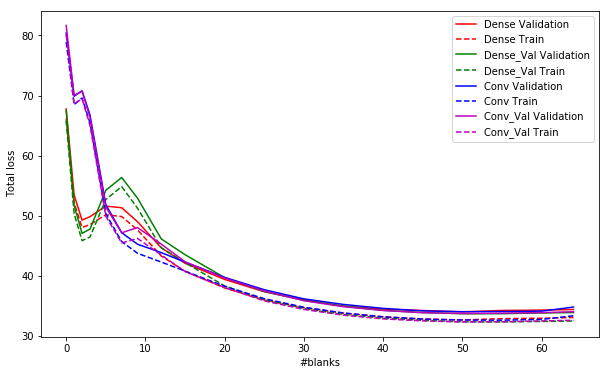

In [22]:
# plot loss
plt.figure(figsize=(10, 6))
plt.plot(dense_val_evals[:, 0], dense_val_evals[:, 1], 'r-', label='Dense Validation')
plt.plot(dense_train_evals[:, 0], dense_train_evals[:, 1], 'r--', label='Dense Train')
plt.plot(dense_val_val_evals[:, 0], dense_val_val_evals[:, 1], 'g-', label='Dense_Val Validation')
plt.plot(dense_val_train_evals[:, 0], dense_val_train_evals[:, 1], 'g--', label='Dense_Val Train')
plt.plot(conv_val_evals[:, 0], conv_val_evals[:, 1], 'b-', label='Conv Validation')
plt.plot(conv_train_evals[:, 0], conv_train_evals[:, 1], 'b--', label='Conv Train')
plt.plot(conv_val_val_evals[:, 0], conv_val_val_evals[:, 1], 'm-', label='Conv_Val Validation')
plt.plot(conv_val_train_evals[:, 0], conv_val_train_evals[:, 1], 'm--', label='Conv_Val Train')
plt.xlabel('#blanks')
plt.ylabel('Total loss')
plt.legend(loc='best')
plt.show()

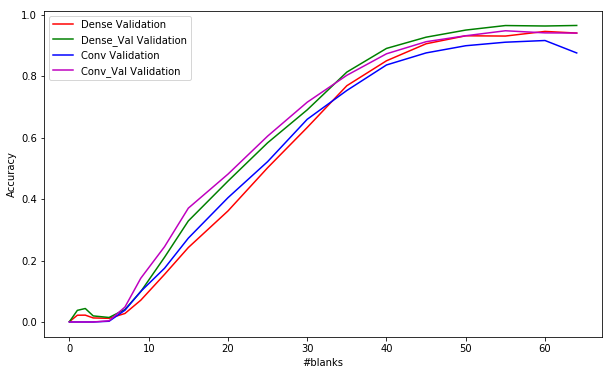

In [23]:
# plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(dense_val_evals[:, 0], dense_val_evals[:, 2], 'r-', label='Dense Validation')
# plt.plot(dense_train_evals[:, 0], dense_train_evals[:, 2], 'r--', label='Dense Train')
plt.plot(dense_val_val_evals[:, 0], dense_val_val_evals[:, 2], 'g-', label='Dense_Val Validation')
# plt.plot(dense_val_train_evals[:, 0], dense_val_train_evals[:, 2], 'g--', label='Dense_Val Train')
plt.plot(conv_val_evals[:, 0], conv_val_evals[:, 2], 'b-', label='Conv Validation')
# plt.plot(conv_train_evals[:, 0], conv_train_evals[:, 2], 'b--', label='Conv Train')
plt.plot(conv_val_val_evals[:, 0], conv_val_val_evals[:, 2], 'm-', label='Conv_Val Validation')
# plt.plot(conv_val_train_evals[:, 0], conv_val_train_evals[:, 2], 'm--', label='Conv_Val Train')

plt.xlabel('#blanks')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
# load latest model
dense = keras.models.load_model('./models/dense_model-64.h5')
conv = keras.models.load_model('./models/conv_model-64.h5')
dense_val = keras.models.load_model('./models/dense_val-64.h5')
conv_val = keras.models.load_model('./models/conv_val-64.h5')

In [10]:
# Evaluate on test set
start = time.time()
test_performance = evaluate_model(dense, X_kaggle_test)
print("Runtime: {} seconds".format(time.time() - start))
print("Dense model performance:")
print("\tNumber of test puzzles:", X_kaggle_test.shape[0])
print("\tNumber of correctly predicted puzzles:", np.sum(test_performance['validations']))
print("\tAccuracy:", test_performance['accuracy'])

Runtime: 119.75972890853882 seconds
Dense model performance:
	Number of test puzzles: 10000
	Number of correctly predicted puzzles: 9431
	Accuracy: 0.9431


In [11]:
# Evaluate on test set
start = time.time()
test_performance = evaluate_model(conv, X_kaggle_test)
print("Runtime: {} seconds".format(time.time() - start))
print("Convolutional model performance:")
print("\tNumber of test puzzles:", X_kaggle_test.shape[0])
print("\tNumber of correctly predicted puzzles:", np.sum(test_performance['validations']))
print("\tAccuracy:", test_performance['accuracy'])

Runtime: 174.26100373268127 seconds
Convolutional model performance:
	Number of test puzzles: 10000
	Number of correctly predicted puzzles: 8776
	Accuracy: 0.8776


### Additional evaluation

##### 17-givens.txt dataset with only 17 clues each puzzle

In [13]:
# load 17-givens dataset
given17 = pd.read_csv('./datasets/17-givens.csv').values
print("Full shape:", given17.shape)

Full shape: (49151, 1)


In [14]:
given17

array([['000000010400000000020000000000050407008000300001090000300400200050100000000806000'],
       ['000000010400000000020000000000050604008000300001090000300400200050100000000807000'],
       ['000000012000035000000600070700000300000400800100000000000120000080000040050000600'],
       ...,
       ['140805000006000070000000300000200010300070000500000000800000002010400000000000500'],
       ['080020000030000600000001000000630080100000500200000000000500401002300000700000000'],
       ['060000300400700000000000080000008012500600000000000050082000700000500600000010000']],
      dtype=object)

In [15]:
# preprocess
given17 = preprocess(given17[:, 0])[0]

Initial shape of X: (49151,)
Convert strings in X to: (49151, 81)
Reshape X to: (49151, 9, 9)
Shape of one-hot X: (49151, 9, 9, 10)


In [37]:
# run evaluate
start = time.time()
given17_performance = evaluate_model(dense, given17)
print("Runtime: {} seconds".format(time.time() - start))
print("Dense performance on 17-given puzzles:")
print("\tNumber of test puzzles:", given17.shape[0])
print("\tNumber of correctly predicted puzzles:", np.sum(given17_performance['validations']))
print("\tAccuracy:", given17_performance['accuracy'])

Runtime: 748.8157165050507 seconds
Dense performance on 17-given puzzles:
	Number of test puzzles: 49151
	Number of correctly predicted puzzles: 22
	Accuracy: 0.00044760025228377854


In [38]:
# run evaluate
start = time.time()
given17_performance = evaluate_model(conv, given17)
print("Runtime: {} seconds".format(time.time() - start))
print("Conv performance on 17-given puzzles:")
print("\tNumber of test puzzles:", given17.shape[0])
print("\tNumber of correctly predicted puzzles:", np.sum(given17_performance['validations']))
print("\tAccuracy:", given17_performance['accuracy'])

Runtime: 1037.2923321723938 seconds
Conv performance on 17-given puzzles:
	Number of test puzzles: 49151
	Number of correctly predicted puzzles: 23
	Accuracy: 0.0004679457182966776


##### UNL Sudoku dataset

In [18]:
# load UNL sudoku dataset
with open('./datasets/sudokus-unl.json') as read_file:
    sudokus_unl = np.array(json.load(read_file))
    
sudokus_unl.shape

(472, 13)

In [19]:
sudokus_unl[0]

array(['99', 'Base', 'Omaha World-Herald', '1', '2', '5',
       'March 24, 2009', '', 'Puzzle added by Jason Gaare',
       '100000026200709010030060000000800700710526038003007000000010050050603007960000004',
       '1', 'GAC', '29'], dtype='<U81')

In [20]:
# preprocess
sudoku_unl_puzzles = preprocess(sudokus_unl[:, 9])[0]

Initial shape of X: (472,)
Convert strings in X to: (472, 81)
Reshape X to: (472, 9, 9)
Shape of one-hot X: (472, 9, 9, 10)


In [26]:
# run evaluate
start = time.time()
dense_sudoku_unl_performance = evaluate_model(dense, sudoku_unl_puzzles)
print("Runtime: {} seconds".format(time.time() - start))
print("Dense performance on UNL puzzles:")
print("\tNumber of test puzzles:", sudoku_unl_puzzles.shape[0])
print("\tNumber of correctly predicted puzzles:", np.sum(dense_sudoku_unl_performance['validations']))
print("\tAccuracy:", dense_sudoku_unl_performance['accuracy'])

Runtime: 7.203768968582153 seconds
Dense performance on UNL puzzles:
	Number of test puzzles: 472
	Number of correctly predicted puzzles: 16
	Accuracy: 0.03389830508474576


In [27]:
# run evaluate
start = time.time()
conv_sudoku_unl_performance = evaluate_model(conv, sudoku_unl_puzzles)
print("Runtime: {} seconds".format(time.time() - start))
print("Conv performance on UNL puzzles:")
print("\tNumber of test puzzles:", sudoku_unl_puzzles.shape[0])
print("\tNumber of correctly predicted puzzles:", np.sum(conv_sudoku_unl_performance['validations']))
print("\tAccuracy:", conv_sudoku_unl_performance['accuracy'])

Runtime: 9.725974321365356 seconds
Conv performance on UNL puzzles:
	Number of test puzzles: 472
	Number of correctly predicted puzzles: 14
	Accuracy: 0.029661016949152543


In [28]:
# append to original array
sudoku_unl_combined = np.concatenate((sudokus_unl, 
                                      np.expand_dims(dense_sudoku_unl_performance['validations'], 
                                                     axis=1),
                                      np.expand_dims(conv_sudoku_unl_performance['validations'], 
                                                     axis=1)), 
                                     axis=1)
sudoku_unl_combined

array([['99', 'Base', 'Omaha World-Herald', ..., '29', 'True', 'False'],
       ['98', 'Base', 'Daily Nebraskan', ..., '29', 'True', 'False'],
       ['100', 'Base', 'LA Times', ..., '28', 'False', 'False'],
       ...,
       ['637', 'Base', 'Lincoln Journal Star', ..., '25', 'False',
        'False'],
       ['638', 'Base', 'Evan', ..., '22', 'False', 'False'],
       ['639', 'Base', 'RWallace', ..., '28', 'False', 'False']],
      dtype='<U81')

Dense solvable puzzles:


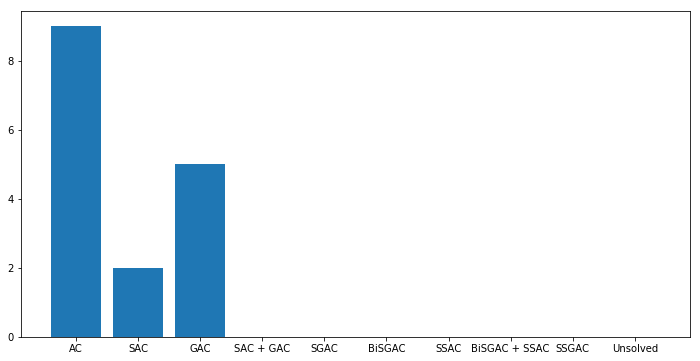

In [30]:
print("Dense solvable puzzles:")
# get solvable instances
solvables = sudoku_unl_combined[sudoku_unl_combined[:, -2] == 'True']

# Examine algorithms
solvable_algos = solvables[:, -4]
counter = Counter(solvable_algos)
algo_count = np.array(list(zip(counter.keys(), counter.values())))
algo_order = {'AC': 0, 'SAC': 1, 'GAC': 2, 'SAC + GAC': 3, 'SGAC': 4,
              'BiSGAC': 5, 'SSAC': 6, 'BiSGAC + SSAC': 7, 'SSGAC': 8,
              'Unsolved': 9}
for algo in algo_order.keys():
    if algo not in algo_count[:, 0]:
        algo_count = np.array(list(algo_count) + [[algo, '0']])
algo_count = np.array(sorted(algo_count, key=lambda x: algo_order[x[0]]))
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(algo_count)), list(map(int, algo_count[:, 1])))
plt.xticks(np.arange(len(algo_count)), algo_count[:, 0])
plt.show()

Conv solvable puzzles:


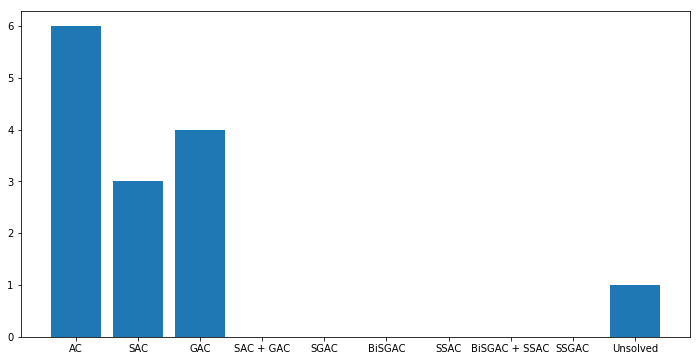

In [31]:
print("Conv solvable puzzles:")
# get solvable instances
solvables = sudoku_unl_combined[sudoku_unl_combined[:, -1] == 'True']

# Examine algorithms
solvable_algos = solvables[:, -4]
counter = Counter(solvable_algos)
algo_count = np.array(list(zip(counter.keys(), counter.values())))
algo_order = {'AC': 0, 'SAC': 1, 'GAC': 2, 'SAC + GAC': 3, 'SGAC': 4,
              'BiSGAC': 5, 'SSAC': 6, 'BiSGAC + SSAC': 7, 'SSGAC': 8,
              'Unsolved': 9}
for algo in algo_order.keys():
    if algo not in algo_count[:, 0]:
        algo_count = np.array(list(algo_count) + [[algo, '0']])
algo_count = np.array(sorted(algo_count, key=lambda x: algo_order[x[0]]))
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(algo_count)), list(map(int, algo_count[:, 1])))
plt.xticks(np.arange(len(algo_count)), algo_count[:, 0])
plt.show()